In [1]:
# CELDA 1: Configuración Inicial y Documentación
"""
Módulo de Prognosis Industrial
=============================

Objetivo: Implementar un sistema automatizado de prognosis para sistemas industriales
que permita detectar y predecir fallas basándose en:
1. Detección de anomalías
2. Análisis de tendencias
3. Evaluación de límites

Estructura del Notebook:
- Fase 1: Preprocesamiento de datos
- Fase 2: Identificación de variables clave
- Fase 3: Aprendizaje de línea base
- Fase 4: Detector de fallas

Autor: [Nombre]
Fecha: [Fecha]
Versión: 1.0
"""

# Importaciones necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import RFE
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any, Optional
from datetime import datetime
import json
import warnings
from statsmodels.tsa.stattools import acf

# Configuración inicial
plt.style.use('default')  # Usamos el estilo default de matplotlib
sns.set_theme(style="whitegrid")  # Configuramos el estilo de seaborn
warnings.filterwarnings('ignore')  # Ignorar warnings

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Configuración de visualización para notebooks
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

print("Configuración inicial completada exitosamente.")

Configuración inicial completada exitosamente.


In [2]:
# CELDA 2: Fase 1 - Preprocesamiento de Datos
"""
Fase 1: Preprocesamiento de Datos
================================

Esta fase implementa:
1. Carga y validación de datos
2. Control de calidad
3. Normalización y escalado
4. Análisis estadístico inicial

Características principales:
- Manejo de datos faltantes y outliers
- Normalización robusta
- Generación de reportes de calidad
"""

class DataPreprocessor:
    def __init__(self):
        """Inicializa el preprocesador con configuraciones por defecto"""
        self.scaler = RobustScaler()  # Más robusto que StandardScaler para datos industriales
        self.stats = {}
        self.quality_report = {
            'missing_values': {},
            'infinite_values': {},
            'outliers': {},
            'irrelevant_columns': [],
            'data_types': {},
            'warnings': [],
            'errors': []
        }
        self._setup_logging()

    def _setup_logging(self):
        """Configura el sistema de logging"""
        self.logger = logging.getLogger(__name__)

    def process_data(self, data_path: str) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """
        Procesa los datos desde el archivo fuente.
        
        Args:
            data_path: Ruta al archivo de datos (.csv o .xlsx)
            
        Returns:
            Tuple[pd.DataFrame, Dict]: Datos procesados y reporte de calidad
        """
        try:
            self.logger.info("Iniciando preprocesamiento de datos...")
            
            # 1. Carga y validación inicial
            data = self._load_data(data_path)
            if data is None:
                return None, self.quality_report
            
            # 2. Control de calidad
            data = self._quality_control(data)
            if data is None:
                return None, self.quality_report
                
            # 3. Normalización y escalado
            data_processed = self._normalize_data(data)
            
            # 4. Análisis estadístico
            self._perform_statistical_analysis(data_processed)
            
            results = {
                'quality_report': self.quality_report,
                'statistics': self.stats,
                'data_shape': data_processed.shape,
                'columns': list(data_processed.columns),
                'processing_summary': {
                    'initial_shape': data.shape,
                    'final_shape': data_processed.shape,
                    'removed_columns': self.quality_report['irrelevant_columns']
                }
            }
            
            self.logger.info("Preprocesamiento completado exitosamente")
            return data_processed, results
            
        except Exception as e:
            self.logger.error(f"Error en preprocesamiento: {str(e)}")
            return None, None

    def _load_data(self, path: str) -> Optional[pd.DataFrame]:
        """Carga los datos desde archivo"""
        try:
            if path.endswith('.xlsx'):
                data = pd.read_excel(path)
            elif path.endswith('.csv'):
                data = pd.read_csv(path)
            else:
                self.logger.error("Formato de archivo no soportado")
                return None
            
            self.logger.info(f"Datos cargados: {data.shape[0]} filas, {data.shape[1]} columnas")
            return data
            
        except Exception as e:
            self.logger.error(f"Error en carga de datos: {str(e)}")
            return None

    def _quality_control(self, data: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Realiza control de calidad en los datos"""
        try:
            # 1. Análisis de valores faltantes
            for column in data.columns:
                missing = data[column].isnull().sum()
                self.quality_report['missing_values'][column] = missing
                
                if missing > 0:
                    if missing/len(data) > 0.5:  # Si más del 50% son nulos
                        self.quality_report['irrelevant_columns'].append(column)
                    else:
                        if pd.api.types.is_numeric_dtype(data[column]):
                            data[column] = data[column].interpolate(method='linear')
                        else:
                            data[column] = data[column].fillna(data[column].mode()[0])
            
            # 2. Manejo de infinitos
            numeric_columns = data.select_dtypes(include=[np.number]).columns
            for column in numeric_columns:
                inf_mask = np.isinf(data[column])
                inf_count = inf_mask.sum()
                self.quality_report['infinite_values'][column] = inf_count
                
                if inf_count > 0:
                    data[column] = data[column].replace([np.inf, -np.inf], np.nan)
                    data[column] = data[column].interpolate(method='linear')
            
            # 3. Detección de outliers
            for column in numeric_columns:
                z_scores = np.abs(stats.zscore(data[column]))
                outliers = (z_scores > 3).sum()
                self.quality_report['outliers'][column] = outliers
            
            return data
            
        except Exception as e:
            self.logger.error(f"Error en control de calidad: {str(e)}")
            return None

    def _normalize_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """Normaliza las variables numéricas"""
        try:
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                data[numeric_cols] = self.scaler.fit_transform(data[numeric_cols])
            return data
                
        except Exception as e:
            self.logger.error(f"Error en normalización: {str(e)}")
            return data

    def _perform_statistical_analysis(self, data: pd.DataFrame):
        """Realiza análisis estadístico de los datos"""
        try:
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            
            for column in numeric_cols:
                self.stats[column] = {
                    'basic_stats': {
                        'mean': float(data[column].mean()),
                        'std': float(data[column].std()),
                        'min': float(data[column].min()),
                        'max': float(data[column].max()),
                        'median': float(data[column].median())
                    },
                    'distribution': {
                        'skewness': float(data[column].skew()),
                        'kurtosis': float(data[column].kurtosis())
                    }
                }
            
            if len(numeric_cols) > 1:
                self.stats['correlations'] = data[numeric_cols].corr().to_dict()
                
        except Exception as e:
            self.logger.error(f"Error en análisis estadístico: {str(e)}")

# Función de prueba
def test_preprocessing():
    """Prueba el preprocesamiento de datos"""
    try:
        print("\n=== PRUEBA DE PREPROCESAMIENTO ===\n")
        
        # Crear instancia del preprocesador
        preprocessor = DataPreprocessor()
        
        # Procesar datos
        data_path = "filtered_consolidated_data_cleaned.xlsx"
        processed_data, results = preprocessor.process_data(data_path)
        
        if processed_data is not None:
            print("\nResumen del procesamiento:")
            print(f"Forma inicial: {results['processing_summary']['initial_shape']}")
            print(f"Forma final: {results['processing_summary']['final_shape']}")
            print(f"\nColumnas removidas: {len(results['processing_summary']['removed_columns'])}")
            
            # Mostrar primeras filas de datos procesados
            print("\nMuestra de datos procesados:")
            print(processed_data.head())
            
            return processed_data, results
        else:
            print("Error en el preprocesamiento")
            return None, None
            
    except Exception as e:
        print(f"Error en prueba: {str(e)}")
        return None, None

# Ejecutar prueba
processed_data, preprocessing_results = test_preprocessing()

2024-12-20 17:32:30,548 - INFO - Iniciando preprocesamiento de datos...



=== PRUEBA DE PREPROCESAMIENTO ===



2024-12-20 17:32:36,369 - INFO - Datos cargados: 7141 filas, 57 columnas
2024-12-20 17:32:36,714 - INFO - Preprocesamiento completado exitosamente



Resumen del procesamiento:
Forma inicial: (7141, 57)
Forma final: (7141, 57)

Columnas removidas: 0

Muestra de datos procesados:
   Tensión: L1 (V)  Tensión: L2 (V)  Tensión: L3 (V)  Tensión: L1 - L2 (V)  \
0        -0.018462        -0.192635        -0.074713             -0.134907   
1         0.076923        -0.116147        -0.002874             -0.053963   
2         0.092308        -0.099150         0.025862             -0.043845   
3         0.089231        -0.113314         0.025862             -0.048904   
4         0.113846        -0.099150         0.020115             -0.026981   

   Tensión: L2 - L3 (V)  Tensión: L3 - L1 (V)           timestamp  \
0             -0.136824             -0.025773 2013-05-04 16:07:00   
1             -0.064189              0.067010 2013-05-04 16:08:00   
2             -0.035473              0.087629 2013-05-04 16:09:00   
3             -0.045608              0.087629 2013-05-04 16:10:00   
4             -0.047297              0.096220 2013-05-0

2024-12-20 17:32:36,831 - INFO - Iniciando análisis de variables...



INICIANDO ANÁLISIS DE VARIABLES
Analizando 56 variables numéricas...


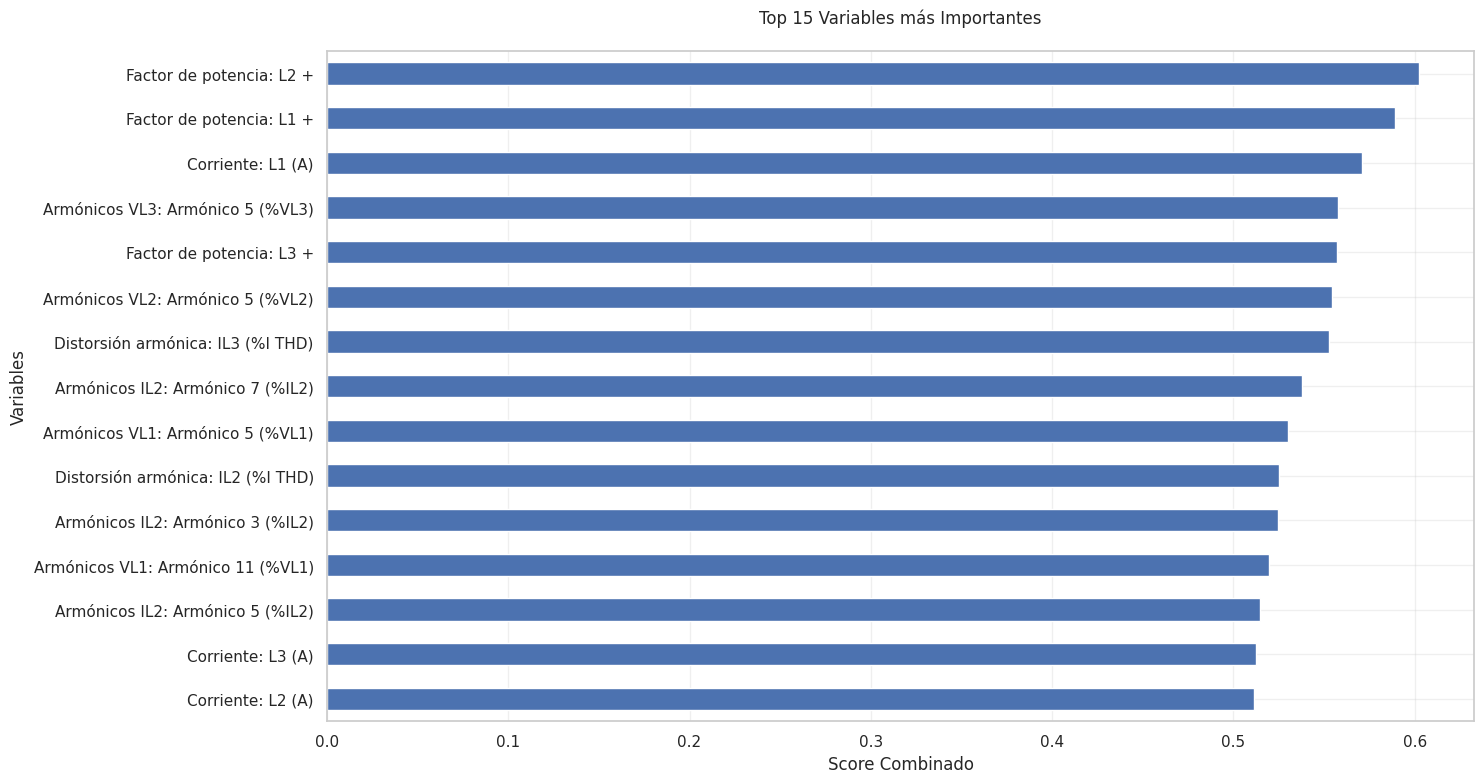

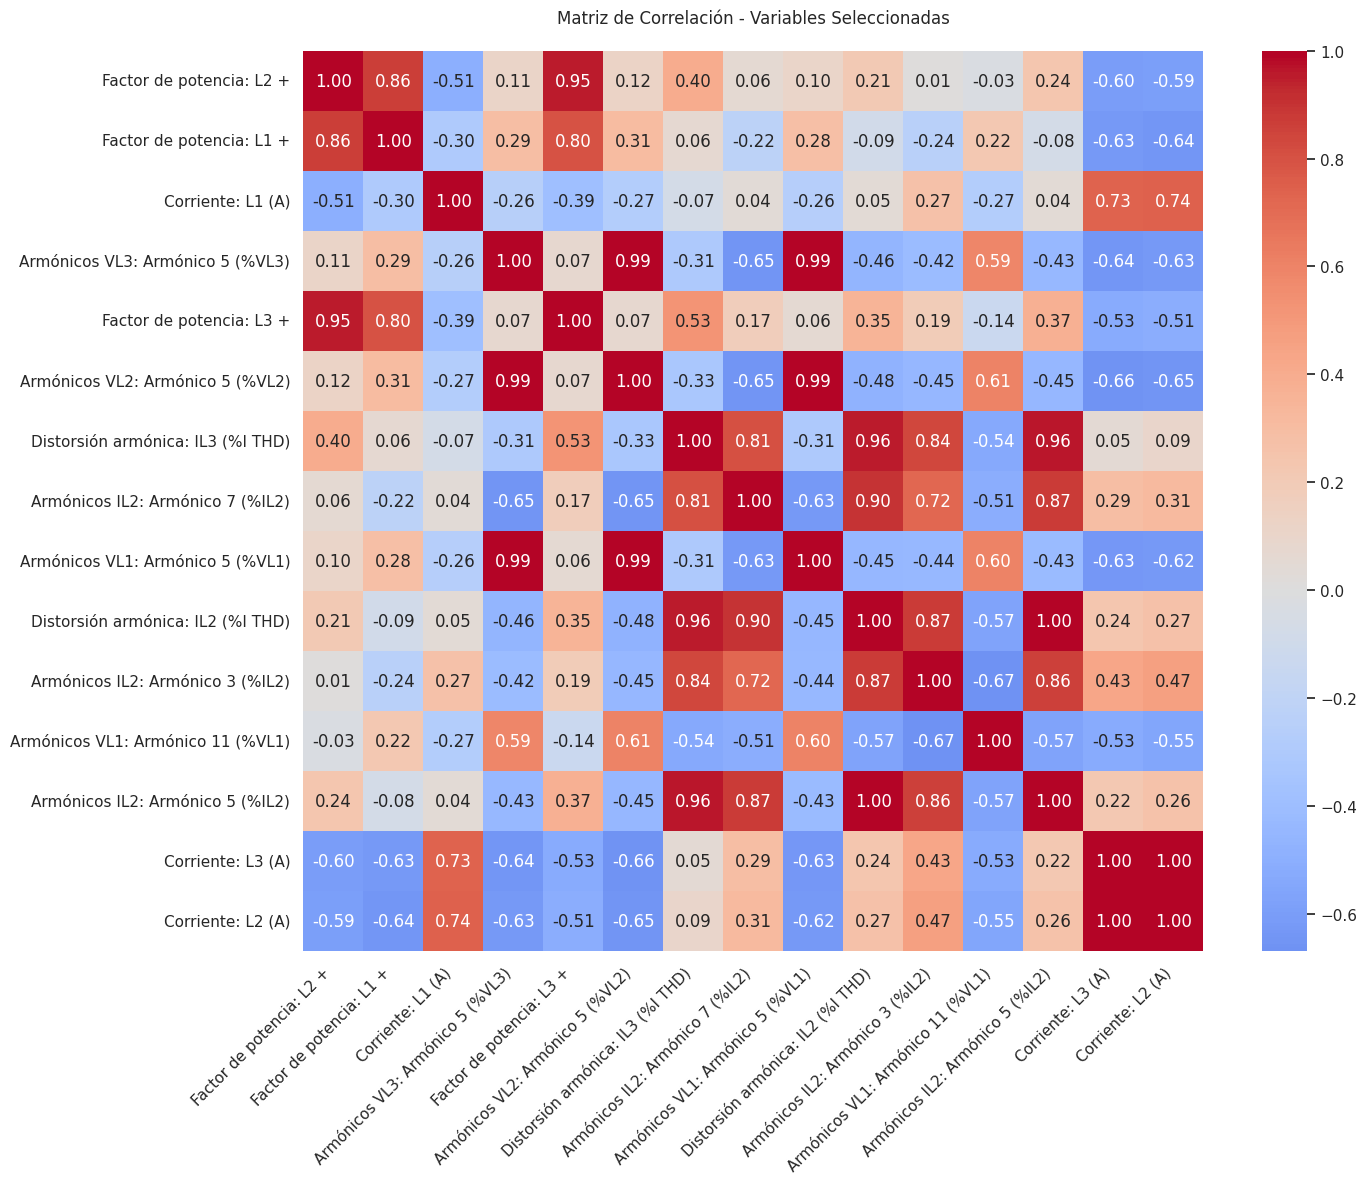

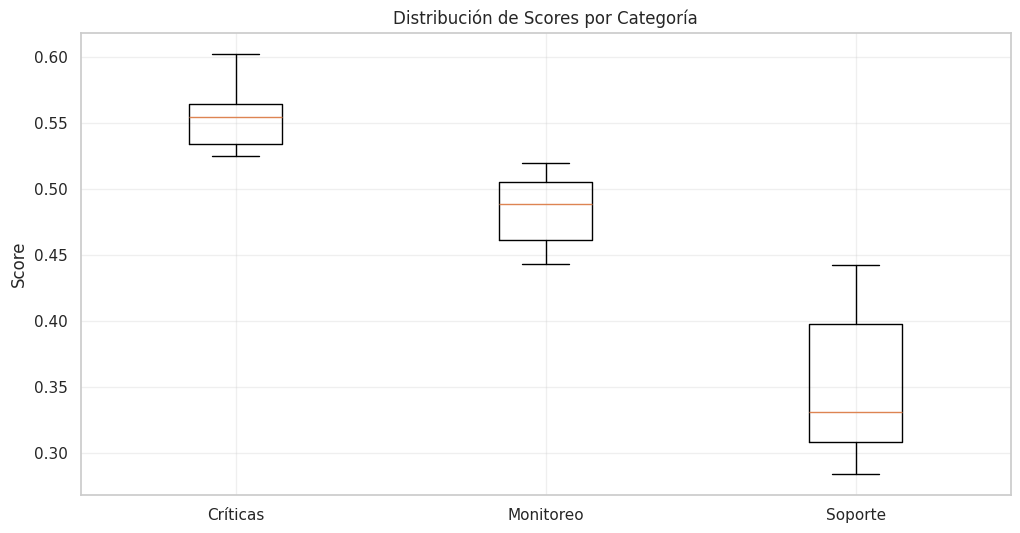


Variables críticas identificadas:
- Factor de potencia: L2 +
- Factor de potencia: L1 +
- Corriente: L1 (A)
- Armónicos VL3: Armónico 5 (%VL3)
- Factor de potencia: L3 +
- Armónicos VL2: Armónico 5 (%VL2)
- Distorsión armónica: IL3 (%I THD)
- Armónicos IL2: Armónico 7 (%IL2)
- Armónicos VL1: Armónico 5 (%VL1)
- Distorsión armónica: IL2 (%I THD)
- Armónicos IL2: Armónico 3 (%IL2)
- Armónicos VL1: Armónico 11 (%VL1)
- Armónicos IL2: Armónico 5 (%IL2)
- Corriente: L3 (A)
- Corriente: L2 (A)

Total: 15 variables críticas


In [3]:
# CELDA 3: Fase 2 - Identificación de Variables Clave
"""
Fase 2: Identificación de Variables Clave
=======================================

Objetivos:
1. Identificar variables críticas para prognosis
2. Evaluar importancia multifactorial
3. Analizar patrones temporales
4. Determinar correlaciones significativas

Características:
- Análisis multidimensional eficiente
- Visualizaciones informativas
- Métricas de evaluación
- Categorización de variables
"""

import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración global de visualización
plt.style.use('default')
sns.set_theme(style="whitegrid")

class VariableAnalyzer:
    def __init__(self):
        """Inicialización del analizador"""
        self._setup_logging()
        self.scaler = RobustScaler()
        self.results = {
            'importance_scores': {},
            'temporal_patterns': {},
            'correlations': {},
            'selected_variables': {},
            'categories': {
                'critical': {},      # Variables críticas para prognosis
                'monitoring': {},    # Variables para monitoreo
                'supporting': {}     # Variables de soporte
            },
            'metrics': {},
            'visualizations': {}
        }

    def _setup_logging(self):
        """Configuración del sistema de logging"""
        self.logger = logging.getLogger(__name__)

    def analyze_variables(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Análisis principal de variables
        
        Args:
            data: DataFrame con datos preprocesados
            
        Returns:
            Dict con resultados completos del análisis
        """
        try:
            self.logger.info("Iniciando análisis de variables...")
            
            # Preparación de datos
            self.data = data
            self.numeric_data = data.select_dtypes(include=[np.number])
            
            print(f"Analizando {len(self.numeric_data.columns)} variables numéricas...")
            
            # 1. Análisis de Importancia
            self._analyze_variable_importance()
            
            # 2. Análisis de Patrones Temporales
            self._analyze_temporal_patterns()
            
            # 3. Análisis de Correlaciones
            self._analyze_correlations()
            
            # 4. Selección y Categorización
            self._select_and_categorize_variables()
            
            # 5. Generación de Visualizaciones
            self._generate_visualizations()
            
            # 6. Cálculo de Métricas
            self._calculate_metrics()
            
            return self.results
            
        except Exception as e:
            self.logger.error(f"Error en análisis: {str(e)}")
            return None

    def _analyze_variable_importance(self):
        """Análisis de importancia de variables con normalización mejorada"""
        try:
            # Calcular valores máximos para normalización
            max_values = {
                'variance': self.numeric_data.var().max(),
                'range': (self.numeric_data.max() - self.numeric_data.min()).max(),
                'std': self.numeric_data.std().max()
            }
            
            for column in self.numeric_data.columns:
                series = self.numeric_data[column]
                
                # 1. Estadísticas normalizadas
                stats_basic = {
                    'variance': float(np.var(series) / max_values['variance']),
                    'std': float(np.std(series) / max_values['std']),
                    'range': float((series.max() - series.min()) / max_values['range']),
                    'iqr': float((series.quantile(0.75) - series.quantile(0.25)) / max_values['range'])
                }
                
                # 2. Análisis de distribución normalizado
                stats_dist = {
                    'skewness': min(abs(float(series.skew())), 1.0),
                    'kurtosis': min(abs(float(series.kurtosis())), 1.0)
                }
                
                # 3. Detección de outliers normalizada
                z_scores = np.abs((series - series.mean()) / series.std())
                outliers_ratio = float((z_scores > 3).mean())
                
                # 4. Score combinado (todos los componentes entre 0 y 1)
                combined_score = (
                    0.3 * stats_basic['variance'] +
                    0.2 * stats_basic['range'] +
                    0.2 * (1 - outliers_ratio) +
                    0.15 * stats_dist['skewness'] +
                    0.15 * stats_basic['iqr']
                )
                
                self.results['importance_scores'][column] = {
                    'statistics': stats_basic,
                    'distribution': stats_dist,
                    'outliers_ratio': outliers_ratio,
                    'combined_score': float(combined_score)
                }
                
        except Exception as e:
            self.logger.error(f"Error en análisis de importancia: {str(e)}")

    def _analyze_temporal_patterns(self):
        """Análisis de patrones temporales mejorado"""
        try:
            for column in self.numeric_data.columns:
                series = self.numeric_data[column]
                
                # 1. Autocorrelación normalizada
                acf_value = acf(series, nlags=1)[1] if len(series) > 1 else 0
                acf_value = 0 if pd.isna(acf_value) else min(abs(acf_value), 1.0)
                
                # 2. Tendencia normalizada
                x = np.arange(len(series))
                z = np.polyfit(x, series, 1)
                trend_strength = min(abs(z[0]) / (series.std() + 1e-10), 1.0)
                
                # 3. Volatilidad normalizada
                changes = series.diff().dropna()
                volatility = min(np.std(changes) / (series.std() + 1e-10), 1.0)
                
                # 4. Estacionalidad normalizada
                seasonal_strength = self._quick_seasonality_check(series)
                
                # Score combinado
                combined_score = (
                    0.3 * acf_value +
                    0.3 * trend_strength +
                    0.2 * volatility +
                    0.2 * seasonal_strength
                )
                
                self.results['temporal_patterns'][column] = {
                    'autocorrelation': float(acf_value),
                    'trend_strength': float(trend_strength),
                    'volatility': float(volatility),
                    'seasonality': float(seasonal_strength),
                    'combined_score': float(combined_score)
                }
                
        except Exception as e:
            self.logger.error(f"Error en análisis temporal: {str(e)}")

    def _analyze_correlations(self):
        """Análisis de correlaciones mejorado"""
        try:
            corr_matrix = self.numeric_data.corr()
            
            for column in self.numeric_data.columns:
                correlations = corr_matrix[column].abs()
                
                # Excluir autocorrelación
                correlations = correlations.drop(column)
                
                # Métricas de correlación
                mean_corr = float(correlations.mean())
                max_corr = float(correlations.max())
                significant = correlations[correlations > 0.5]
                
                # Score combinado normalizado
                combined_score = (
                    0.4 * max_corr +
                    0.4 * mean_corr +
                    0.2 * (len(significant) / len(correlations))
                )
                
                self.results['correlations'][column] = {
                    'mean_correlation': mean_corr,
                    'max_correlation': max_corr,
                    'n_significant': len(significant),
                    'significant_vars': list(significant.index),
                    'combined_score': float(combined_score)
                }
                
        except Exception as e:
            self.logger.error(f"Error en análisis de correlaciones: {str(e)}")

    def _select_and_categorize_variables(self):
        """Selección y categorización mejorada de variables"""
        try:
            final_scores = {}
            
            for column in self.numeric_data.columns:
                # Obtener scores normalizados
                importance = self.results['importance_scores'][column]['combined_score']
                temporal = self.results['temporal_patterns'][column]['combined_score']
                correlation = self.results['correlations'][column]['combined_score']
                
                # Score final ponderado
                final_score = (
                    0.4 * importance +
                    0.3 * temporal +
                    0.3 * correlation
                )
                
                final_scores[column] = final_score
            
            # Categorización basada en percentiles
            scores_array = np.array(list(final_scores.values()))
            for column, score in final_scores.items():
                if score > np.percentile(scores_array, 80):
                    self.results['categories']['critical'][column] = score
                elif score > np.percentile(scores_array, 40):
                    self.results['categories']['monitoring'][column] = score
                else:
                    self.results['categories']['supporting'][column] = score
            
            # Seleccionar top 15 variables
            self.results['selected_variables'] = dict(
                sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:15]
            )
            
        except Exception as e:
            self.logger.error(f"Error en selección de variables: {str(e)}")

    def _generate_visualizations(self):
        """Generación de visualizaciones optimizada"""
        try:
            # 1. Gráfico de importancia
            fig1, ax1 = plt.subplots(figsize=(15, 8))
            scores = pd.Series(self.results['selected_variables'])
            scores.sort_values(ascending=True).plot(kind='barh', ax=ax1)
            ax1.set_title('Top 15 Variables más Importantes', pad=20)
            ax1.set_xlabel('Score Combinado')
            ax1.set_ylabel('Variables')
            ax1.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # 2. Matriz de correlación
            fig2, ax2 = plt.subplots(figsize=(15, 12))
            selected_vars = list(self.results['selected_variables'].keys())
            corr_matrix = self.numeric_data[selected_vars].corr()
            
            sns.heatmap(corr_matrix, 
                    ax=ax2,
                    annot=True, 
                    cmap='coolwarm', 
                    center=0, 
                    fmt='.2f',
                    square=True)
            
            ax2.set_title('Matriz de Correlación - Variables Seleccionadas', pad=20)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
            
            # 3. Distribución de scores por categoría
            fig3, ax3 = plt.subplots(figsize=(12, 6))
            categories_data = {
                'Críticas': list(self.results['categories']['critical'].values()),
                'Monitoreo': list(self.results['categories']['monitoring'].values()),
                'Soporte': list(self.results['categories']['supporting'].values())
            }
            
            plt.boxplot(categories_data.values(), labels=categories_data.keys())
            ax3.set_title('Distribución de Scores por Categoría')
            ax3.set_ylabel('Score')
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            self.logger.error(f"Error en visualizaciones: {str(e)}")
            print(f"Error específico: {str(e)}")

    def _calculate_metrics(self):
        """Cálculo de métricas finales"""
        try:
            self.results['metrics'] = {
                'n_variables_analyzed': len(self.numeric_data.columns),
                'n_variables_selected': len(self.results['selected_variables']),
                'n_critical_variables': len(self.results['categories']['critical']),
                'n_monitoring_variables': len(self.results['categories']['monitoring']),
                'n_supporting_variables': len(self.results['categories']['supporting']),
                'mean_importance_score': float(np.mean([
                    v['combined_score'] for v in self.results['importance_scores'].values()
                ])),
                'mean_temporal_score': float(np.mean([
                    v['combined_score'] for v in self.results['temporal_patterns'].values()
                ])),
                'mean_correlation_score': float(np.mean([
                    v['combined_score'] for v in self.results['correlations'].values()
                ]))
            }
        except Exception as e:
            self.logger.error(f"Error en cálculo de métricas: {str(e)}")

    def get_critical_variables(self) -> List[str]:
        """Retorna la lista de variables críticas identificadas."""
        try:
            if not self.results.get('selected_variables'):
                self.logger.warning("No hay variables críticas identificadas")
                return []
                
            return list(self.results['selected_variables'].keys())
            
        except Exception as e:
            self.logger.error(f"Error obteniendo variables críticas: {str(e)}")
            return []

    def _quick_seasonality_check(self, series: pd.Series) -> float:
        """Verificación rápida de estacionalidad normalizada"""
        try:
            if len(series) >= 48:
                seasonal_lag = 24
                seasonal_corr = series.autocorr(lag=seasonal_lag)
                return min(abs(seasonal_corr), 1.0) if not pd.isna(seasonal_corr) else 0
            return 0
        except:
            return 0

def test_variable_analysis(processed_data: pd.DataFrame):
    """Función de prueba para el análisis de variables"""
    try:
        print("\n" + "="*50)
        print("ANÁLISIS DETALLADO DE VARIABLES")
        print("="*50 + "\n")
        
        analyzer = VariableAnalyzer()
        analysis_results = analyzer.analyze_variables(processed_data)
        
        if analysis_results:
            # 1. Resumen General
            print("\nRESUMEN GENERAL:")
            print("="*20)
            metrics = analysis_results['metrics']
            print(f"Total variables analizadas: {metrics['n_variables_analyzed']}")
            print(f"Variables seleccionadas: {metrics['n_variables_selected']}")
            print(f"Variables críticas: {metrics['n_critical_variables']}")
            print(f"Variables de monitoreo: {metrics['n_monitoring_variables']}")
            print(f"Variables de soporte: {metrics['n_supporting_variables']}")
            print(f"\nScores promedio:")
            print(f"- Importancia: {metrics['mean_importance_score']:.3f}")
            print(f"- Temporal: {metrics['mean_temporal_score']:.3f}")
            print(f"- Correlación: {metrics['mean_correlation_score']:.3f}")
            
            # 2. Variables Seleccionadas
            print("\nTOP 15 VARIABLES MÁS RELEVANTES:")
            print("="*30)
            for var, score in analysis_results['selected_variables'].items():
                print(f"\n{var}")
                print("-"*len(var))
                print(f"Score general: {score:.3f}")
                print(f"Importancia:   {analysis_results['importance_scores'][var]['combined_score']:.3f}")
                print(f"Temporal:      {analysis_results['temporal_patterns'][var]['combined_score']:.3f}")
                print(f"Correlación:   {analysis_results['correlations'][var]['combined_score']:.3f}")
            
            return analysis_results
        else:
            print("Error en el análisis")
            return None
            
    except Exception as e:
        print(f"Error en prueba: {str(e)}")
        return None

# Ejecutar prueba si hay datos procesados
if 'processed_data' in globals() and processed_data is not None:
    print("\nINICIANDO ANÁLISIS DE VARIABLES")
    print("="*50)
    
    try:
        # Crear instancia del analizador
        variable_analyzer = VariableAnalyzer()
        
        # Ejecutar análisis
        variable_analysis = variable_analyzer.analyze_variables(processed_data)
        
        # Obtener variables críticas
        critical_vars = variable_analyzer.get_critical_variables()
        
        if critical_vars:
            print("\nVariables críticas identificadas:")
            for var in critical_vars:
                print(f"- {var}")
            print(f"\nTotal: {len(critical_vars)} variables críticas")
        else:
            print("\n⚠ No se identificaron variables críticas")
            
    except Exception as e:
        print(f"\n⚠ Error en análisis: {str(e)}")
        critical_vars = []

In [4]:
# CELDA 4: Fase 3 - Aprendizaje de línea base
"""
Fase 3: Aprendizaje de línea base
================================

Objetivo: Establecer el comportamiento normal de las variables críticas mediante:
1. Modelado de tendencias
2. Definición de límites adaptativos
3. Validación de modelos base
"""

import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.signal import find_peaks
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

class BaselineLearner:
    """Sistema de aprendizaje de línea base para variables críticas."""
    
    def __init__(self):
        """Inicializa el sistema de aprendizaje."""
        self._setup_logging()
        self._initialize_attributes()
        self.logger = logging.getLogger(__name__)

    def _setup_logging(self):
        """Configura el sistema de logging."""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def _initialize_attributes(self):
        """Inicializa las estructuras de datos del sistema."""
        self.results = {
            'baseline_models': {},
            'adaptive_limits': {},
            'validation_metrics': {},
            'quality_metrics': {},
            'warnings': [],
            'errors': []
        }
        self.data = None

    def learn_baseline(self, data: pd.DataFrame, variables: List[str]) -> Dict[str, Any]:
        """
        Aprende la línea base para las variables seleccionadas.
        
        Args:
            data: DataFrame con los datos históricos
            variables: Lista de variables a analizar
            
        Returns:
            Dict con los resultados del análisis
        """
        try:
            self.logger.info(f"Iniciando análisis de línea base para {len(variables)} variables")
            self.data = data.copy()
            
            for var in variables:
                try:
                    if var not in self.data.columns:
                        self.logger.warning(f"Variable {var} no encontrada")
                        continue
                        
                    self.logger.info(f"Procesando {var}")
                    series = self.data[var]
                    
                    # Validación inicial
                    valid, message = self._validate_for_baseline(series)
                    if not valid:
                        self.logger.warning(f"{var}: {message}")
                        continue
                    
                    # Ajustar modelo base
                    model = self._fit_baseline_model(series)
                    if not model:
                        continue
                        
                    self.results['baseline_models'][var] = model
                    
                    # Calcular límites adaptativos
                    limits = self._calculate_adaptive_limits(series, model)
                    if limits:
                        self.results['adaptive_limits'][var] = limits
                        
                        # Calcular métricas de calidad
                        quality = self._calculate_quality_metrics(series, model, limits)
                        self.results['quality_metrics'][var] = quality
                        
                        self.logger.info(f"{var}: Análisis completado (Calidad: {quality['overall_quality']:.2f})")
                    
                except Exception as e:
                    self.logger.error(f"Error procesando {var}: {str(e)}")
                    continue
                    
            # Validación final
            if not self.results['baseline_models']:
                self.logger.error("No se pudo analizar ninguna variable")
                return None
                
            self.logger.info(f"Análisis completado para {len(self.results['baseline_models'])} variables")
            return self.results
            
        except Exception as e:
            self.logger.error(f"Error en aprendizaje: {str(e)}")
            return None

    def _validate_for_baseline(self, series: pd.Series) -> Tuple[bool, str]:
        """
        Validación específica para análisis de línea base.
        
        Args:
            series: Serie temporal a validar
            
        Returns:
            Tuple[bool, str]: (es_válido, mensaje)
        """
        try:
            # 1. Verificar longitud mínima
            if len(series) < 100:
                return False, "Serie temporal insuficiente para análisis"
                
            # 2. Verificar variabilidad
            if np.std(series) < 1e-6:
                return False, "Variabilidad insuficiente"
                
            # 3. Verificar valores faltantes
            missing_pct = series.isna().mean()
            if missing_pct > 0.3:
                return False, f"Demasiados valores faltantes ({missing_pct:.1%})"
                
            return True, "Validación exitosa"
            
        except Exception as e:
            self.logger.error(f"Error en validación: {str(e)}")
            return False, str(e)

    def _fit_baseline_model(self, series: pd.Series) -> Dict[str, Any]:
        """
        Ajusta el modelo base para una serie temporal.
        
        Args:
            series: Serie temporal a modelar
            
        Returns:
            Dict con el modelo ajustado
        """
        try:
            # 1. Tendencia
            trend = self._fit_trend(series)
            if trend is None:
                raise ValueError("Fallo en ajuste de tendencia")
            
            # 2. Componente cíclico
            cyclic = self._analyze_cyclical_component(series)
            
            # 3. Variabilidad
            detrended = series - trend['values']
            variability = self._analyze_variability(detrended)
            
            return {
                'trend': trend,
                'cyclic': cyclic,
                'variability': variability,
                'metrics': {
                    'trend_quality': float(trend['metrics']['r2']),
                    'cyclic_strength': float(cyclic.get('strength', 0)),
                    'variability_score': float(variability['base_std'])
                }
            }
                
        except Exception as e:
            self.logger.error(f"Error en ajuste de modelo: {str(e)}")
            return None

    def _fit_trend(self, series: pd.Series) -> Dict[str, Any]:
        """
        Ajusta la tendencia de la serie.
        
        Args:
            series: Serie temporal
            
        Returns:
            Dict con tendencia y métricas
        """
        try:
            x = np.arange(len(series))
            
            # Manejo de outliers
            z_scores = np.abs(stats.zscore(series))
            clean_series = series.copy()
            clean_series[z_scores > 3] = np.nan
            clean_series = clean_series.interpolate(method='linear')
            
            # Ajuste polinomial
            coeffs = np.polyfit(x, clean_series, deg=2)
            trend = np.polyval(coeffs, x)
            
            # Métricas
            residuals = series - trend
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((series - series.mean())**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            rmse = np.sqrt(np.mean(residuals**2))
            
            return {
                'values': trend.tolist(),
                'coefficients': coeffs.tolist(),
                'metrics': {
                    'r2': float(r2),
                    'rmse': float(rmse)
                }
            }
        except Exception as e:
            self.logger.error(f"Error en ajuste de tendencia: {str(e)}")
            return None

    def _analyze_cyclical_component(self, series: pd.Series) -> Dict[str, Any]:
        """
        Analiza el componente cíclico de la serie.
        
        Args:
            series: Serie temporal
            
        Returns:
            Dict con análisis cíclico
        """
        try:
            # Análisis de autocorrelación
            max_lag = min(len(series)//2, 100)
            acf_values = acf(series, nlags=max_lag)[1:]
            
            # Detección de picos
            peaks, properties = find_peaks(acf_values, 
                                        height=0.3,
                                        distance=5,
                                        prominence=0.1)
            
            if len(peaks) > 0:
                period = peaks[0] + 1
                strength = float(acf_values[peaks[0]])
            else:
                period = None
                strength = 0.0
                
            return {
                'is_significant': bool(period is not None and strength > 0.3),
                'period': period,
                'strength': strength,
                'acf_values': acf_values.tolist()
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis cíclico: {str(e)}")
            return {
                'is_significant': False,
                'period': None,
                'strength': 0.0
            }

    def _analyze_variability(self, series: pd.Series) -> Dict[str, Any]:
        """
        Analiza la variabilidad de la serie.
        
        Args:
            series: Serie temporal
            
        Returns:
            Dict con análisis de variabilidad
        """
        try:
            # Estadísticas base
            base_std = float(np.std(series))
            
            # Análisis por ventanas
            window = min(50, len(series)//10)
            rolling_std = pd.Series(series).rolling(
                window=window,
                center=True,
                min_periods=1
            ).std()
            
            # Heteroscedasticidad
            std_ratio = rolling_std.max() / rolling_std.min() if rolling_std.min() > 0 else float('inf')
            
            return {
                'base_std': base_std,
                'rolling_std': rolling_std.tolist(),
                'is_heteroscedastic': bool(std_ratio > 2.0),
                'heteroscedasticity': {
                    'ratio': float(std_ratio),
                    'score': float(min(1.0, std_ratio / 5))
                }
            }
        except Exception as e:
            self.logger.error(f"Error en análisis de variabilidad: {str(e)}")
            return {'base_std': 0.0}

    def _calculate_adaptive_limits(self, series: pd.Series, model: Dict[str, Any]) -> Dict[str, List[float]]:
        """
        Calcula límites adaptativos basados en el modelo.
        
        Args:
            series: Serie temporal
            model: Modelo base ajustado
            
        Returns:
            Dict con límites superior e inferior
        """
        try:
            trend = np.array(model['trend']['values'])
            residuals = series - trend
            
            # Calcular límites adaptativos
            std = np.std(residuals)
            upper = trend + 3 * std
            lower = trend - 3 * std
            
            return {
                'upper': upper.tolist(),
                'lower': lower.tolist(),
                'std': float(std)
            }
        except Exception as e:
            self.logger.error(f"Error en cálculo de límites: {str(e)}")
            return None

    def _calculate_quality_metrics(self, series: pd.Series, model: Dict[str, Any], 
                                limits: Dict[str, List[float]]) -> Dict[str, float]:
        """
        Calcula métricas de calidad del modelo.
        
        Args:
            series: Serie temporal
            model: Modelo base ajustado
            limits: Límites adaptativos
            
        Returns:
            Dict con métricas de calidad
        """
        try:
            # Métricas base
            trend_quality = model['metrics']['trend_quality']
            cyclic_quality = model['cyclic']['strength'] if model['cyclic']['is_significant'] else 0
            
            # Cobertura de límites
            within_limits = (series >= np.array(limits['lower'])) & (series <= np.array(limits['upper']))
            coverage = float(np.mean(within_limits))
            
            # Calidad general
            overall_quality = 0.4 * trend_quality + 0.3 * cyclic_quality + 0.3 * coverage
            
            return {
                'trend_quality': float(trend_quality),
                'cyclic_quality': float(cyclic_quality),
                'limits_coverage': float(coverage),
                'overall_quality': float(overall_quality)
            }
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de métricas: {str(e)}")
            return {'overall_quality': 0.0}

    def visualize_results(self, var_name: str):
        """
        Visualiza los resultados del modelo base.
        
        Args:
            var_name: Nombre de la variable a visualizar
        """
        try:
            if var_name not in self.results['baseline_models']:
                print(f"No hay resultados para {var_name}")
                return
                
            # Configurar visualización
            plt.figure(figsize=(15, 10))
            gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1])
            
            # 1. Serie y tendencia
            ax1 = plt.subplot(gs[0])
            self._plot_series_and_trend(ax1, var_name)
            
            # 2. Componente cíclico
            ax2 = plt.subplot(gs[1])
            self._plot_cyclic_component(ax2, var_name)
            
            # 3. Variabilidad
            ax3 = plt.subplot(gs[2])
            self._plot_variability(ax3, var_name)
            
            plt.tight_layout()
            plt.show()
            
            # Mostrar métricas
            self._print_quality_metrics(var_name)
            
        except Exception as e:
            self.logger.error(f"Error en visualización: {str(e)}")

    def _plot_series_and_trend(self, ax: plt.Axes, var_name: str):
        """Grafica la serie y su tendencia."""
        try:
            series = self.data[var_name]
            model = self.results['baseline_models'][var_name]
            limits = self.results['adaptive_limits'][var_name]
            
            # Serie original
            ax.plot(series, 'b.', alpha=0.5, label='Datos')
            
            # Tendencia
            ax.plot(model['trend']['values'], 'r-', 
                   label='Tendencia', linewidth=2)
            
            # Límites
            ax.plot(limits['upper'], 'g--', label='Límites', alpha=0.5)
            ax.plot(limits['lower'], 'g--', alpha=0.5)
            
            ax.set_title(f'Análisis de {var_name}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        except Exception as e:
            self.logger.error(f"Error en gráfica principal: {str(e)}")

    def _plot_cyclic_component(self, ax: plt.Axes, var_name: str):
        """Grafica el componente cíclico."""
        try:
            model = self.results['baseline_models'][var_name]
            cyclic = model['cyclic']
            
            if cyclic['is_significant']:
                ax.plot(cyclic['acf_values'], 'b-', label='Autocorrelación')
                ax.axhline(y=0.3, color='r', linestyle='--', 
                          label='Umbral', alpha=0.5)
                
                ax.set_title(f'Componente Cíclico (Periodo: {cyclic["period"]})')
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No se detectó componente cíclico significativo',
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax.transAxes)
                
        except Exception as e:
            self.logger.error(f"Error en gráfica cíclica: {str(e)}")

    def _plot_variability(self, ax: plt.Axes, var_name: str):
        """Grafica el análisis de variabilidad."""
        try:
            model = self.results['baseline_models'][var_name]
            variability = model['variability']
            
            # Desviación estándar móvil
            ax.plot(variability['rolling_std'], 'g-', 
                   label='Variabilidad Local')
            
            # Línea base
            ax.axhline(y=variability['base_std'], color='r', 
                      linestyle='--', label='Base', alpha=0.5)
            
            # Información adicional
            status = "Heteroscedástico" if variability['is_heteroscedastic'] else "Homoscedástico"
            ax.text(0.02, 0.95, f"Estado: {status}",
                   transform=ax.transAxes,
                   bbox=dict(facecolor='white', alpha=0.8))
            
            ax.set_title('Análisis de Variabilidad')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        except Exception as e:
            self.logger.error(f"Error en gráfica de variabilidad: {str(e)}")

    def _print_quality_metrics(self, var_name: str):
        """Imprime las métricas de calidad."""
        try:
            metrics = self.results['quality_metrics'][var_name]
            
            print("\n=== MÉTRICAS DE CALIDAD ===")
            print(f"Variable: {var_name}")
            print(f"Calidad general: {metrics['overall_quality']:.2f}")
            print(f"- Tendencia: {metrics['trend_quality']:.2f}")
            print(f"- Componente cíclico: {metrics['cyclic_quality']:.2f}")
            print(f"- Cobertura de límites: {metrics['limits_coverage']:.2f}")
            
        except Exception as e:
            self.logger.error(f"Error en impresión de métricas: {str(e)}")


# Verificación de prerrequisitos y código de prueba
print("\nINICIANDO SISTEMA DE LÍNEA BASE")
print("="*50)

try:
    # 1. Validación de prerrequisitos
    if 'processed_data' not in globals():
        raise ValueError("Datos procesados no encontrados. Ejecute el preprocesamiento.")
        
    if 'critical_vars' not in globals():
        raise ValueError("Variables críticas no definidas. Ejecute el análisis de variables.")
        
    if not critical_vars:
        raise ValueError("Lista de variables críticas vacía")

    # 2. Crear y entrenar el sistema base
    baseline_learner = BaselineLearner()
    baseline_results = baseline_learner.learn_baseline(processed_data, critical_vars)

    # 3. Verificar inicialización
    if hasattr(baseline_learner, 'results') and baseline_learner.results['baseline_models']:
        print("\nEstado del sistema base:")
        print(f"- Modelos generados: {len(baseline_learner.results['baseline_models'])}")
        print(f"- Variables analizadas: {len(critical_vars)}")
        print("✓ Sistema base inicializado correctamente")
    else:
        print("⚠ Error en inicialización del sistema base")
        
except Exception as e:
    print(f"\n⚠ Error en sistema base: {str(e)}")

2024-12-20 17:32:40,680 - INFO - Iniciando análisis de línea base para 15 variables
2024-12-20 17:32:40,697 - INFO - Procesando Factor de potencia: L2 +
2024-12-20 17:32:40,720 - INFO - Factor de potencia: L2 +: Análisis completado (Calidad: 0.31)
2024-12-20 17:32:40,722 - INFO - Procesando Factor de potencia: L1 +
2024-12-20 17:32:40,743 - INFO - Factor de potencia: L1 +: Análisis completado (Calidad: 0.32)
2024-12-20 17:32:40,745 - INFO - Procesando Corriente: L1 (A)



INICIANDO SISTEMA DE LÍNEA BASE


2024-12-20 17:32:40,770 - INFO - Corriente: L1 (A): Análisis completado (Calidad: 0.49)
2024-12-20 17:32:40,772 - INFO - Procesando Armónicos VL3: Armónico 5 (%VL3)
2024-12-20 17:32:40,794 - INFO - Armónicos VL3: Armónico 5 (%VL3): Análisis completado (Calidad: 0.42)
2024-12-20 17:32:40,796 - INFO - Procesando Factor de potencia: L3 +
2024-12-20 17:32:40,821 - INFO - Factor de potencia: L3 +: Análisis completado (Calidad: 0.31)
2024-12-20 17:32:40,823 - INFO - Procesando Armónicos VL2: Armónico 5 (%VL2)
2024-12-20 17:32:40,847 - INFO - Armónicos VL2: Armónico 5 (%VL2): Análisis completado (Calidad: 0.42)
2024-12-20 17:32:40,850 - INFO - Procesando Distorsión armónica: IL3 (%I THD)
2024-12-20 17:32:40,871 - INFO - Distorsión armónica: IL3 (%I THD): Análisis completado (Calidad: 0.33)
2024-12-20 17:32:40,875 - INFO - Procesando Armónicos IL2: Armónico 7 (%IL2)
2024-12-20 17:32:40,902 - INFO - Armónicos IL2: Armónico 7 (%IL2): Análisis completado (Calidad: 0.38)
2024-12-20 17:32:40,905 - 


Estado del sistema base:
- Modelos generados: 15
- Variables analizadas: 15
✓ Sistema base inicializado correctamente


2024-12-20 17:32:41,104 - INFO - Iniciando análisis de línea base para 15 variables
2024-12-20 17:32:41,118 - INFO - Procesando Factor de potencia: L2 +
2024-12-20 17:32:41,133 - INFO - Factor de potencia: L2 +: Análisis completado (Calidad: 0.31)
2024-12-20 17:32:41,134 - INFO - Procesando Factor de potencia: L1 +
2024-12-20 17:32:41,152 - INFO - Factor de potencia: L1 +: Análisis completado (Calidad: 0.32)
2024-12-20 17:32:41,154 - INFO - Procesando Corriente: L1 (A)
2024-12-20 17:32:41,170 - INFO - Corriente: L1 (A): Análisis completado (Calidad: 0.49)
2024-12-20 17:32:41,172 - INFO - Procesando Armónicos VL3: Armónico 5 (%VL3)
2024-12-20 17:32:41,188 - INFO - Armónicos VL3: Armónico 5 (%VL3): Análisis completado (Calidad: 0.42)
2024-12-20 17:32:41,191 - INFO - Procesando Factor de potencia: L3 +
2024-12-20 17:32:41,211 - INFO - Factor de potencia: L3 +: Análisis completado (Calidad: 0.31)
2024-12-20 17:32:41,213 - INFO - Procesando Armónicos VL2: Armónico 5 (%VL2)
2024-12-20 17:32:


Iniciando sistema de prognosis...

PRUEBA DEL SISTEMA DE LÍNEA BASE

✓ Datos preprocesados disponibles
✓ Datos cargados: 7141 registros, 57 variables

Variables críticas identificadas (15):
- Factor de potencia: L2 +
- Factor de potencia: L1 +
- Corriente: L1 (A)
- Armónicos VL3: Armónico 5 (%VL3)
- Factor de potencia: L3 +
- Armónicos VL2: Armónico 5 (%VL2)
- Distorsión armónica: IL3 (%I THD)
- Armónicos IL2: Armónico 7 (%IL2)
- Armónicos VL1: Armónico 5 (%VL1)
- Distorsión armónica: IL2 (%I THD)
- Armónicos IL2: Armónico 3 (%IL2)
- Armónicos VL1: Armónico 11 (%VL1)
- Armónicos IL2: Armónico 5 (%IL2)
- Corriente: L3 (A)
- Corriente: L2 (A)

Validando calidad de datos...
✓ Factor de potencia: L2 +: 0.0% valores faltantes
✓ Factor de potencia: L1 +: 0.0% valores faltantes
✓ Corriente: L1 (A): 0.0% valores faltantes
✓ Armónicos VL3: Armónico 5 (%VL3): 0.0% valores faltantes
✓ Factor de potencia: L3 +: 0.0% valores faltantes
✓ Armónicos VL2: Armónico 5 (%VL2): 0.0% valores faltantes
✓ Di

2024-12-20 17:32:41,273 - INFO - Armónicos IL2: Armónico 7 (%IL2): Análisis completado (Calidad: 0.38)
2024-12-20 17:32:41,274 - INFO - Procesando Armónicos VL1: Armónico 5 (%VL1)
2024-12-20 17:32:41,292 - INFO - Armónicos VL1: Armónico 5 (%VL1): Análisis completado (Calidad: 0.41)
2024-12-20 17:32:41,294 - INFO - Procesando Distorsión armónica: IL2 (%I THD)
2024-12-20 17:32:41,312 - INFO - Distorsión armónica: IL2 (%I THD): Análisis completado (Calidad: 0.34)
2024-12-20 17:32:41,314 - INFO - Procesando Armónicos IL2: Armónico 3 (%IL2)
2024-12-20 17:32:41,334 - INFO - Armónicos IL2: Armónico 3 (%IL2): Análisis completado (Calidad: 0.33)
2024-12-20 17:32:41,336 - INFO - Procesando Armónicos VL1: Armónico 11 (%VL1)
2024-12-20 17:32:41,354 - INFO - Armónicos VL1: Armónico 11 (%VL1): Análisis completado (Calidad: 0.38)
2024-12-20 17:32:41,356 - INFO - Procesando Armónicos IL2: Armónico 5 (%IL2)
2024-12-20 17:32:41,373 - INFO - Armónicos IL2: Armónico 5 (%IL2): Análisis completado (Calidad:


Modelos generados: 15/15

Generando visualizaciones...

Analizando Factor de potencia: L2 +:


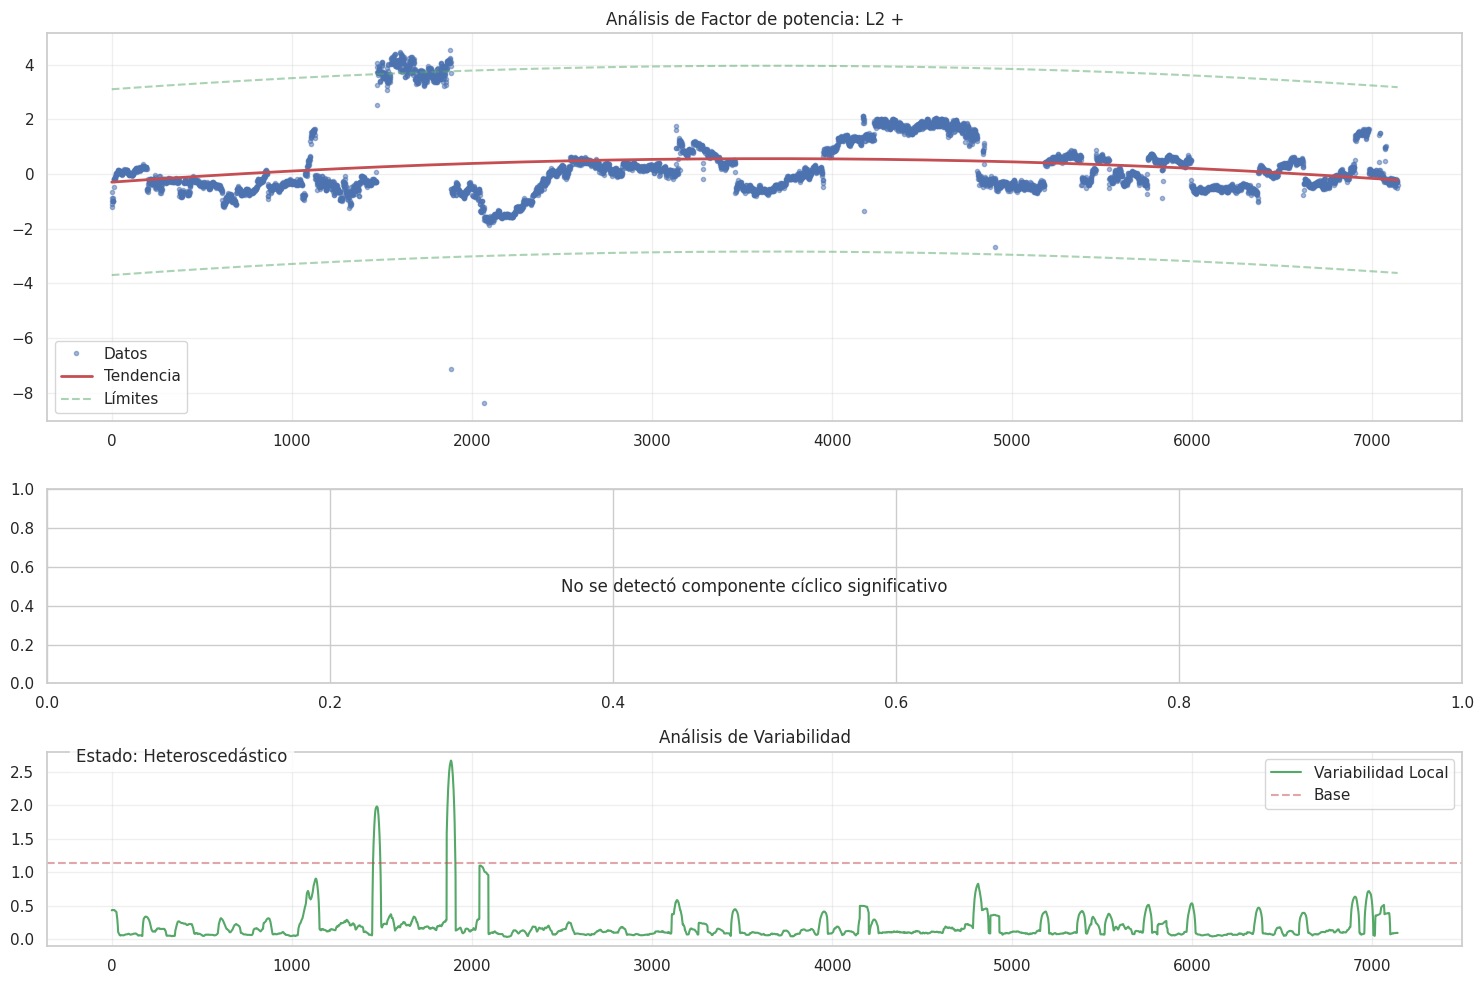


=== MÉTRICAS DE CALIDAD ===
Variable: Factor de potencia: L2 +
Calidad general: 0.31
- Tendencia: 0.04
- Componente cíclico: 0.00
- Cobertura de límites: 0.97

Métricas del modelo:
- Calidad general: 0.31
- Calidad de tendencia: 0.04
- Calidad cíclica: 0.00
- Cobertura de límites: 0.97
--------------------------------------------------

Analizando Factor de potencia: L1 +:


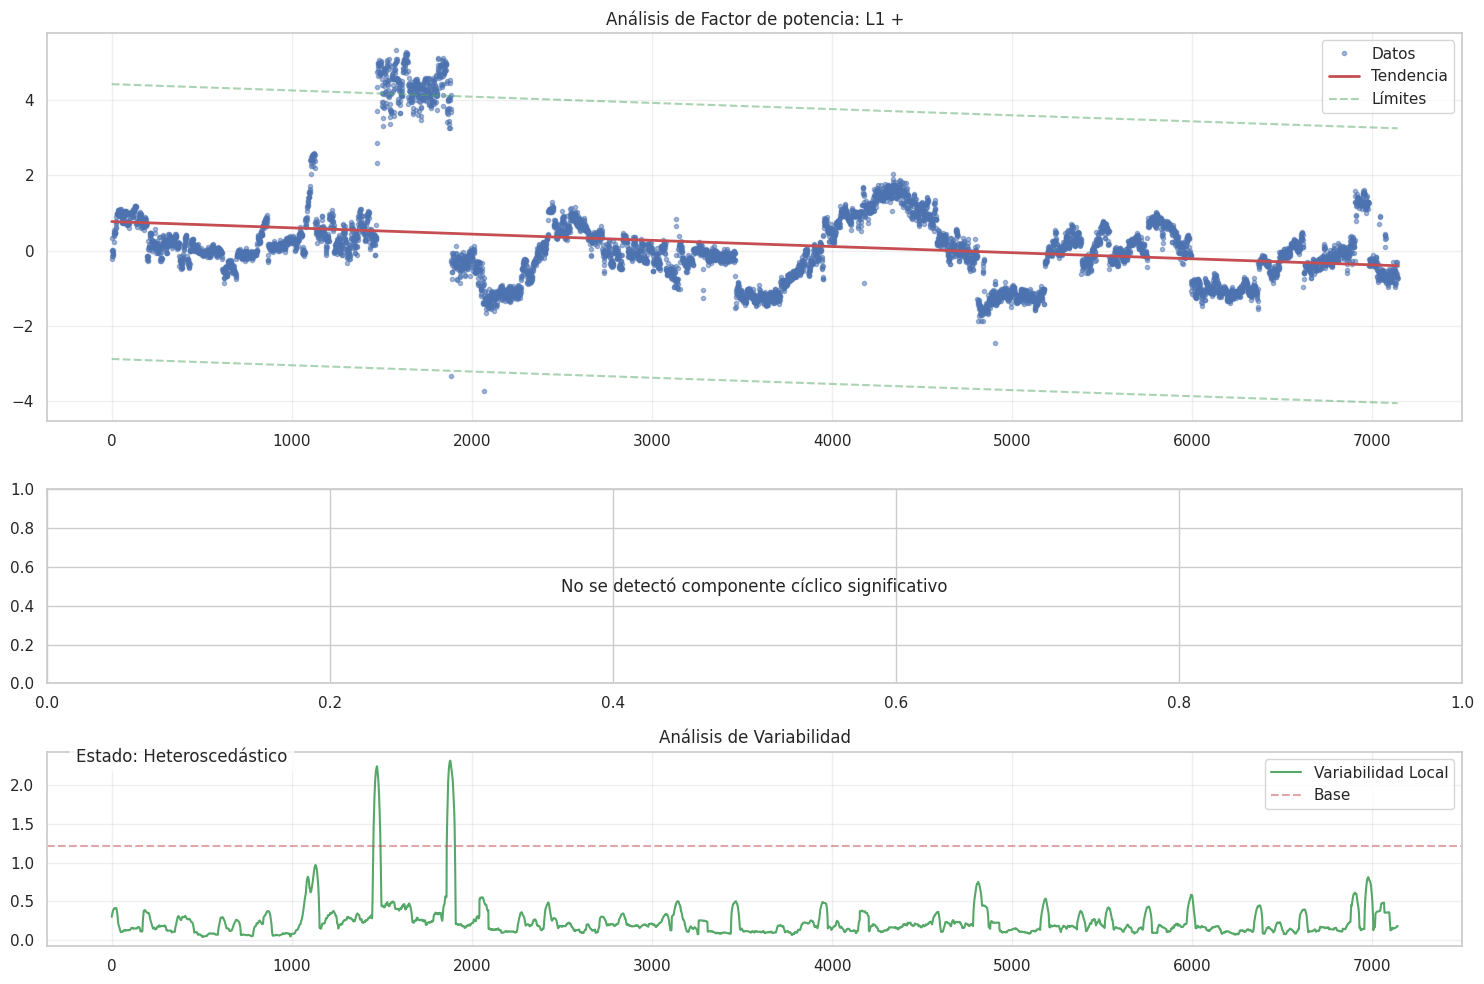


=== MÉTRICAS DE CALIDAD ===
Variable: Factor de potencia: L1 +
Calidad general: 0.32
- Tendencia: 0.08
- Componente cíclico: 0.00
- Cobertura de límites: 0.96

Métricas del modelo:
- Calidad general: 0.32
- Calidad de tendencia: 0.08
- Calidad cíclica: 0.00
- Cobertura de límites: 0.96
--------------------------------------------------

Analizando Corriente: L1 (A):


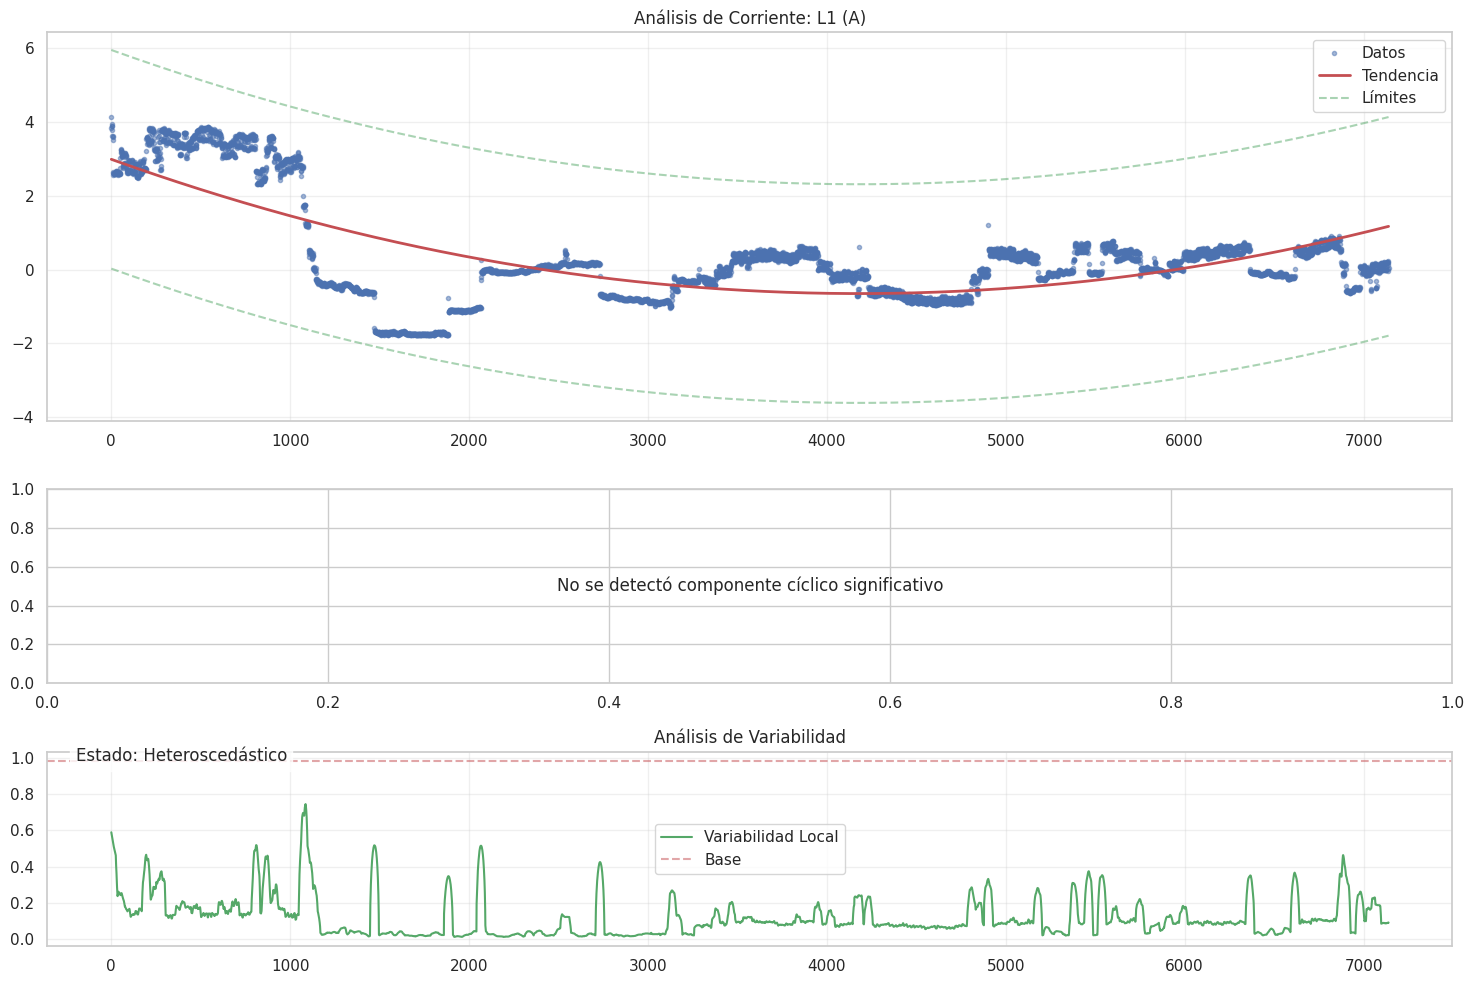


=== MÉTRICAS DE CALIDAD ===
Variable: Corriente: L1 (A)
Calidad general: 0.49
- Tendencia: 0.48
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.49
- Calidad de tendencia: 0.48
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Armónicos VL3: Armónico 5 (%VL3):


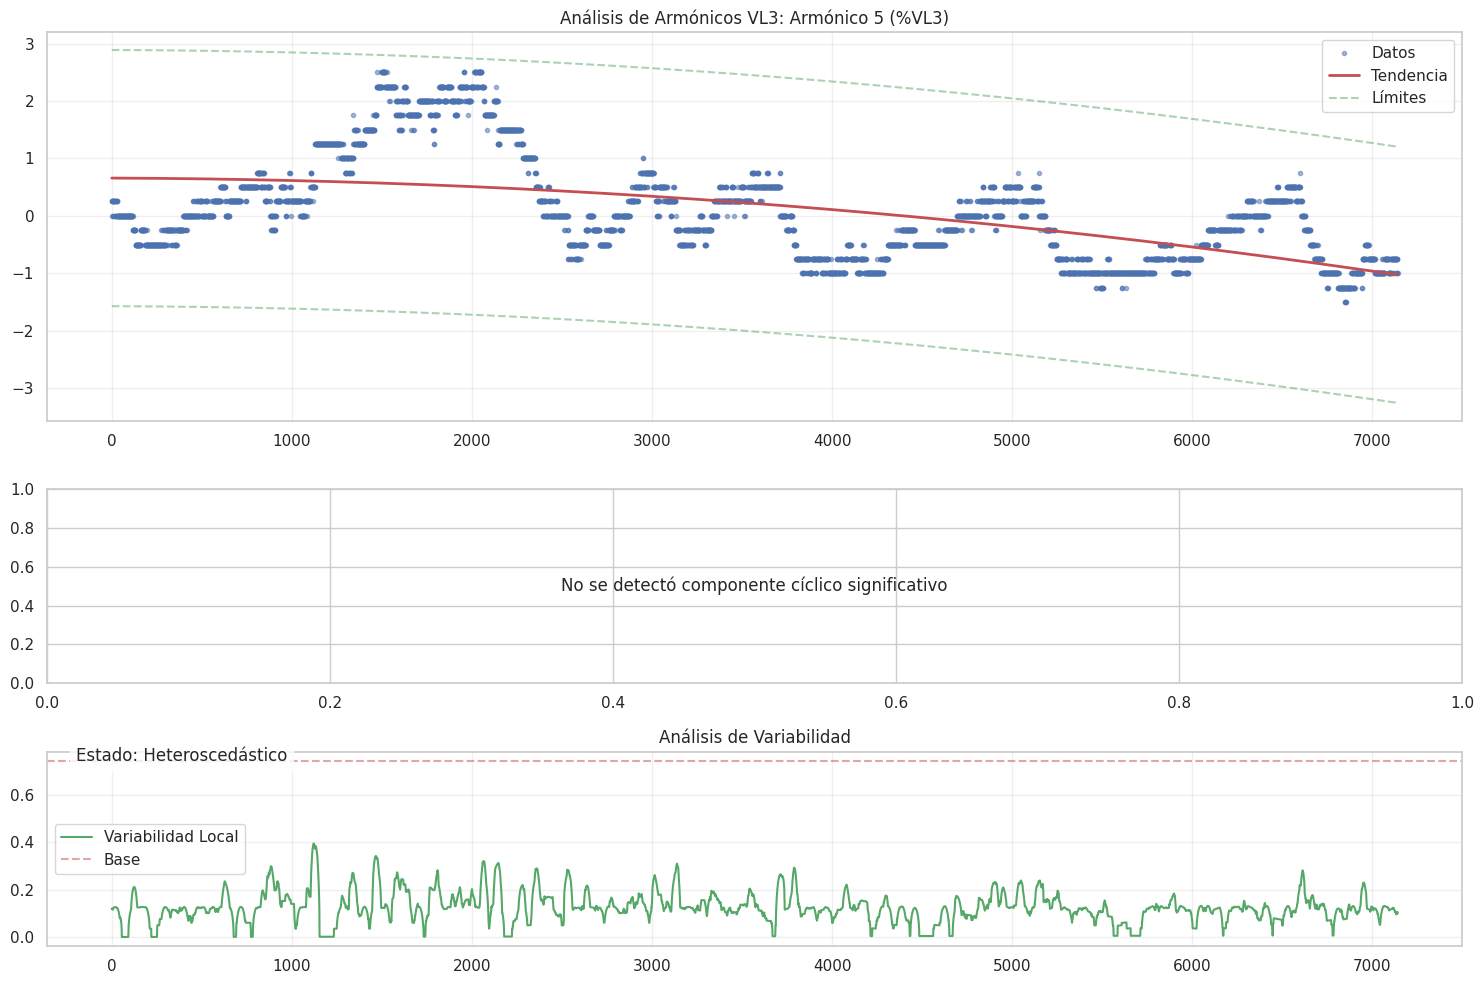


=== MÉTRICAS DE CALIDAD ===
Variable: Armónicos VL3: Armónico 5 (%VL3)
Calidad general: 0.42
- Tendencia: 0.31
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.42
- Calidad de tendencia: 0.31
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Factor de potencia: L3 +:


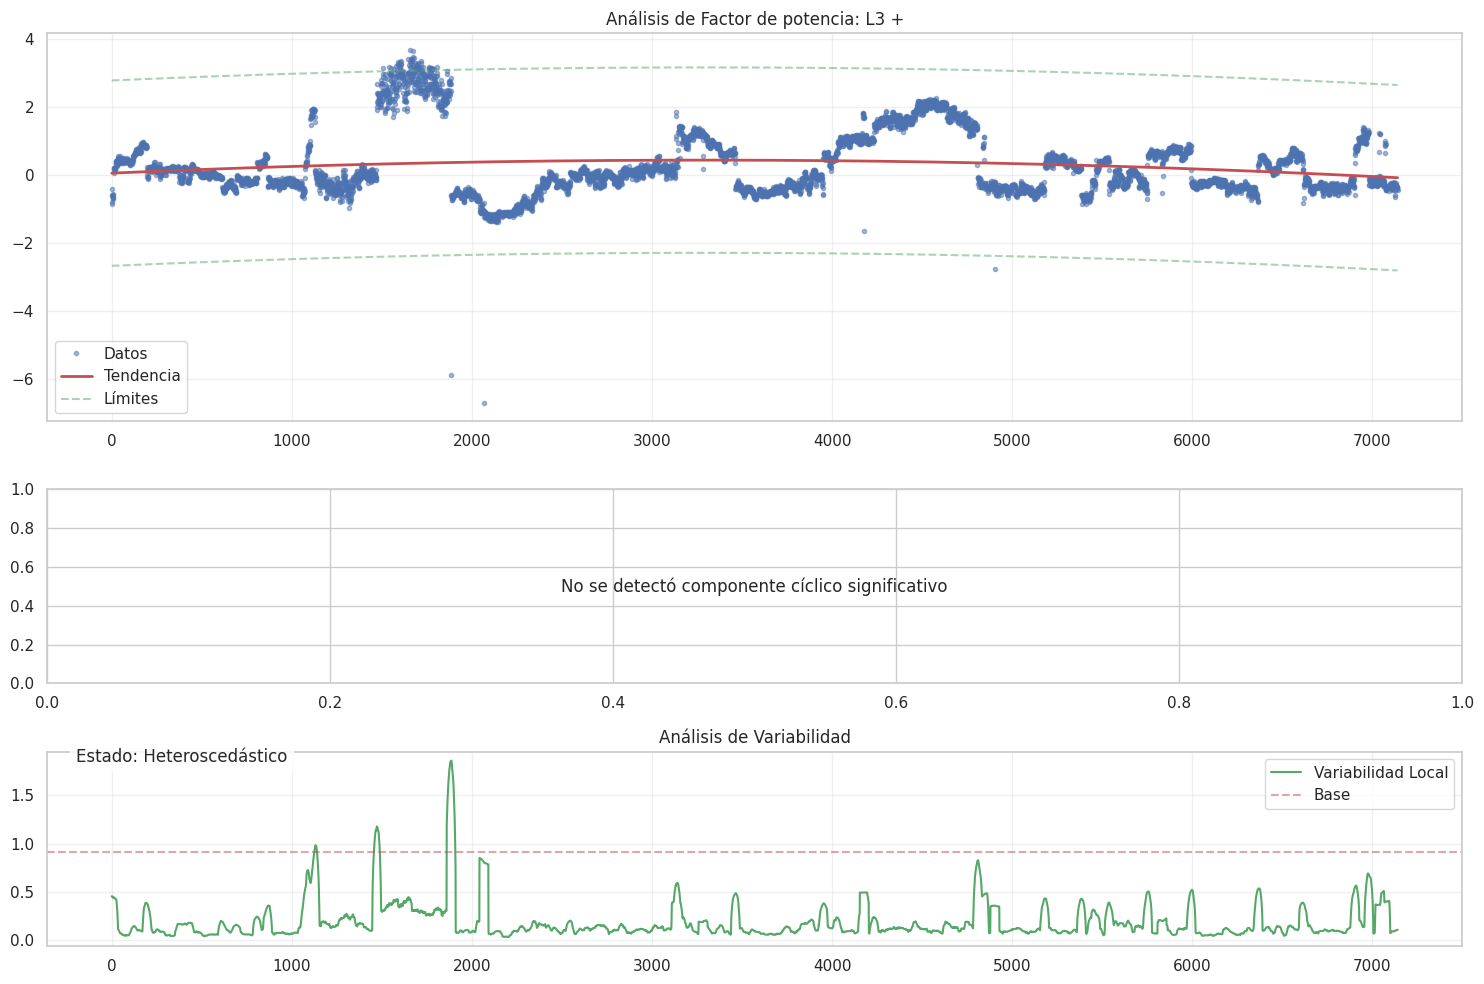


=== MÉTRICAS DE CALIDAD ===
Variable: Factor de potencia: L3 +
Calidad general: 0.31
- Tendencia: 0.02
- Componente cíclico: 0.00
- Cobertura de límites: 0.99

Métricas del modelo:
- Calidad general: 0.31
- Calidad de tendencia: 0.02
- Calidad cíclica: 0.00
- Cobertura de límites: 0.99
--------------------------------------------------

Analizando Armónicos VL2: Armónico 5 (%VL2):


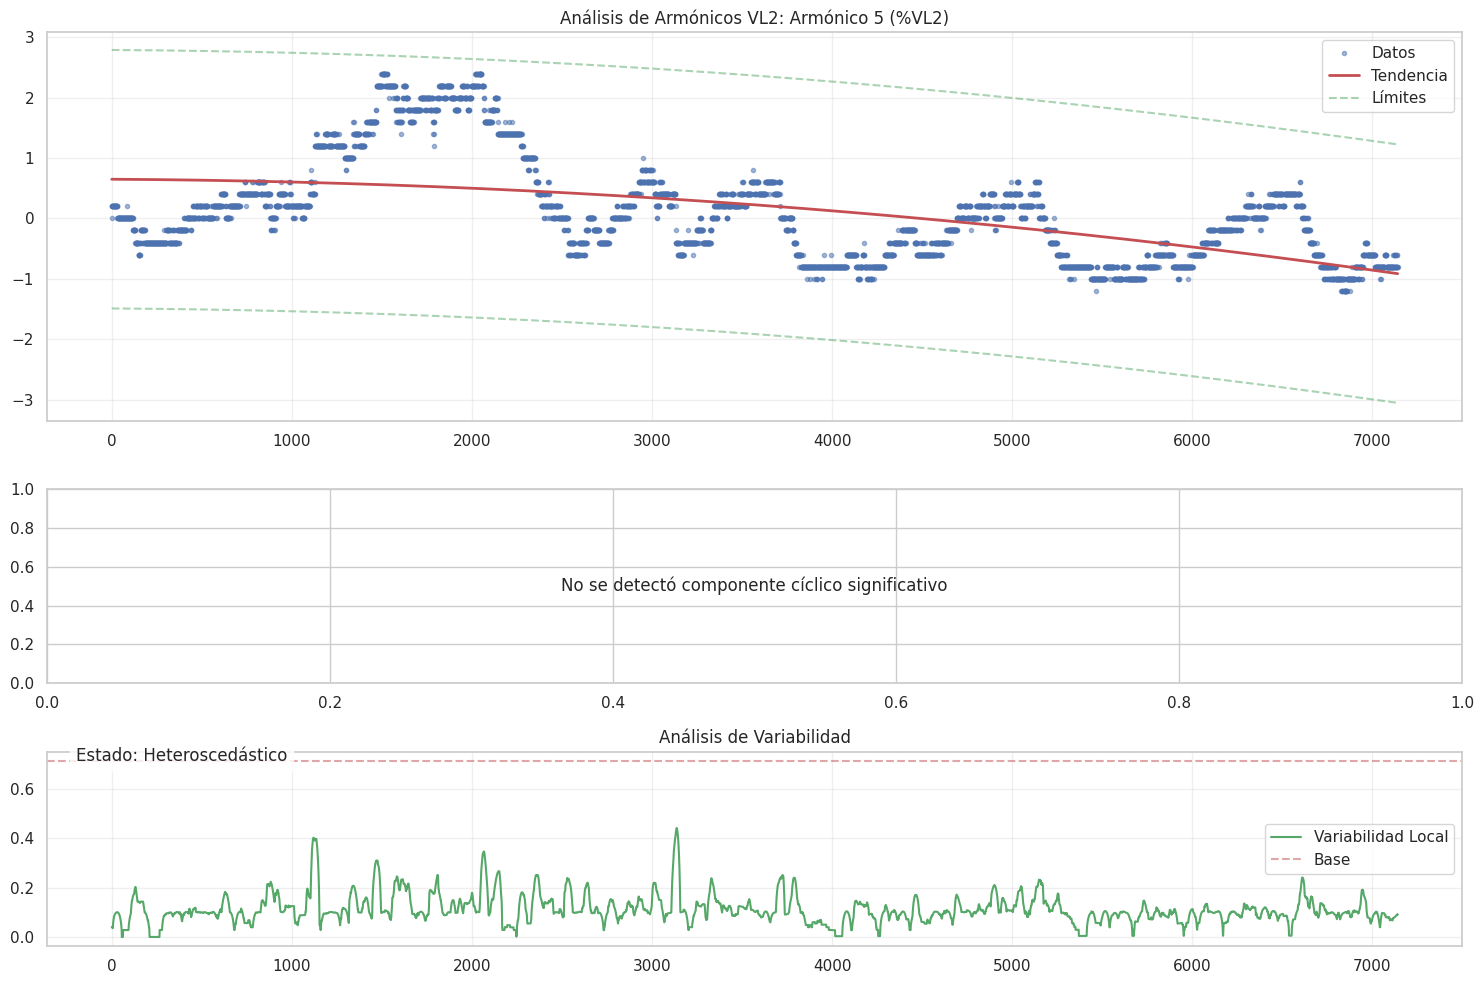


=== MÉTRICAS DE CALIDAD ===
Variable: Armónicos VL2: Armónico 5 (%VL2)
Calidad general: 0.42
- Tendencia: 0.30
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.42
- Calidad de tendencia: 0.30
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Distorsión armónica: IL3 (%I THD):


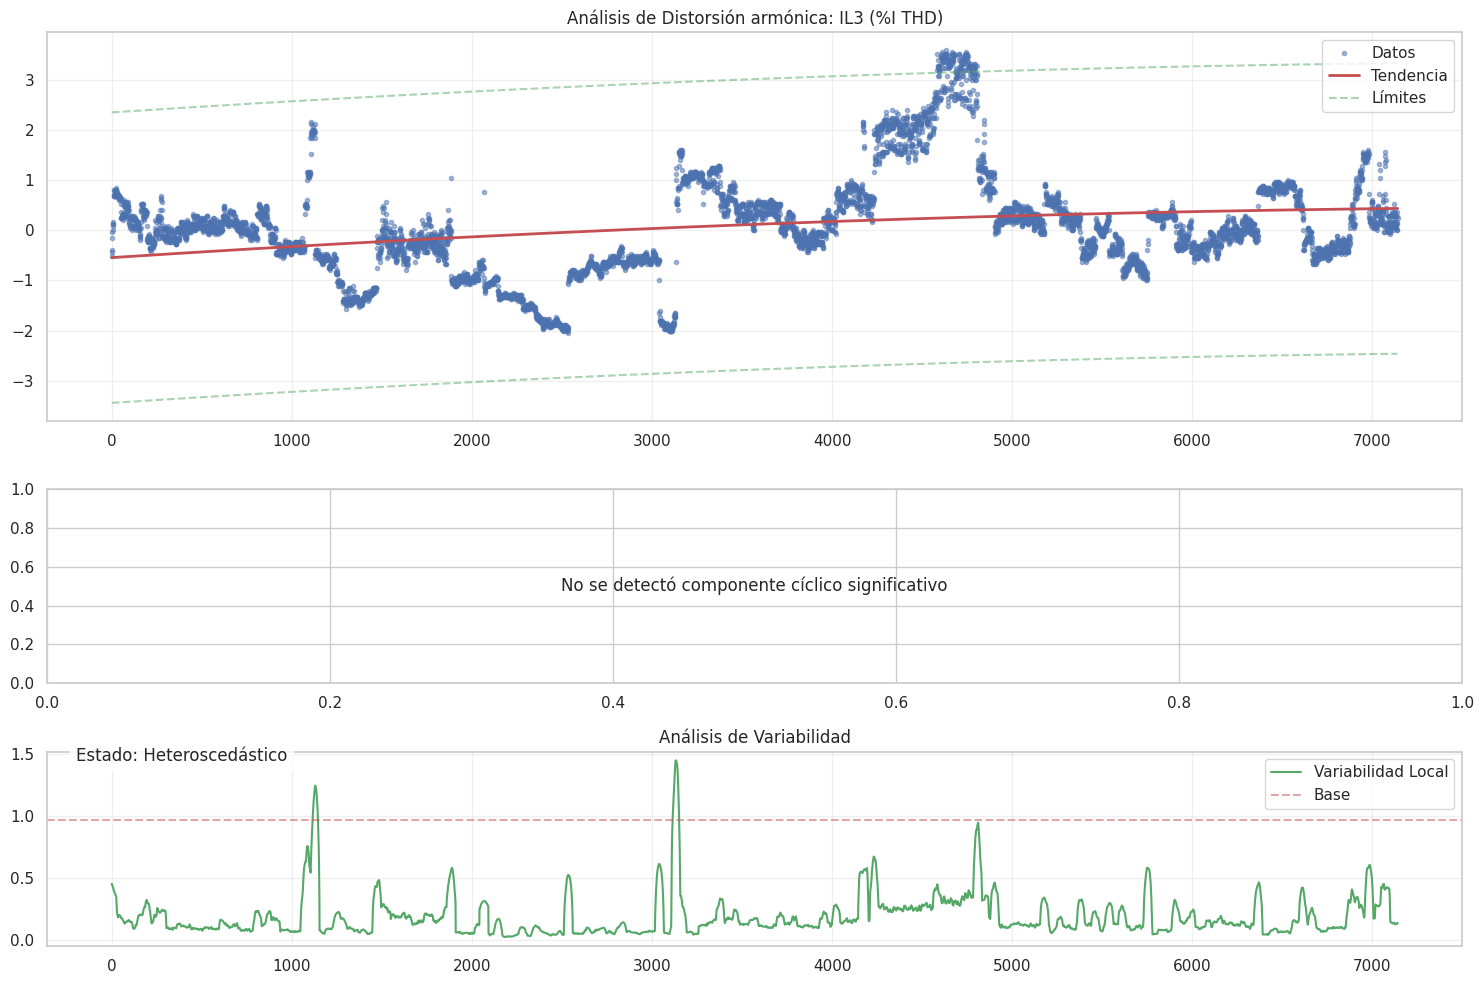


=== MÉTRICAS DE CALIDAD ===
Variable: Distorsión armónica: IL3 (%I THD)
Calidad general: 0.33
- Tendencia: 0.08
- Componente cíclico: 0.00
- Cobertura de límites: 0.98

Métricas del modelo:
- Calidad general: 0.33
- Calidad de tendencia: 0.08
- Calidad cíclica: 0.00
- Cobertura de límites: 0.98
--------------------------------------------------

Analizando Armónicos IL2: Armónico 7 (%IL2):


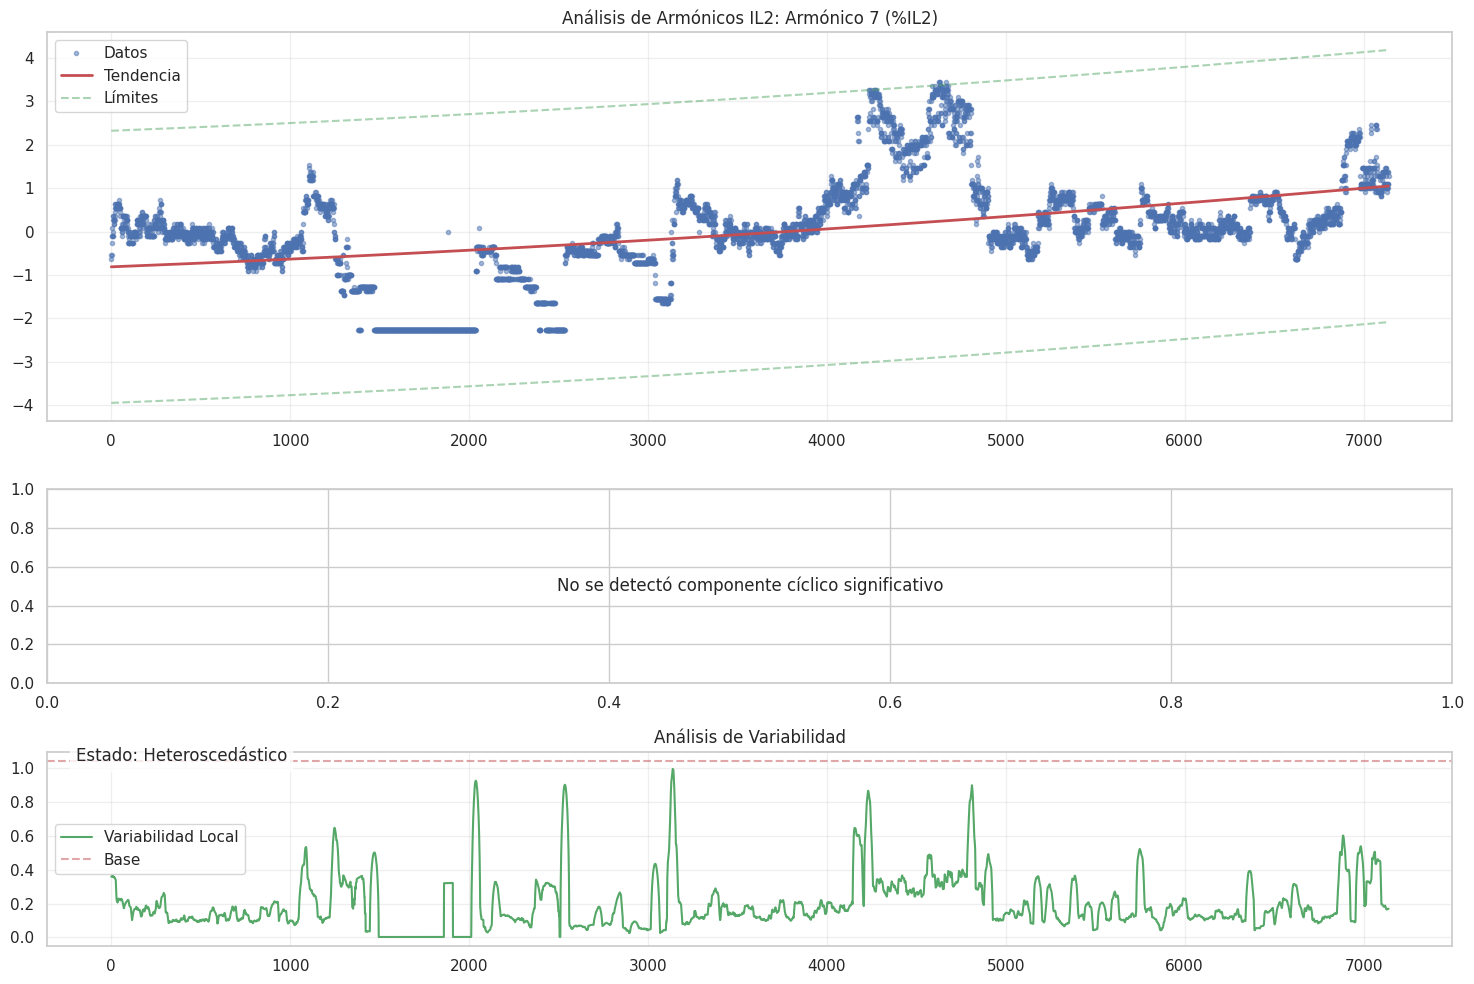


=== MÉTRICAS DE CALIDAD ===
Variable: Armónicos IL2: Armónico 7 (%IL2)
Calidad general: 0.38
- Tendencia: 0.21
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.38
- Calidad de tendencia: 0.21
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Armónicos VL1: Armónico 5 (%VL1):


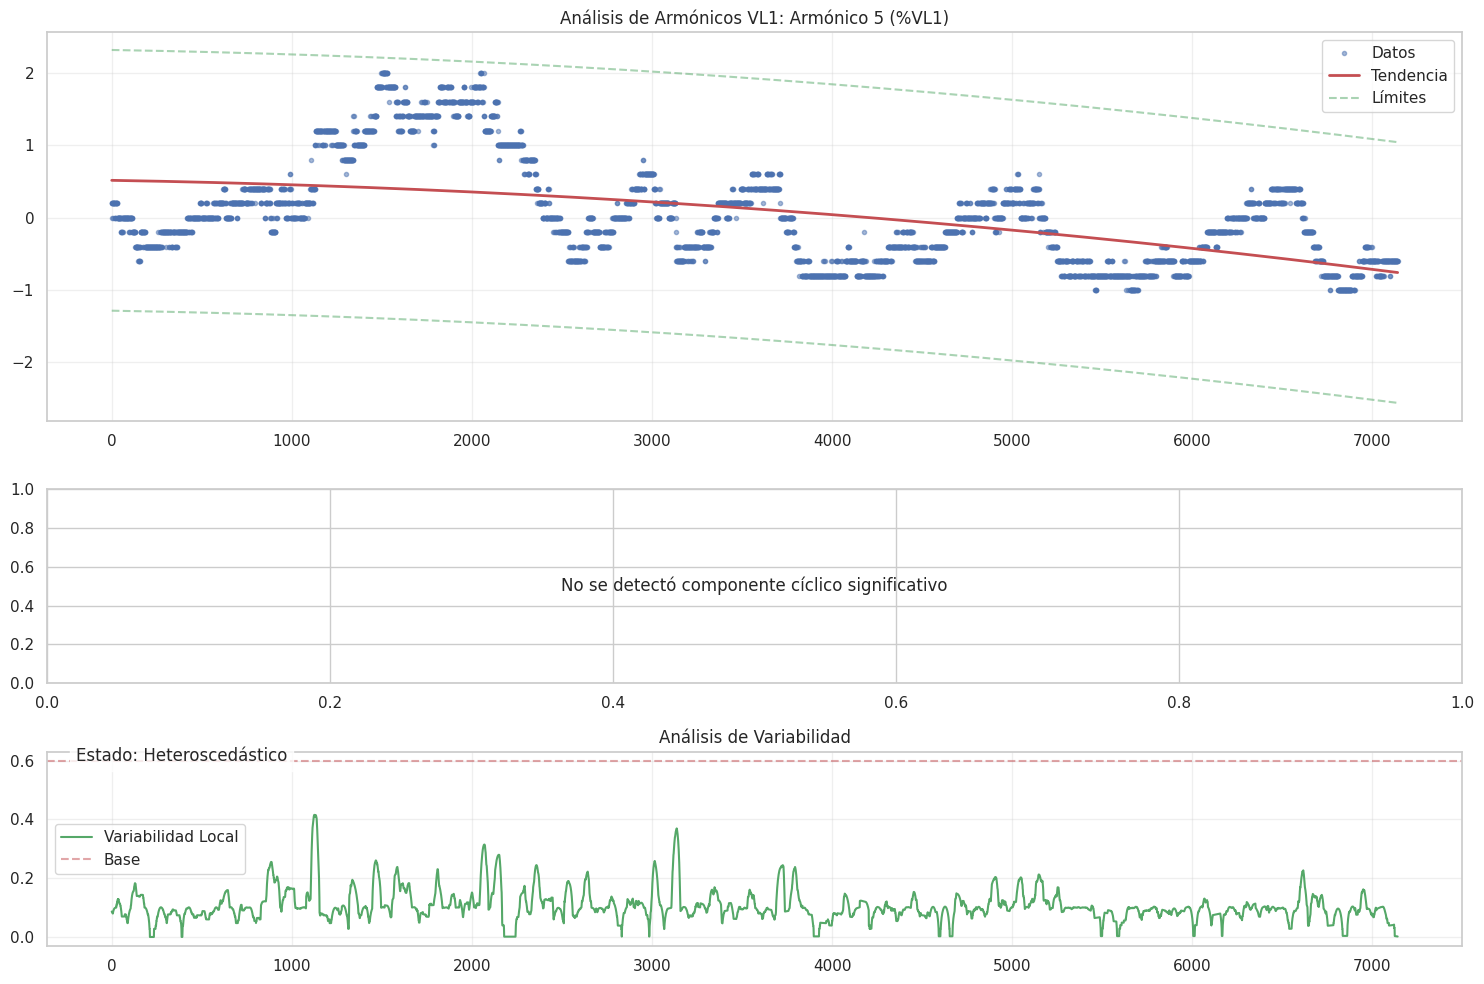


=== MÉTRICAS DE CALIDAD ===
Variable: Armónicos VL1: Armónico 5 (%VL1)
Calidad general: 0.41
- Tendencia: 0.28
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.41
- Calidad de tendencia: 0.28
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Distorsión armónica: IL2 (%I THD):


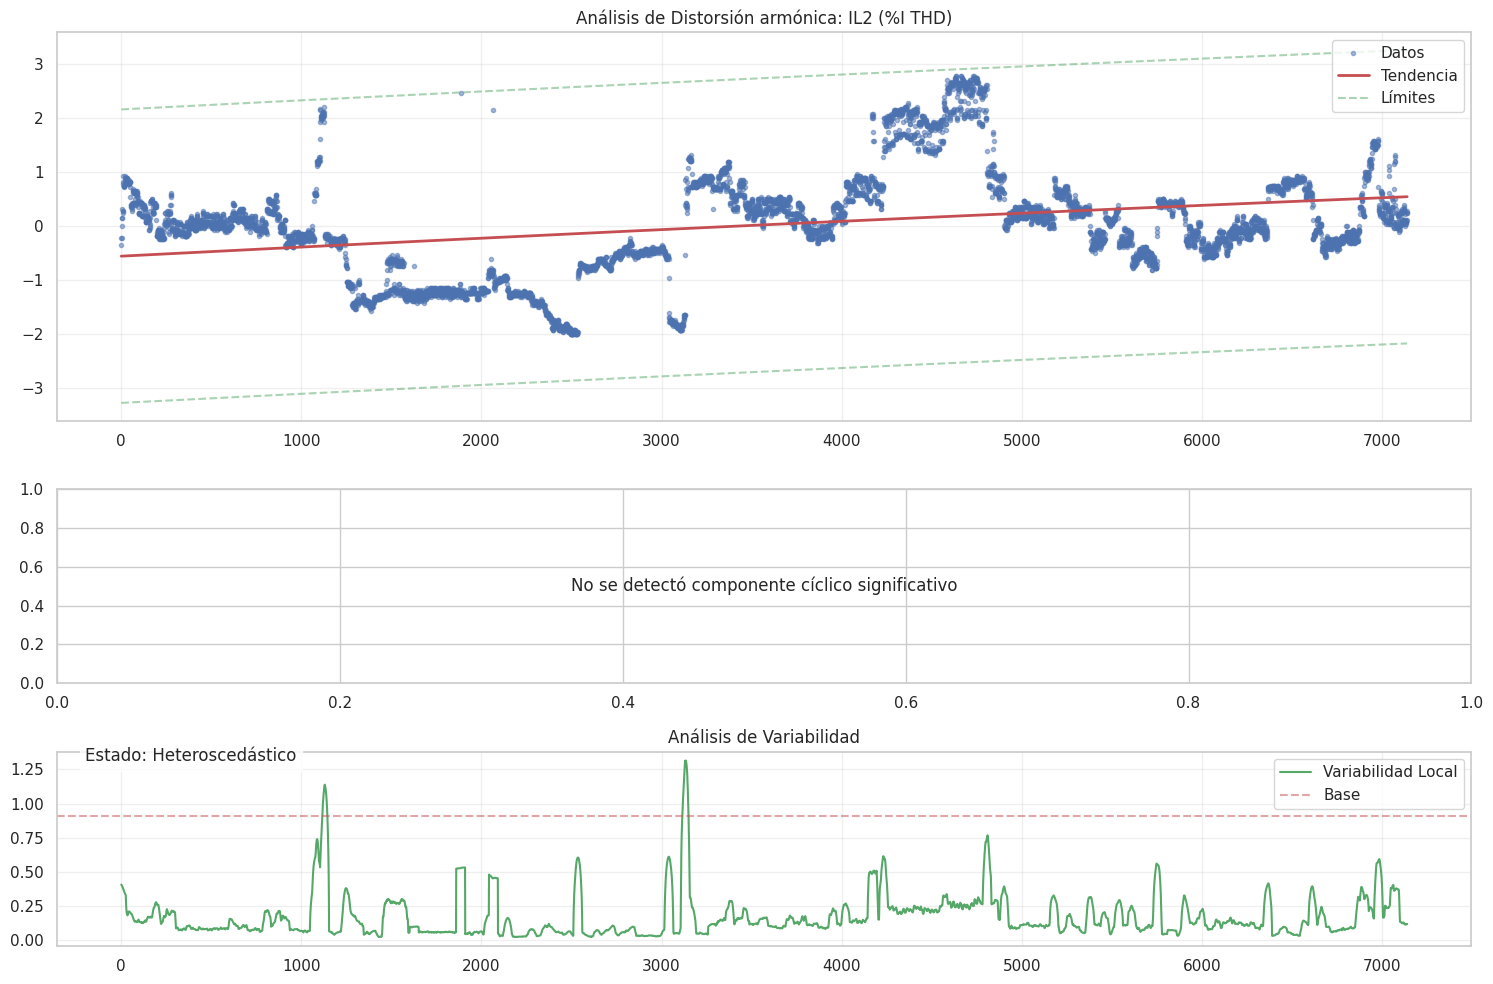


=== MÉTRICAS DE CALIDAD ===
Variable: Distorsión armónica: IL2 (%I THD)
Calidad general: 0.34
- Tendencia: 0.11
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.34
- Calidad de tendencia: 0.11
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Armónicos IL2: Armónico 3 (%IL2):


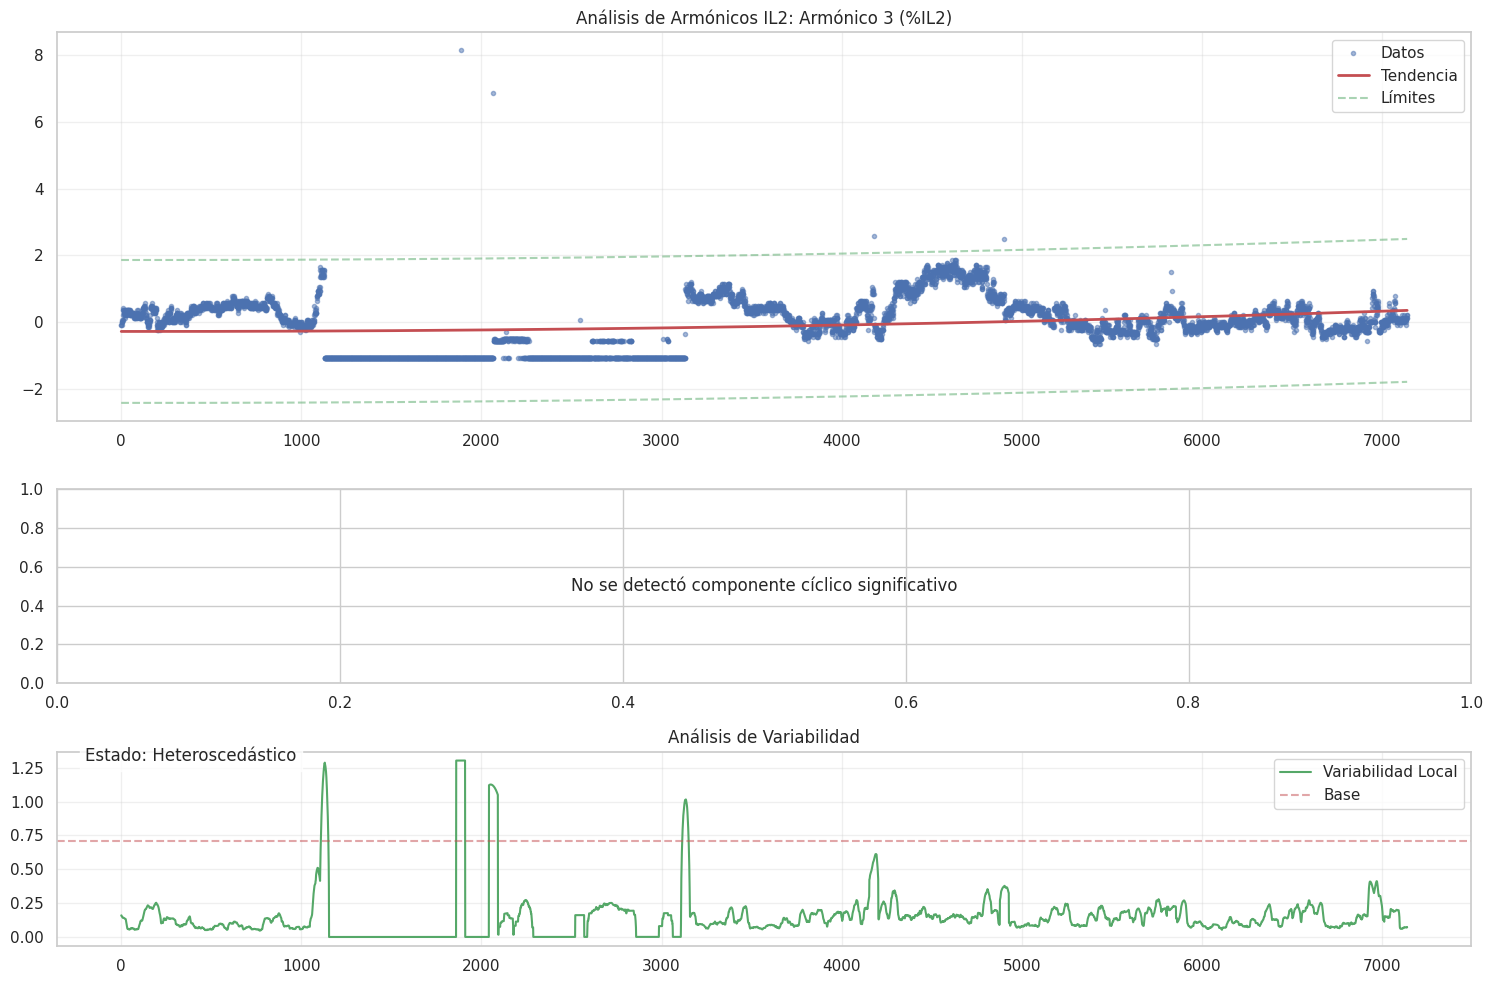


=== MÉTRICAS DE CALIDAD ===
Variable: Armónicos IL2: Armónico 3 (%IL2)
Calidad general: 0.33
- Tendencia: 0.06
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.33
- Calidad de tendencia: 0.06
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Armónicos VL1: Armónico 11 (%VL1):


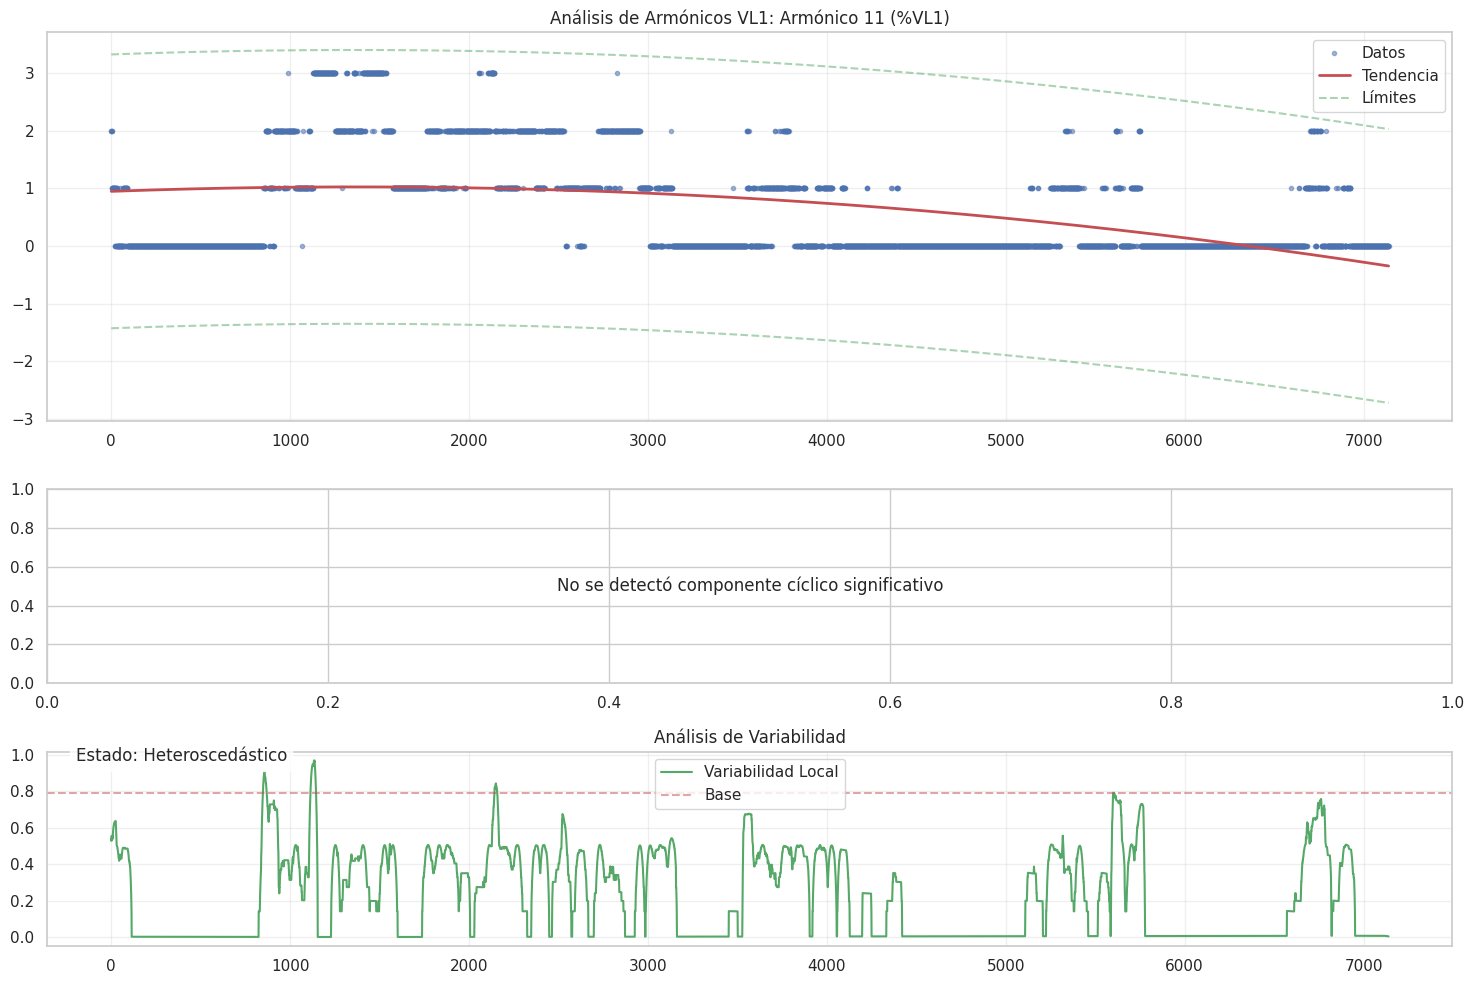


=== MÉTRICAS DE CALIDAD ===
Variable: Armónicos VL1: Armónico 11 (%VL1)
Calidad general: 0.38
- Tendencia: 0.21
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.38
- Calidad de tendencia: 0.21
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Armónicos IL2: Armónico 5 (%IL2):


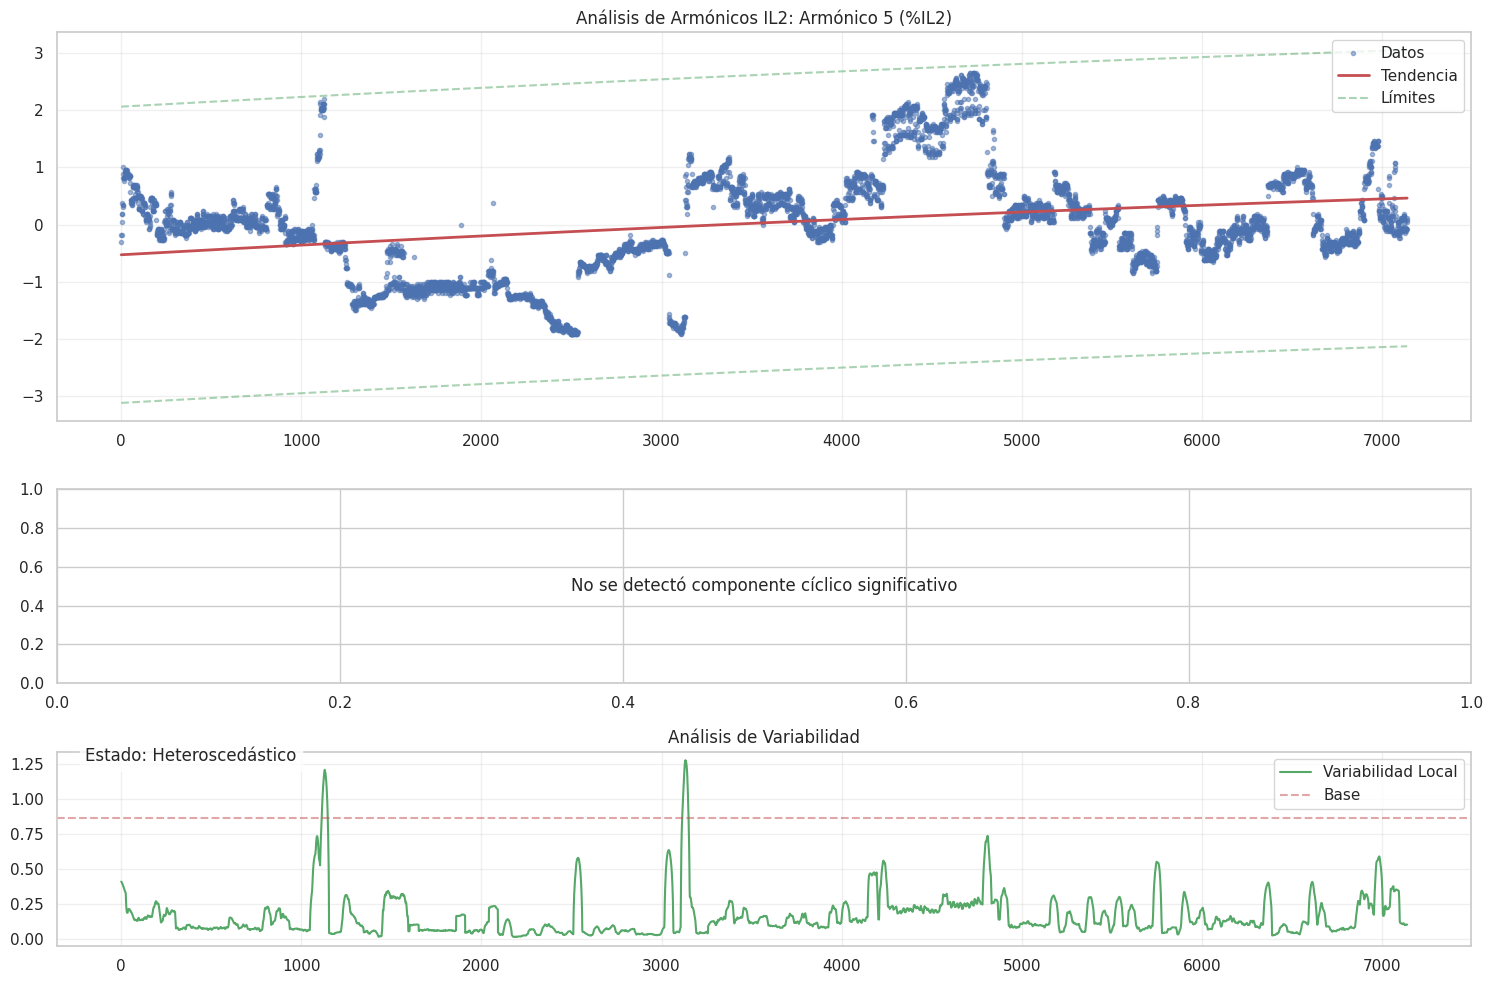


=== MÉTRICAS DE CALIDAD ===
Variable: Armónicos IL2: Armónico 5 (%IL2)
Calidad general: 0.34
- Tendencia: 0.10
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.34
- Calidad de tendencia: 0.10
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Corriente: L3 (A):


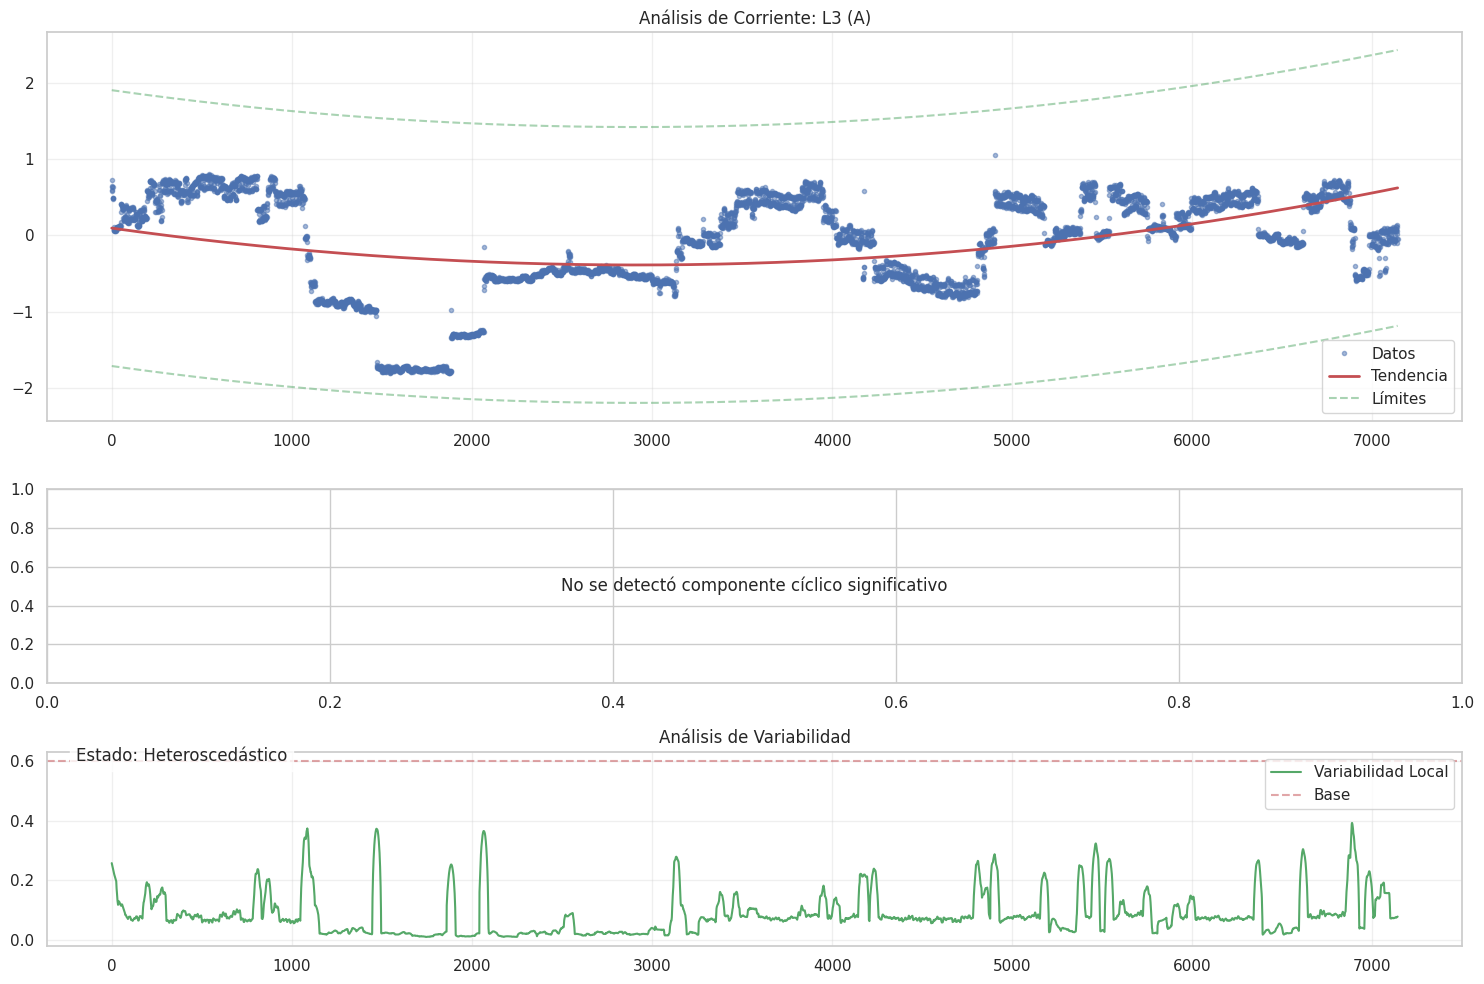


=== MÉTRICAS DE CALIDAD ===
Variable: Corriente: L3 (A)
Calidad general: 0.36
- Tendencia: 0.16
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.36
- Calidad de tendencia: 0.16
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

Analizando Corriente: L2 (A):


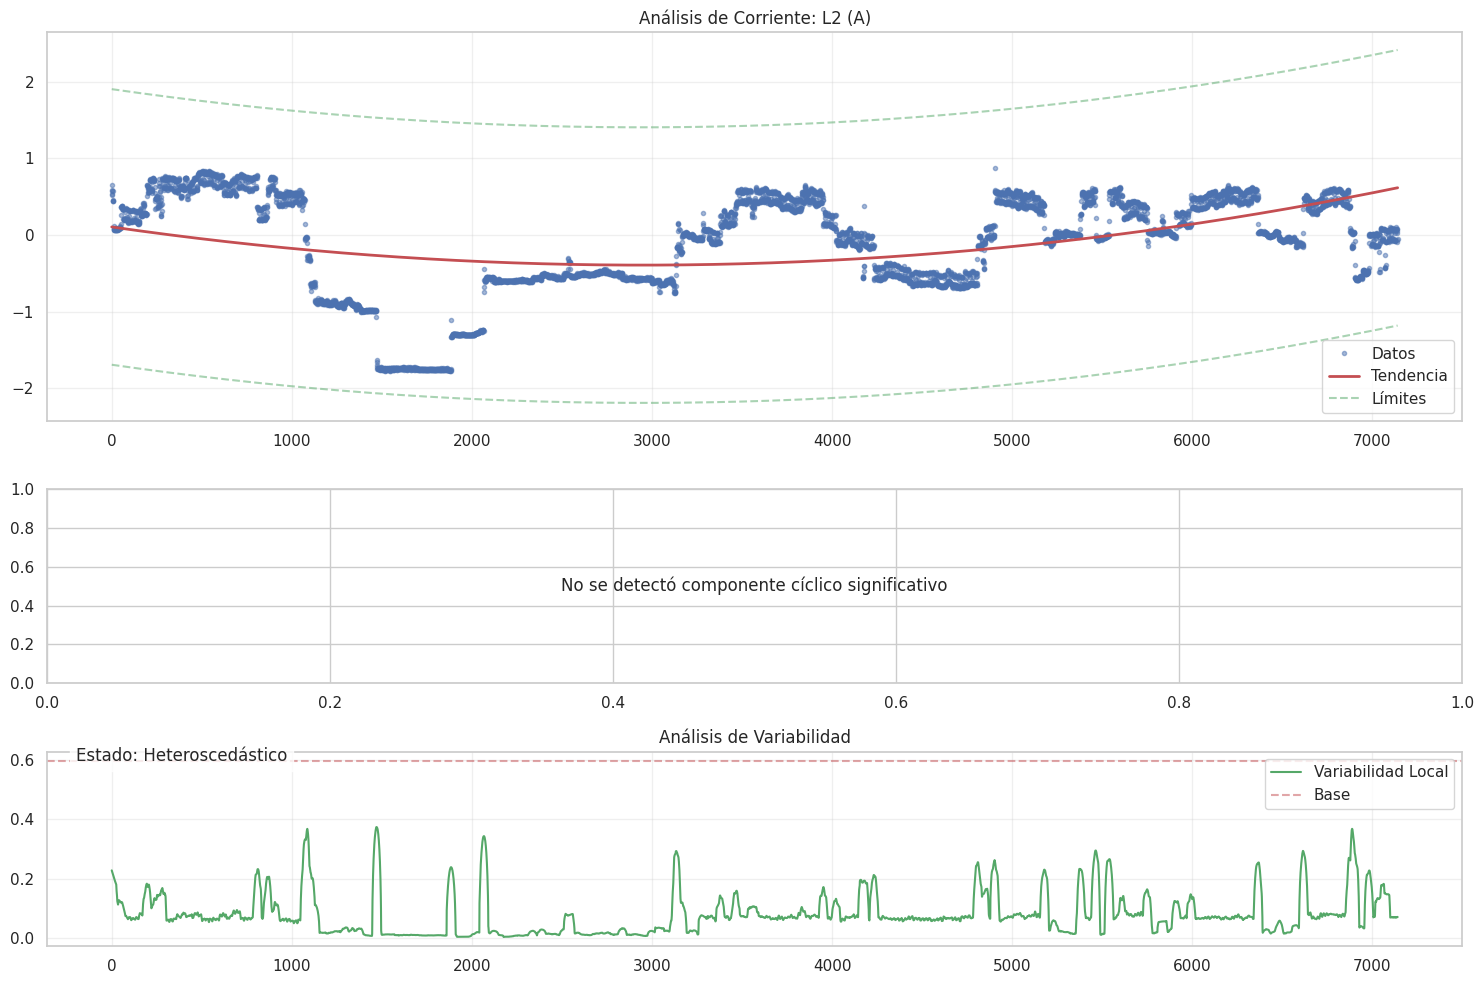


=== MÉTRICAS DE CALIDAD ===
Variable: Corriente: L2 (A)
Calidad general: 0.36
- Tendencia: 0.16
- Componente cíclico: 0.00
- Cobertura de límites: 1.00

Métricas del modelo:
- Calidad general: 0.36
- Calidad de tendencia: 0.16
- Calidad cíclica: 0.00
- Cobertura de límites: 1.00
--------------------------------------------------

RESUMEN CONSOLIDADO
Total variables analizadas: 15
Modelos exitosos: 15
Calidad promedio: 0.37

✓ Análisis completado exitosamente (15/15 modelos)


In [5]:
# CELDA 5: Pruebas del sistema
"""
Pruebas del sistema de prognosis
===============================
"""
def test_baseline_system():
    """Prueba exhaustiva del sistema de línea base."""
    try:
        print("\n" + "="*50)
        print("PRUEBA DEL SISTEMA DE LÍNEA BASE")
        print("="*50 + "\n")
        
        # 1. Validación de prerrequisitos
        if 'processed_data' not in globals() or 'critical_vars' not in globals():
            print("Error: Ejecutar primero el preprocesamiento y análisis de variables")
            return
            
        print("✓ Datos preprocesados disponibles")
        
        # 2. Verificación de datos
        if processed_data.empty:
            print("Error: Datos vacíos")
            return
            
        print(f"✓ Datos cargados: {processed_data.shape[0]} registros, {processed_data.shape[1]} variables")
        
        # 3. Validación de variables críticas
        if not critical_vars:
            print("Error: No se encontraron variables críticas")
            return
            
        print(f"\nVariables críticas identificadas ({len(critical_vars)}):")
        for var in critical_vars:
            print(f"- {var}")
            
        # 4. Validación de calidad de datos
        print("\nValidando calidad de datos...")
        valid_vars = []
        for var in critical_vars:
            missing = processed_data[var].isna().sum()
            missing_pct = missing / len(processed_data)
            if missing_pct > 0.3:
                print(f"⚠ {var}: {missing_pct:.1%} valores faltantes")
            else:
                valid_vars.append(var)
                print(f"✓ {var}: {missing_pct:.1%} valores faltantes")
                
        if not valid_vars:
            print("\nError: No hay variables válidas para análisis")
            return
            
        print(f"\n{len(valid_vars)} variables válidas para análisis")
        
        # 5. Análisis de línea base
        print("\nIniciando análisis de línea base...")
        learner = BaselineLearner()
        results = learner.learn_baseline(processed_data, valid_vars)
        
        if not results:
            print("Error: Fallo en el análisis de línea base")
            return None
            
        # 6. Análisis de resultados
        successful_models = len(results['baseline_models'])
        print(f"\nModelos generados: {successful_models}/{len(valid_vars)}")
        
        # 7. Visualización de resultados
        print("\nGenerando visualizaciones...")
        for var in valid_vars:
            if var in results['baseline_models']:
                print(f"\nAnalizando {var}:")
                learner.visualize_results(var)
                
                # Mostrar detalles del modelo
                if var in results['quality_metrics']:
                    metrics = results['quality_metrics'][var]
                    print("\nMétricas del modelo:")
                    print(f"- Calidad general: {metrics['overall_quality']:.2f}")
                    print(f"- Calidad de tendencia: {metrics['trend_quality']:.2f}")
                    print(f"- Calidad cíclica: {metrics['cyclic_quality']:.2f}")
                    print(f"- Cobertura de límites: {metrics['limits_coverage']:.2f}")
                
                print("-"*50)
        
        # 8. Resumen consolidado
        print("\nRESUMEN CONSOLIDADO")
        print("="*30)
        print(f"Total variables analizadas: {len(valid_vars)}")
        print(f"Modelos exitosos: {successful_models}")
        
        # Calcular métricas promedio
        if results['quality_metrics']:
            avg_quality = np.mean([m['overall_quality'] for m in results['quality_metrics'].values()])
            print(f"Calidad promedio: {avg_quality:.2f}")
        
        # 9. Validación final
        if successful_models / len(valid_vars) < 0.5:
            print("\n⚠ Advertencia: Menos del 50% de los modelos fueron exitosos")
        else:
            print(f"\n✓ Análisis completado exitosamente ({successful_models}/{len(valid_vars)} modelos)")
        
        return results
        
    except Exception as e:
        print(f"\nError crítico en pruebas: {str(e)}")
        return None

# Ejecutar pruebas
print("\nIniciando sistema de prognosis...")
baseline_results = test_baseline_system()

2024-12-20 17:33:03,977 - INFO - Iniciando detección de anomalías
2024-12-20 17:33:03,995 - INFO - Analizando Factor de potencia: L2 +
2024-12-20 17:33:04,009 - INFO - Factor de potencia: L2 +: Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,010 - INFO - Analizando Factor de potencia: L1 +
2024-12-20 17:33:04,032 - INFO - Factor de potencia: L1 +: Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,034 - INFO - Analizando Corriente: L1 (A)
2024-12-20 17:33:04,050 - INFO - Corriente: L1 (A): Análisis completado (Severidad: ALTA)
2024-12-20 17:33:04,053 - INFO - Analizando Armónicos VL3: Armónico 5 (%VL3)
2024-12-20 17:33:04,065 - INFO - Armónicos VL3: Armónico 5 (%VL3): Análisis completado (Severidad: ALTA)
2024-12-20 17:33:04,110 - INFO - Analizando Factor de potencia: L3 +
2024-12-20 17:33:04,148 - INFO - Factor de potencia: L3 +: Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,158 - INFO - Analizando Armónicos VL2: Armónico 5 (%VL2)



Iniciando pruebas del detector...

PRUEBA DEL DETECTOR DE ANOMALÍAS
✓ Detector configurado correctamente


2024-12-20 17:33:04,212 - INFO - Armónicos VL2: Armónico 5 (%VL2): Análisis completado (Severidad: ALTA)
2024-12-20 17:33:04,215 - INFO - Analizando Distorsión armónica: IL3 (%I THD)


2024-12-20 17:33:04,228 - INFO - Distorsión armónica: IL3 (%I THD): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,229 - INFO - Analizando Armónicos IL2: Armónico 7 (%IL2)
2024-12-20 17:33:04,244 - INFO - Armónicos IL2: Armónico 7 (%IL2): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,246 - INFO - Analizando Armónicos VL1: Armónico 5 (%VL1)
2024-12-20 17:33:04,260 - INFO - Armónicos VL1: Armónico 5 (%VL1): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,262 - INFO - Analizando Distorsión armónica: IL2 (%I THD)
2024-12-20 17:33:04,276 - INFO - Distorsión armónica: IL2 (%I THD): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,279 - INFO - Analizando Armónicos IL2: Armónico 3 (%IL2)
2024-12-20 17:33:04,291 - INFO - Armónicos IL2: Armónico 3 (%IL2): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:04,293 - INFO - Analizando Armónicos VL1: Armónico 11 (%VL1)
2024-12-20 17:33:04,305 - INFO - Armónicos VL1: Armónico 11 (%VL1): Aná


Analizando Factor de potencia: L2 +:


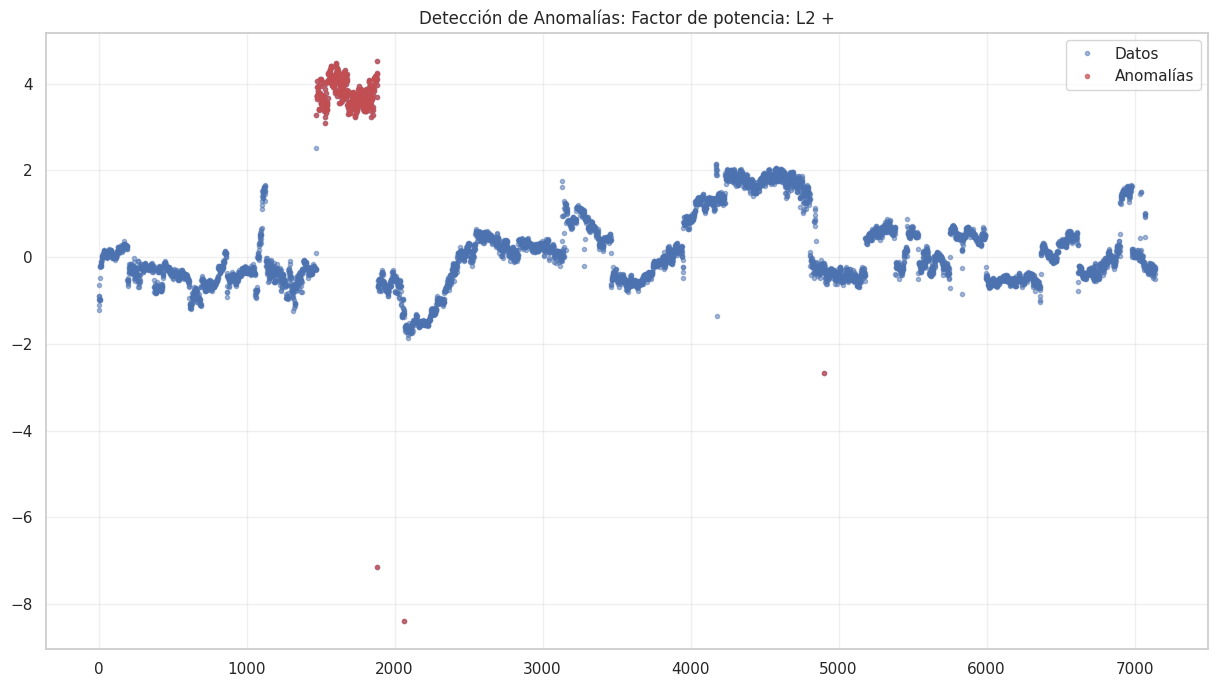


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 1.00)

Analizando Factor de potencia: L1 +:


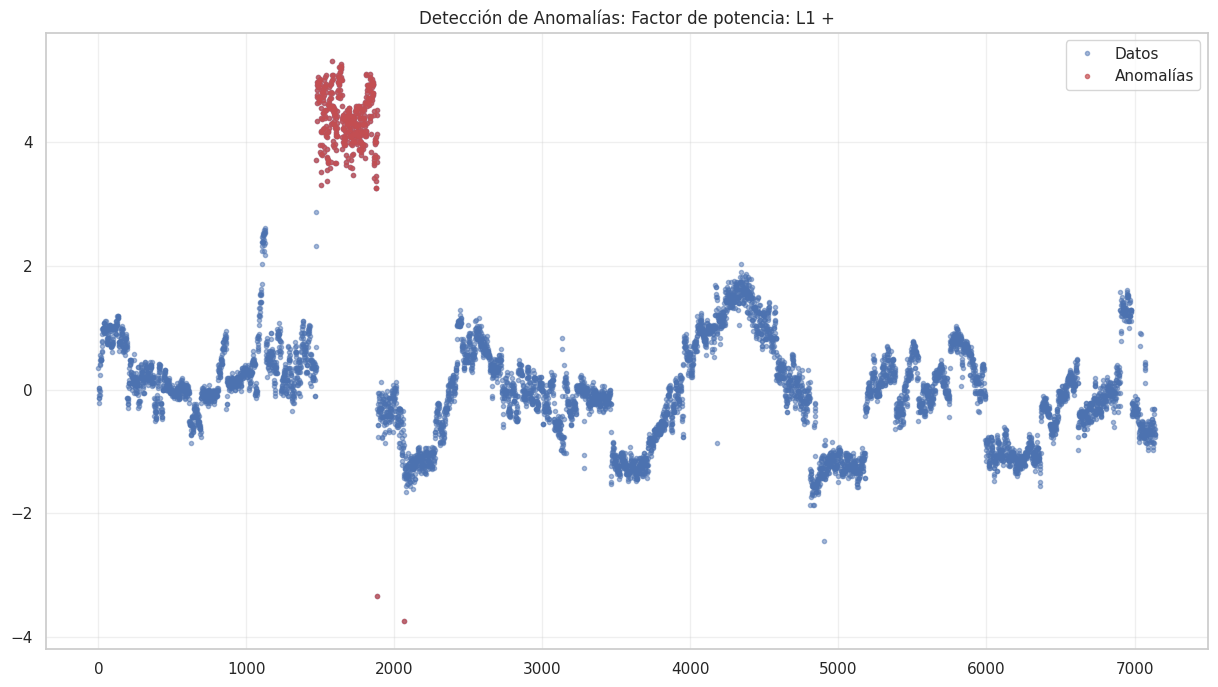


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 412, score: 1.00)

Analizando Corriente: L1 (A):


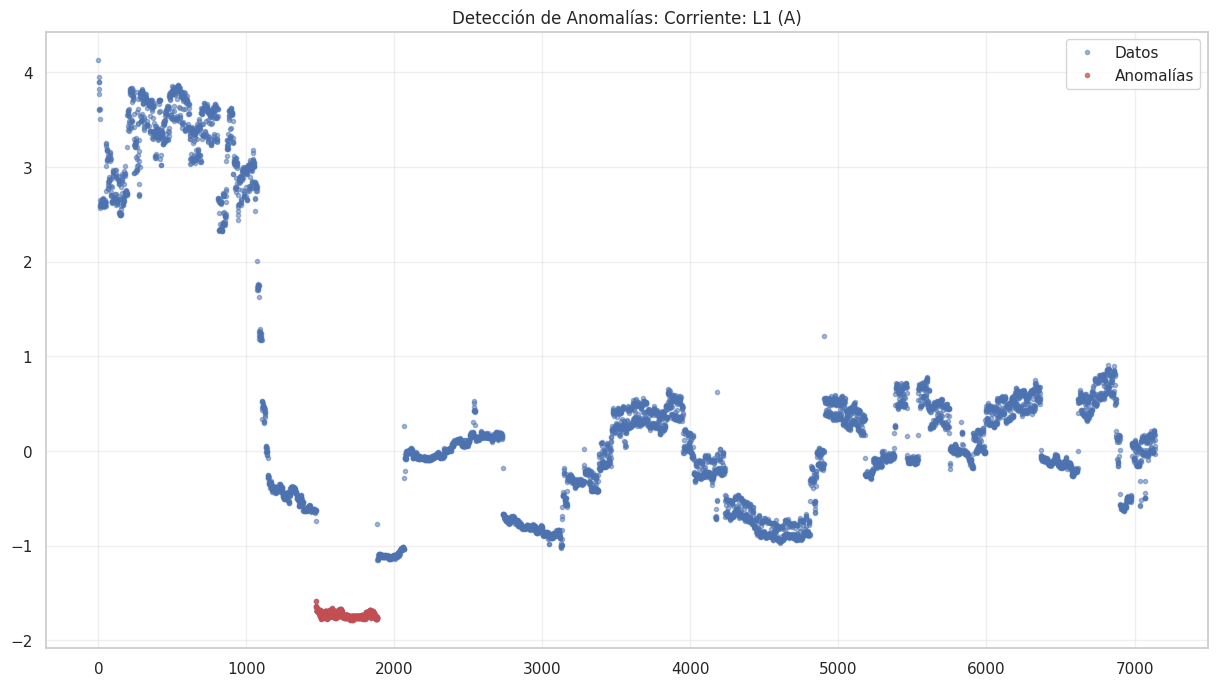


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 0.88)

Analizando Armónicos VL3: Armónico 5 (%VL3):


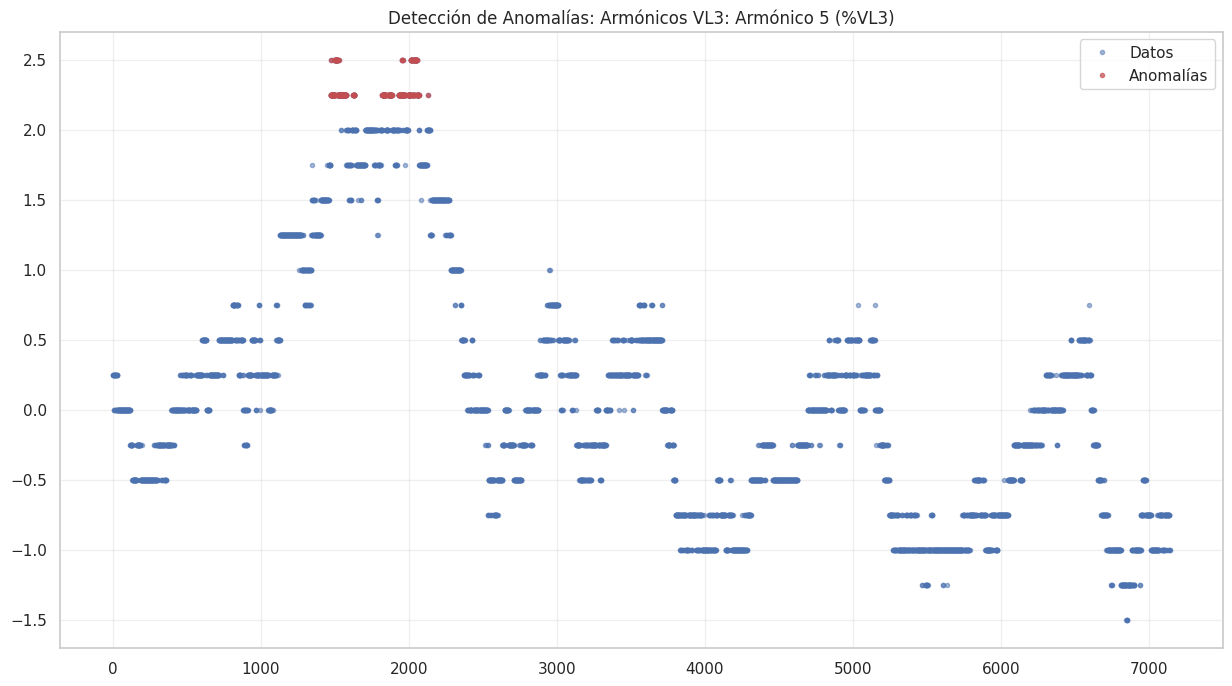


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 69, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 19, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 72, score: 0.90)

Analizando Factor de potencia: L3 +:


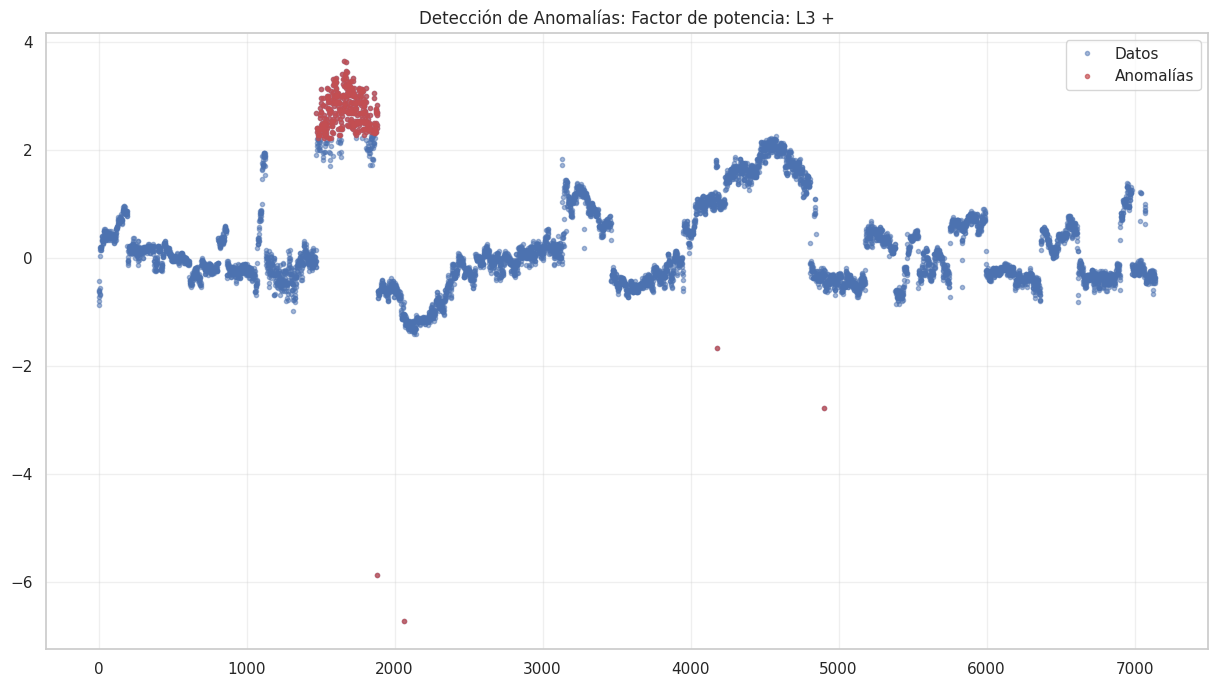


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 3, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 15, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 8, score: 0.97)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 6, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 8, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 8, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 4, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 11, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 37, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.86)
- [ALTA] Racha anómala detectada (duración: 95, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 44, score: 1.00)
- [ALTA] Racha anómala detectada (d

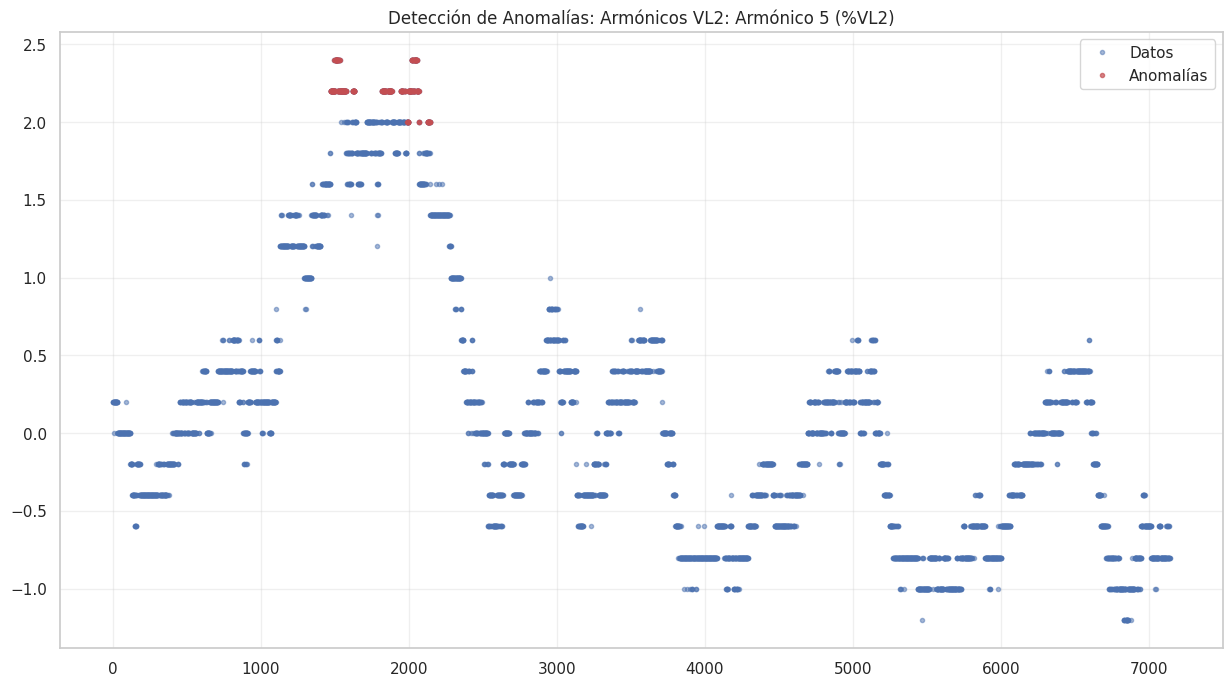


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 69, score: 0.86)
- [ALTA] Racha anómala detectada (duración: 78, score: 0.89)

Analizando Distorsión armónica: IL3 (%I THD):


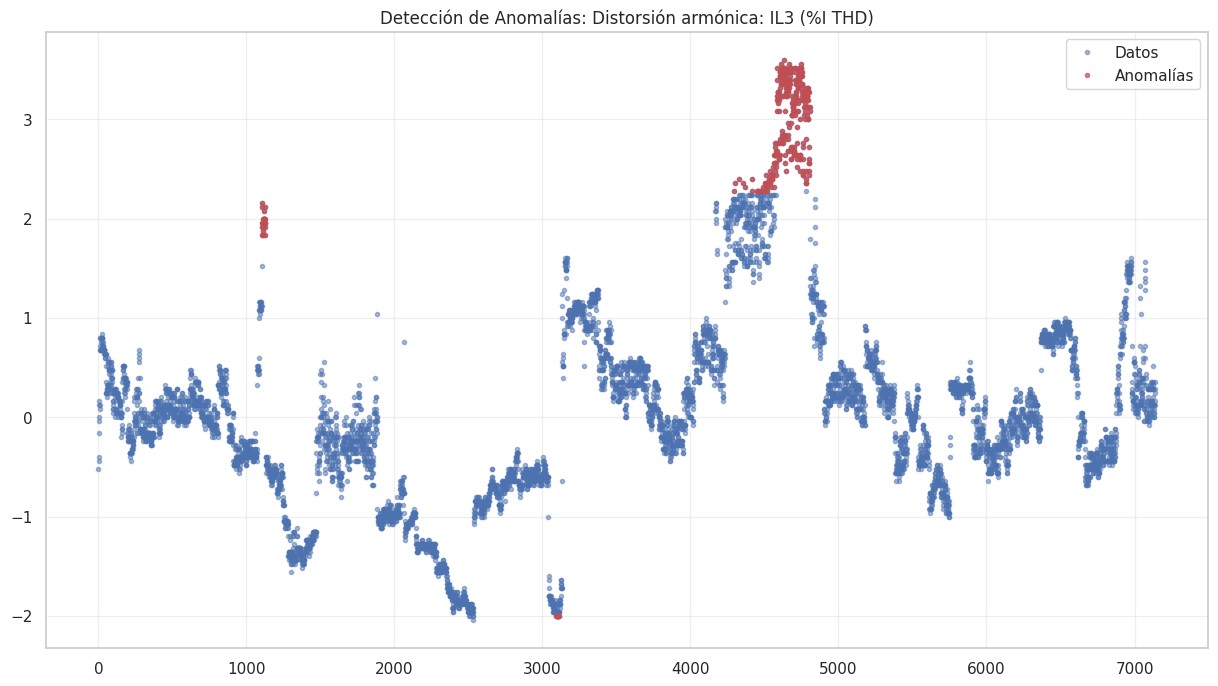


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 24, score: 0.85)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 201, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 25, score: 1.00)

Analizando Armónicos IL2: Armónico 7 (%IL2):


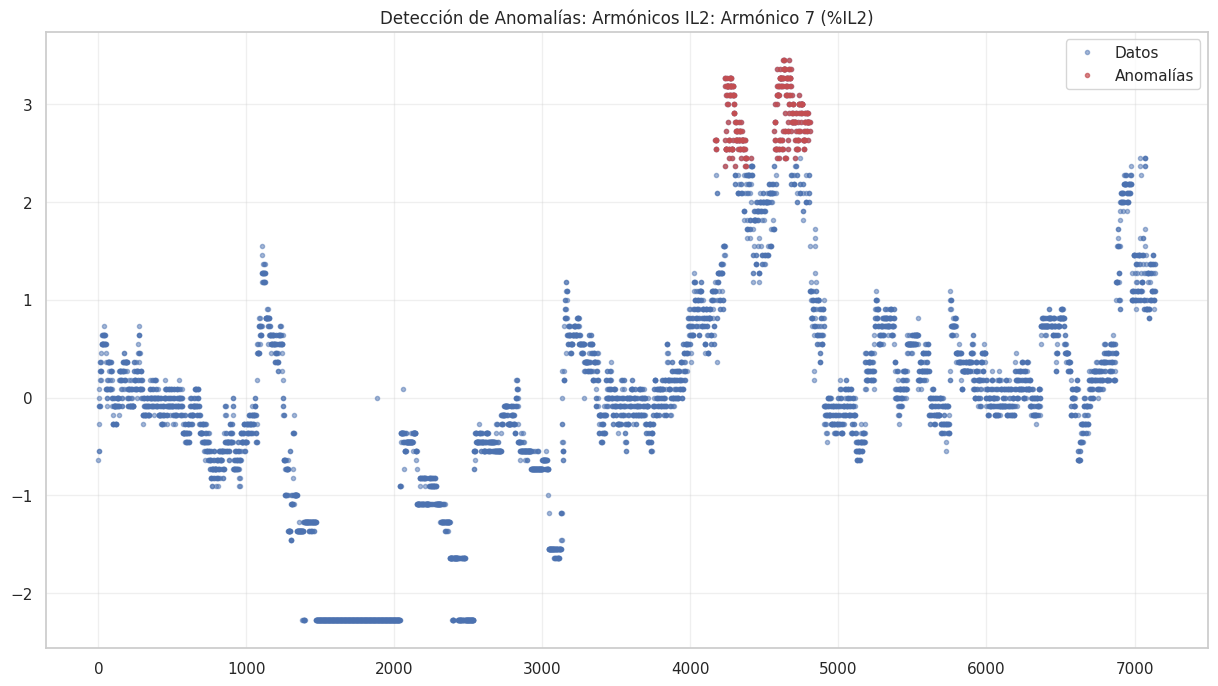


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 6, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 68, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.85)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.85)
- [ALTA] Racha anómala detectada (duración: 13, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 11, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 97, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.81)

Analizando Armónicos VL1: Ar

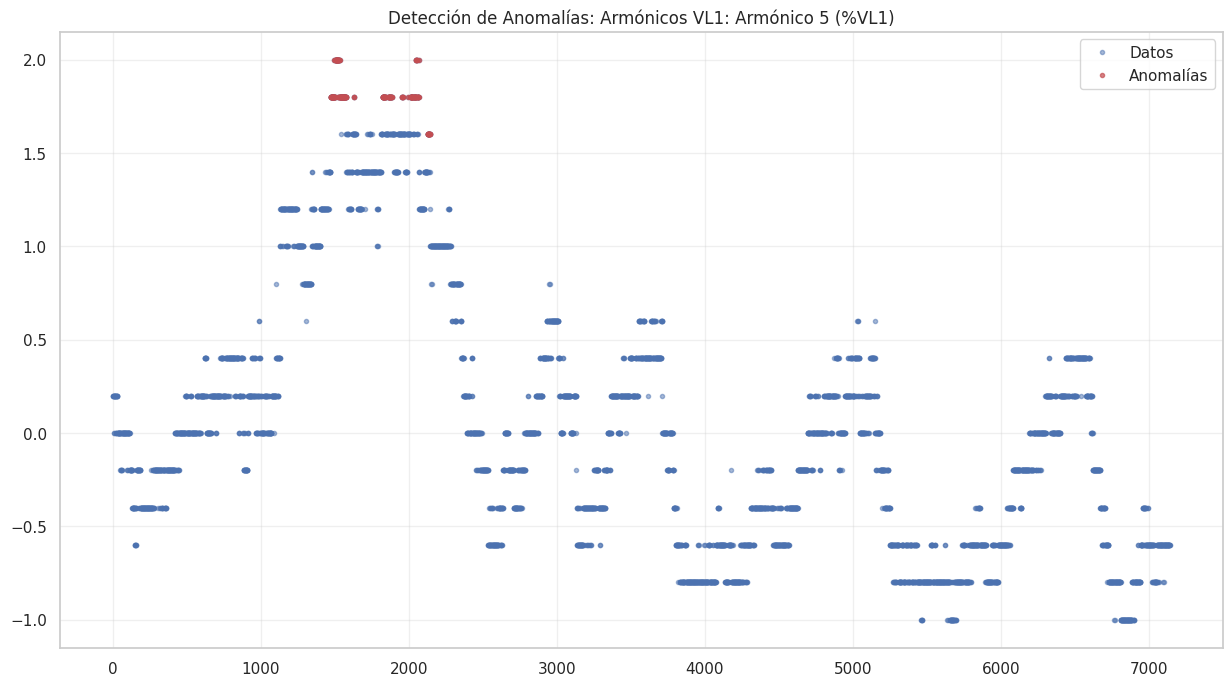


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 69, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 5, score: 0.80)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.80)
- [ALTA] Racha anómala detectada (duración: 19, score: 0.92)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.92)

Analizando Distorsión armónica: IL2 (%I THD):


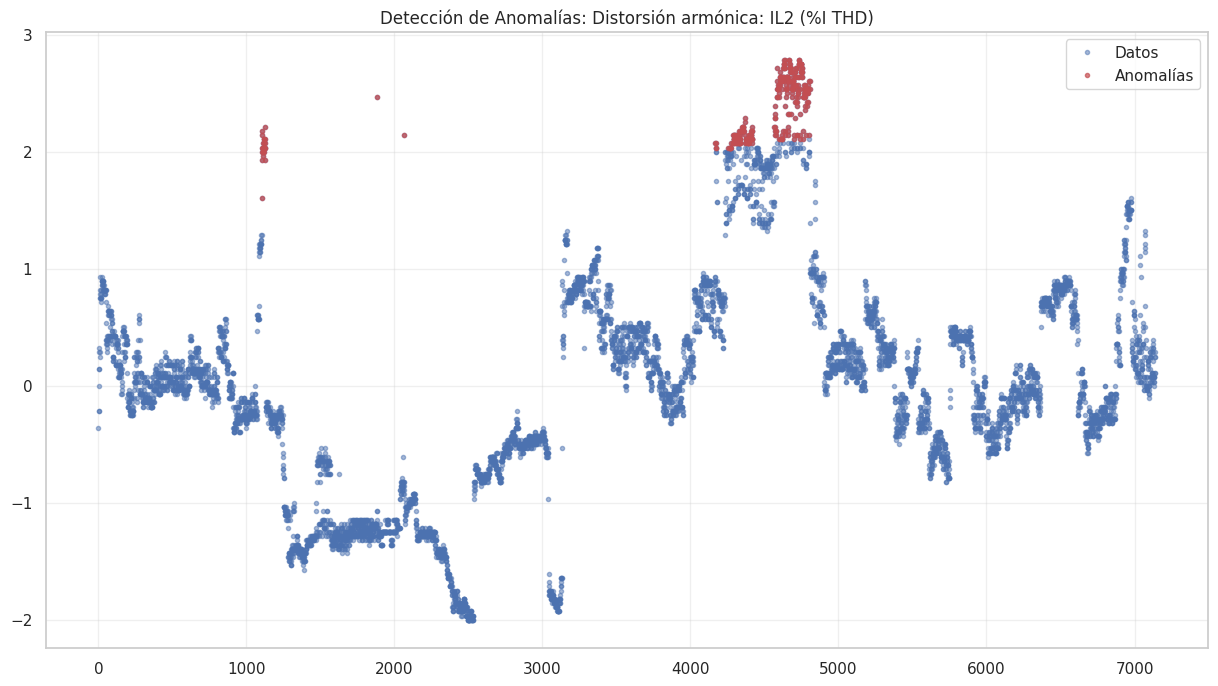


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 26, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 11, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.93)
- [ALTA] Racha anómala detectada (duración: 19, score: 0.92)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.96)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.93)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.88)

Analizando Armónicos IL2: Armónico 3 (%IL2):


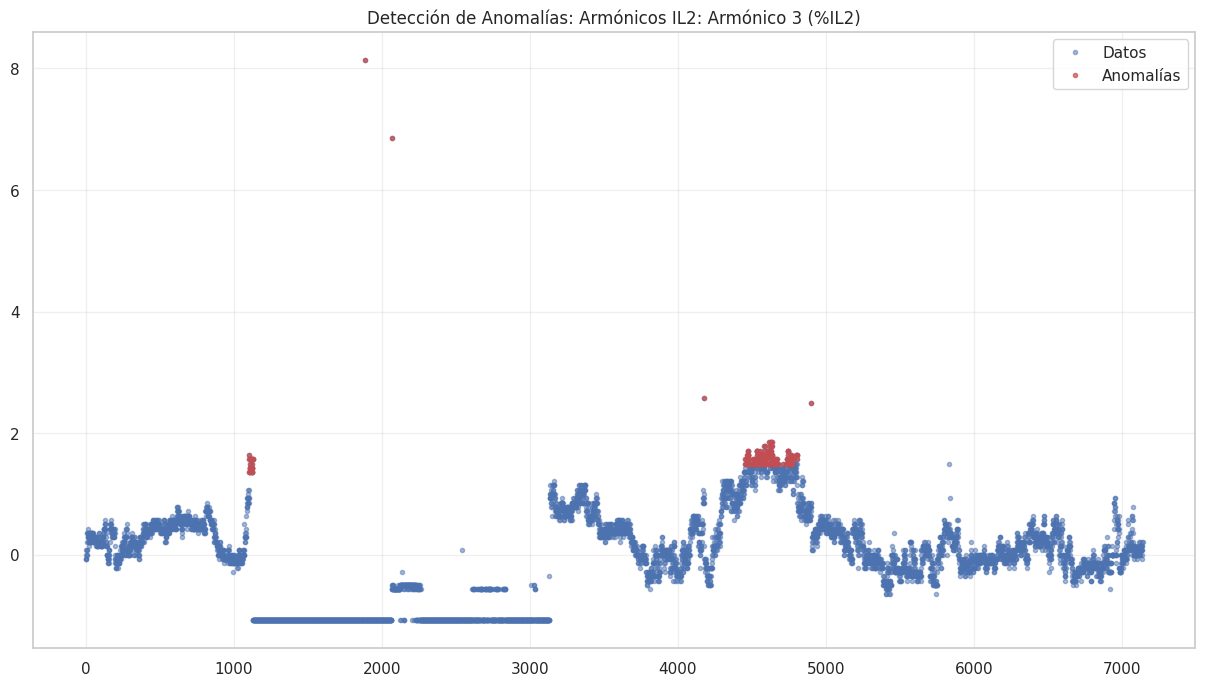


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 24, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 13, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 11, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 8, score: 0.80)

Analizando Armónicos VL1: Armónico 11 (%VL1):


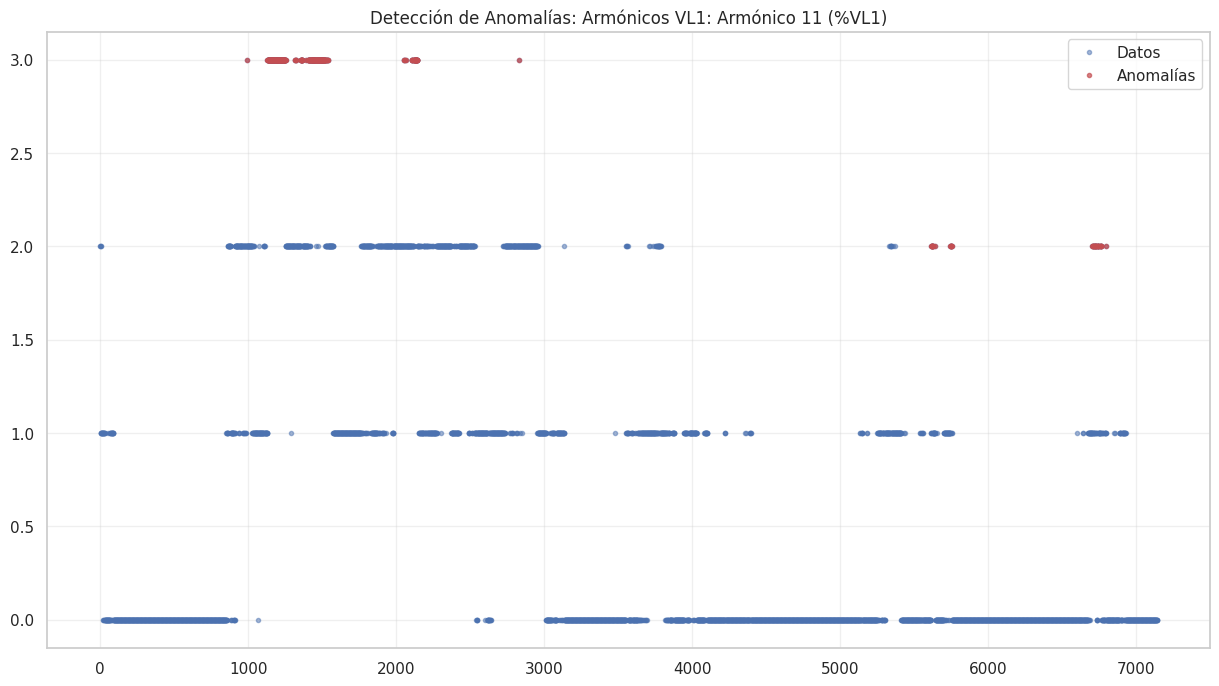


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 124, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 5, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 5, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 10, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 36, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 47, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 24, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.91)
- [ALTA] Racha anómala detectada 

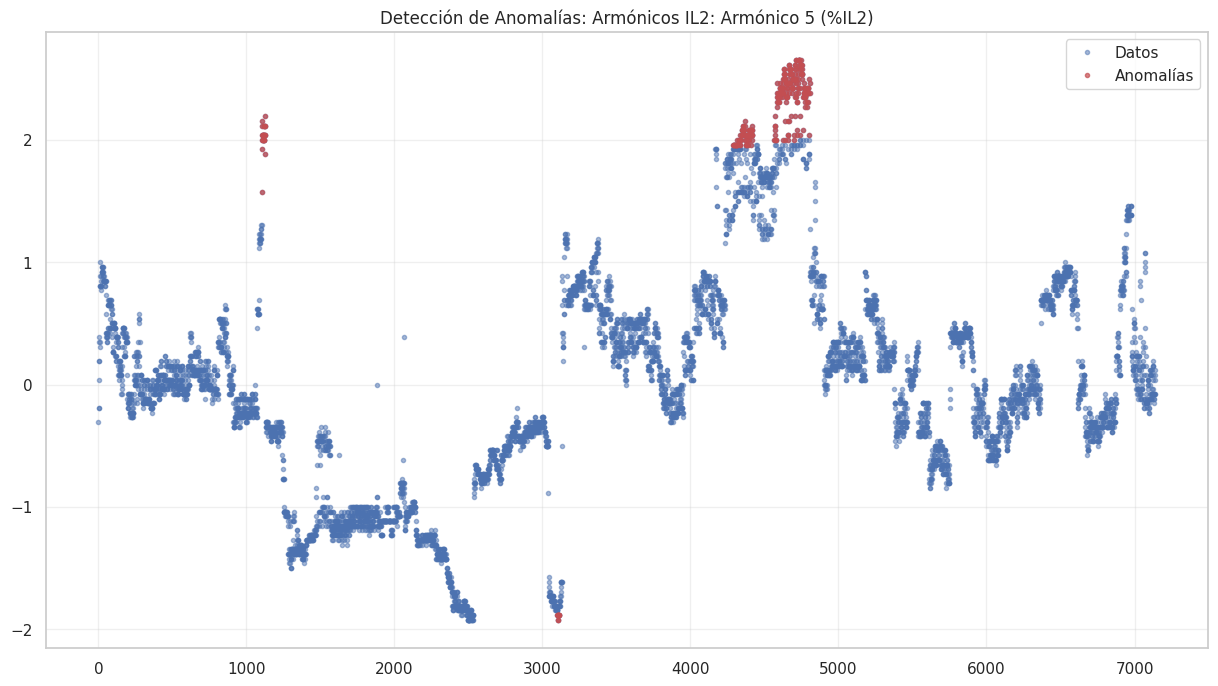


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 26, score: 0.98)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.93)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.86)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.89)

Analizando Corriente: L3 (A):


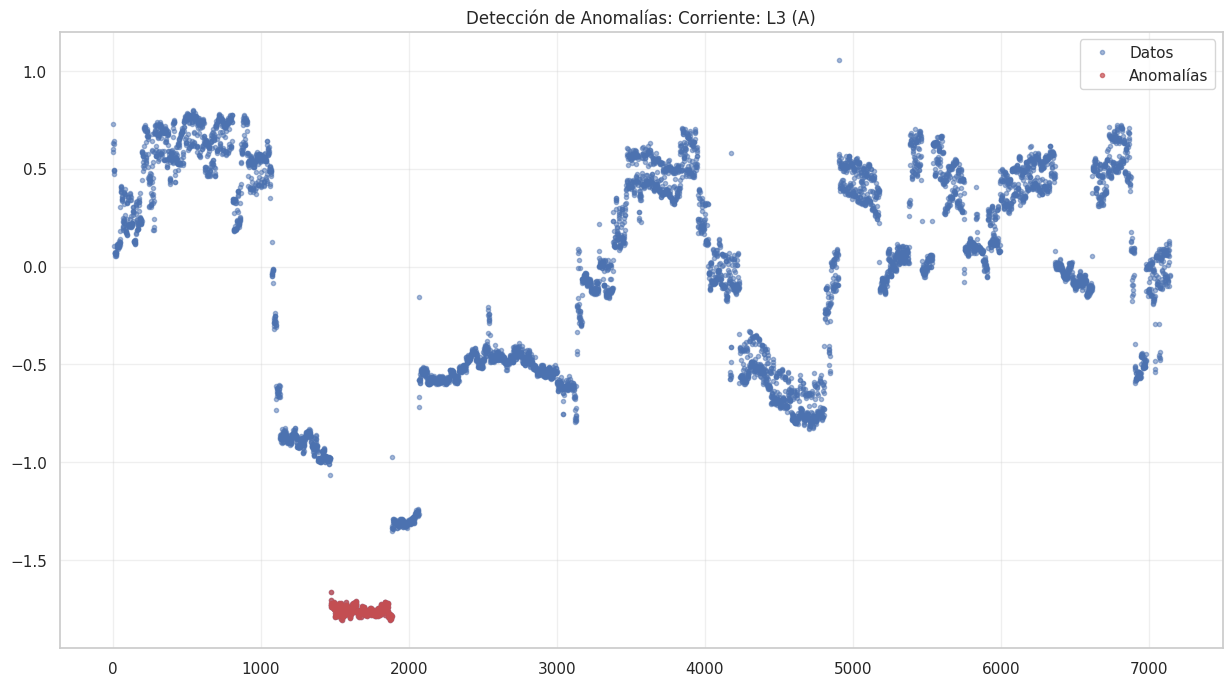


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 0.84)

Analizando Corriente: L2 (A):


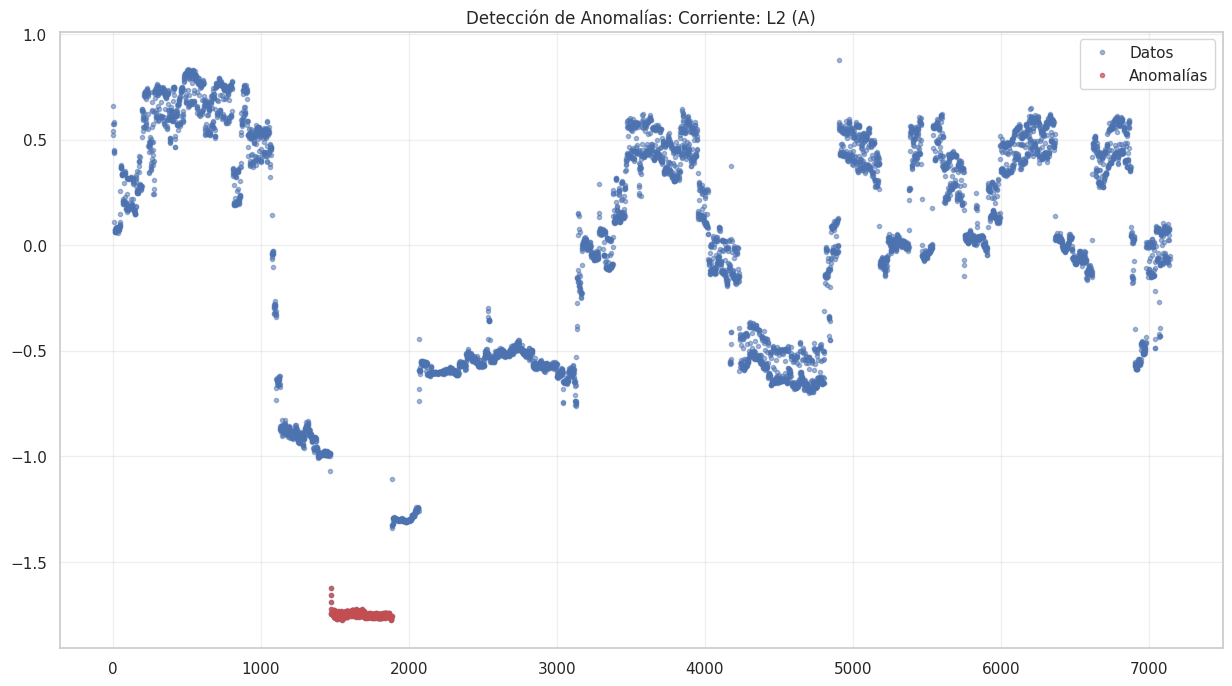


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 0.83)


In [6]:
# CELDA 6: Fase 4 - Detección de Anomalías
"""
Fase 4: Detección de Anomalías
=============================

Objetivo: Implementar el sistema de detección de anomalías mediante:
1. Análisis de desviaciones
2. Detección de patrones anómalos
3. Generación de alertas
"""

class AnomalyDetector:
    """Sistema de detección de anomalías."""
    
    def __init__(self, baseline_learner: BaselineLearner):
        """
        Inicializa el detector de anomalías.
        
        Args:
            baseline_learner: Sistema de línea base entrenado
        """
        self._setup_logging()
        self.baseline = baseline_learner
        self.results = {'anomalies': {}}
        self._initialize_thresholds()
        
    def _setup_logging(self):
        """Configura el sistema de logging."""
        self.logger = logging.getLogger(__name__)
        
    def _initialize_thresholds(self):
        """Inicializa umbrales de detección."""
        self.thresholds = {
            'anomaly': 0.7,
            'severity': {
                'CRÍTICA': 0.9,
                'ALTA': 0.8,
                'MEDIA': 0.6,
                'BAJA': 0.4
            }
        }
        self.config = {
            'window_size': 48,
            'min_streak': 3,
            'seasonality_periods': [24, 48, 168]  # Diario, 2-días, Semanal
        }

    def _calculate_anomaly_scores(self, series: pd.Series, model: Dict[str, Any]) -> np.ndarray:
        """
        Calcula los scores de anomalía para una serie temporal.
        
        Args:
            series: Serie temporal a analizar
            model: Modelo base ajustado
            
        Returns:
            Array con scores de anomalía
        """
        try:
            # 1. Desviación de tendencia
            trend = np.array(model['trend']['values'])
            trend_dev = np.abs(series - trend) / model['variability']['base_std']
            
            # 2. Violación de límites
            limits = self.baseline.results['adaptive_limits'][series.name]
            upper_violation = np.maximum(0, series - np.array(limits['upper']))
            lower_violation = np.maximum(0, np.array(limits['lower']) - series)
            limit_violation = (upper_violation + lower_violation) / limits['std']
            
            # 3. Variabilidad local
            rolling_std = pd.Series(series).rolling(
                window=self.config['window_size'],
                center=True,
                min_periods=1
            ).std()
            var_score = np.abs(rolling_std - model['variability']['base_std'])
            var_score = var_score / model['variability']['base_std']
            
            # Combinar scores
            combined_scores = np.maximum.reduce([
                trend_dev / 3,  # Normalizado a [0,1]
                limit_violation / 3,
                var_score / 2
            ])
            
            return np.clip(combined_scores, 0, 1)
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de scores: {str(e)}")
            return np.zeros(len(series))

    def _analyze_streaks(self, is_anomaly: np.ndarray, scores: np.ndarray) -> List[Dict[str, Any]]:
        """
        Analiza las rachas de anomalías.
        
        Args:
            is_anomaly: Array booleano de anomalías
            scores: Array con scores de anomalía
            
        Returns:
            Lista de rachas significativas
        """
        try:
            streaks = []
            current_streak = None
            
            for i, (is_anom, score) in enumerate(zip(is_anomaly, scores)):
                if is_anom:
                    if current_streak is None:
                        current_streak = {
                            'start': i,
                            'scores': [score],
                            'max_score': score
                        }
                    else:
                        current_streak['scores'].append(score)
                        current_streak['max_score'] = max(
                            current_streak['max_score'], 
                            score
                        )
                elif current_streak is not None:
                    current_streak['end'] = i - 1
                    current_streak['length'] = len(current_streak['scores'])
                    
                    if current_streak['length'] >= self.config['min_streak']:
                        streaks.append(current_streak)
                    current_streak = None
            
            # Manejar última racha
            if current_streak is not None:
                current_streak['end'] = len(is_anomaly) - 1
                current_streak['length'] = len(current_streak['scores'])
                if current_streak['length'] >= self.config['min_streak']:
                    streaks.append(current_streak)
            
            return streaks
            
        except Exception as e:
            self.logger.error(f"Error en análisis de rachas: {str(e)}")
            return []

    def _analyze_temporal_trends(self, series: pd.Series, scores: np.ndarray) -> Dict[str, Any]:
        """
        Analiza tendencias temporales en las anomalías.
        
        Args:
            series: Serie temporal
            scores: Array con scores de anomalía
            
        Returns:
            Dict con análisis de tendencias
        """
        try:
            # Análisis de tendencia en scores
            score_trend = np.polyfit(np.arange(len(scores)), scores, deg=1)[0]
            
            # Determinar dirección
            if abs(score_trend) < 0.001:
                direction = "ESTABLE"
            else:
                direction = "CRECIENTE" if score_trend > 0 else "DECRECIENTE"
            
            # Análisis de estabilidad
            rolling_std = pd.Series(scores).rolling(
                window=self.config['window_size'],
                center=True,
                min_periods=1
            ).std()
            
            stability = "ALTA" if rolling_std.mean() < 0.1 else \
                       "MEDIA" if rolling_std.mean() < 0.2 else \
                       "BAJA"
            
            return {
                'trend_direction': direction,
                'trend_magnitude': float(abs(score_trend)),
                'stability': stability,
                'stability_score': float(1 - min(1, rolling_std.mean() * 5))
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis temporal: {str(e)}")
            return {
                'trend_direction': "ERROR",
                'stability': "ERROR"
            }

    def _analyze_long_term_patterns(self, series: pd.Series) -> Dict[str, Any]:
        """
        Analiza patrones a largo plazo.
        
        Args:
            series: Serie temporal
            
        Returns:
            Dict con análisis de patrones
        """
        try:
            patterns = {}
            
            # Análisis de estacionalidad
            for period in self.config['seasonality_periods']:
                if len(series) >= 2 * period:
                    # Calcular autocorrelación
                    correlation = np.corrcoef(
                        series[:-period],
                        series[period:]
                    )[0,1]
                    
                    patterns[f'period_{period}'] = {
                        'correlation': float(correlation),
                        'is_significant': bool(abs(correlation) > 0.3)
                    }
            
            # Análisis de cambios estructurales
            mid_point = len(series) // 2
            first_half_std = np.std(series[:mid_point])
            second_half_std = np.std(series[mid_point:])
            
            structural_change = abs(first_half_std - second_half_std) / \
                              max(first_half_std, second_half_std)
            
            return {
                'seasonality': patterns,
                'structural_changes': {
                    'magnitude': float(structural_change),
                    'is_significant': bool(structural_change > 0.3)
                }
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis de largo plazo: {str(e)}")
            return {}

    def _calculate_severity(self, scores: np.ndarray, streaks: List[Dict[str, Any]]) -> str:
        """
        Calcula la severidad general de las anomalías.
        
        Args:
            scores: Array con scores de anomalía
            streaks: Lista de rachas detectadas
            
        Returns:
            Nivel de severidad
        """
        try:
            # 1. Score máximo
            max_score = np.max(scores) if len(scores) > 0 else 0
            
            # 2. Análisis de rachas
            streak_severity = max(
                [streak['max_score'] for streak in streaks]
            ) if streaks else 0
            
            # 3. Score combinado
            combined_score = max(max_score, streak_severity)
            
            # Determinar nivel
            for level, threshold in sorted(
                self.thresholds['severity'].items(),
                key=lambda x: x[1],
                reverse=True
            ):
                if combined_score >= threshold:
                    return level
                    
            return "NORMAL"
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de severidad: {str(e)}")
            return "ERROR"

    def _calculate_statistics(self, scores: np.ndarray) -> Dict[str, float]:
        """
        Calcula estadísticas de los scores de anomalía.
        
        Args:
            scores: Array con scores de anomalía
            
        Returns:
            Dict con estadísticas
        """
        try:
            return {
                'mean_score': float(np.mean(scores)),
                'max_score': float(np.max(scores)),
                'std_score': float(np.std(scores)),
                'anomaly_rate': float(np.mean(scores > self.thresholds['anomaly']))
            }
        except Exception as e:
            self.logger.error(f"Error en cálculo de estadísticas: {str(e)}")
            return {
                'mean_score': 0.0,
                'max_score': 0.0,
                'std_score': 0.0,
                'anomaly_rate': 0.0
            }

    def generate_alerts(self, var_name: str) -> List[Dict[str, str]]:
        """
        Genera alertas basadas en las anomalías detectadas.
        
        Args:
            var_name: Nombre de la variable
            
        Returns:
            Lista de alertas generadas
        """
        try:
            if var_name not in self.results['anomalies']:
                return []
                
            alerts = []
            data = self.results['anomalies'][var_name]
            
            # 1. Alerta por severidad
            if data['severity'] in ['CRÍTICA', 'ALTA']:
                alerts.append({
                    'level': data['severity'],
                    'message': f"Severidad {data['severity']} detectada"
                })
            
            # 2. Alertas por rachas
            for streak in data['streaks']:
                if streak['max_score'] > 0.8:
                    alerts.append({
                        'level': 'ALTA',
                        'message': (
                            f"Racha anómala detectada "
                            f"(duración: {streak['length']}, "
                            f"score: {streak['max_score']:.2f})"
                        )
                    })
            
            # 3. Alertas por tendencias
            if 'trends' in data:
                trends = data['trends']
                if trends['trend_direction'] == "CRECIENTE" and \
                   trends['trend_magnitude'] > 0.01:
                    alerts.append({
                        'level': 'MEDIA',
                        'message': "Tendencia creciente en anomalías"
                    })
            
            return alerts
            
        except Exception as e:
            self.logger.error(f"Error generando alertas: {str(e)}")
            return []

    def detect_anomalies(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Detecta anomalías en las variables monitoreadas.
        
        Args:
            data: DataFrame con datos a analizar
            
        Returns:
            Dict con resultados del análisis
        """
        try:
            self.logger.info("Iniciando detección de anomalías")
            
            if not self.baseline.results['baseline_models']:
                raise ValueError("Sistema base no inicializado")
                
            for var_name, model in self.baseline.results['baseline_models'].items():
                try:
                    if var_name not in data.columns:
                        continue
                        
                    series = data[var_name]
                    self.logger.info(f"Analizando {var_name}")
                    
                    # Calcular scores de anomalía
                    scores = self._calculate_anomaly_scores(series, model)
                    
                    # Detectar anomalías
                    is_anomaly = scores > self.thresholds['anomaly']
                    
                    # Analizar rachas
                    streaks = self._analyze_streaks(is_anomaly, scores)
                    
                    # Análisis temporal
                    trends = self._analyze_temporal_trends(series, scores)
                    
                    # Análisis a largo plazo
                    long_term = self._analyze_long_term_patterns(series)
                    
                    # Calcular severidad
                    severity = self._calculate_severity(scores, streaks)
                    
                    # Estadísticas
                    statistics = self._calculate_statistics(scores)
                    
                    # Guardar resultados
                    self.results['anomalies'][var_name] = {
                        'scores': scores.tolist(),
                        'is_anomaly': is_anomaly.tolist(),
                        'streaks': streaks,
                        'severity': severity,
                        'trends': trends,
                        'long_term': long_term,
                        'statistics': statistics
                    }
                    
                    self.logger.info(f"{var_name}: Análisis completado (Severidad: {severity})")
                    
                except Exception as e:
                    self.logger.error(f"Error procesando {var_name}: {str(e)}")
                    continue
                    
            return self.results
            
        except Exception as e:
            self.logger.error(f"Error en detección: {str(e)}")
            return None

    def visualize_anomalies(self, var_name: str):
        """Visualiza las anomalías detectadas para una variable."""
        try:
            if var_name not in self.results['anomalies']:
                self.logger.warning(f"No hay resultados para {var_name}")
                return
                
            # Obtener datos
            anomaly_data = self.results['anomalies'][var_name]
            series = self.baseline.data[var_name]
            
            # Crear visualización
            plt.figure(figsize=(15, 8))
            plt.plot(series, 'b.', label='Datos', alpha=0.5)
            
            # Marcar anomalías
            anomaly_mask = anomaly_data['is_anomaly']
            plt.plot(np.where(anomaly_mask)[0], series[anomaly_mask], 
                    'r.', label='Anomalías', alpha=0.7)
            
            plt.title(f'Detección de Anomalías: {var_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            self.logger.error(f"Error en visualización: {str(e)}")

    def generate_summary_report(self) -> str:
        """Genera un reporte resumen de las anomalías detectadas."""
        try:
            if not self.results['anomalies']:
                return "No hay resultados para reportar"
                
            report = []
            report.append("=== REPORTE DE ANOMALÍAS ===\n")
            
            for var_name, data in self.results['anomalies'].items():
                report.append(f"\nVariable: {var_name}")
                report.append("-" * (len(var_name) + 10))
                
                # Estadísticas generales
                stats = data['statistics']
                report.append(f"Severidad: {data['severity']}")
                report.append(f"Total anomalías: {sum(data['is_anomaly'])}")
                report.append(f"Score máximo: {stats['max_score']:.3f}")
                report.append(f"Score promedio: {stats['mean_score']:.3f}")
                
                # Rachas significativas
                significant_streaks = [s for s in data['streaks'] 
                                     if s['max_score'] > 0.8]
                if significant_streaks:
                    report.append("\nRachas significativas:")
                    for streak in significant_streaks:
                        report.append(
                            f"- Duración: {streak['length']}, "
                            f"Score máx: {streak['max_score']:.3f}"
                        )
                
                # Tendencias
                if 'trends' in data:
                    trends = data['trends']
                    report.append(f"\nTendencia: {trends['trend_direction']}")
                    report.append(f"Estabilidad: {trends['stability']}")
                
            return "\n".join(report)
            
        except Exception as e:
            self.logger.error(f"Error generando reporte: {str(e)}")
            return "Error generando reporte"


def test_anomaly_detection():
    """Prueba el sistema de detección de anomalías."""
    try:
        print("\nPRUEBA DEL DETECTOR DE ANOMALÍAS")
        print("="*50)
        
        # 1. Validación de prerrequisitos
        required_vars = {
            'processed_data': 'Datos procesados',
            'baseline_learner': 'Sistema base',
            'critical_vars': 'Variables críticas',
            'baseline_results': 'Resultados del análisis base'
        }
        
        for var, description in required_vars.items():
            if var not in globals():
                raise ValueError(f"{description} no encontrado")
                
        if not critical_vars:
            raise ValueError("No hay variables críticas definidas")
            
        # 2. Crear y configurar detector
        detector = AnomalyDetector(baseline_learner)
        print("✓ Detector configurado correctamente")
        
        # 3. Detectar anomalías
        results = detector.detect_anomalies(processed_data)
        
        # 4. Visualizar resultados
        for var in critical_vars:
            print(f"\nAnalizando {var}:")
            detector.visualize_anomalies(var)
            
            # Generar alertas
            alerts = detector.generate_alerts(var)
            if alerts:
                print("\nAlertas generadas:")
                for alert in alerts:
                    print(f"- [{alert['level']}] {alert['message']}")
                    
        return detector
        
    except Exception as e:
        print(f"Error en prueba: {str(e)}")
        return None

# Ejecutar pruebas
print("\nIniciando pruebas del detector...")
detector = test_anomaly_detection()

2024-12-20 17:33:11,246 - INFO - Iniciando detección de anomalías
2024-12-20 17:33:11,248 - INFO - Analizando Factor de potencia: L2 +
2024-12-20 17:33:11,264 - INFO - Factor de potencia: L2 +: Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:11,265 - INFO - Analizando Factor de potencia: L1 +
2024-12-20 17:33:11,278 - INFO - Factor de potencia: L1 +: Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:11,280 - INFO - Analizando Corriente: L1 (A)
2024-12-20 17:33:11,294 - INFO - Corriente: L1 (A): Análisis completado (Severidad: ALTA)
2024-12-20 17:33:11,295 - INFO - Analizando Armónicos VL3: Armónico 5 (%VL3)
2024-12-20 17:33:11,308 - INFO - Armónicos VL3: Armónico 5 (%VL3): Análisis completado (Severidad: ALTA)
2024-12-20 17:33:11,310 - INFO - Analizando Factor de potencia: L3 +
2024-12-20 17:33:11,323 - INFO - Factor de potencia: L3 +: Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:11,324 - INFO - Analizando Armónicos VL2: Armónico 5 (%VL2)
2024-12-20 17:33


Iniciando sistema de detección de fallas...

INICIANDO PRUEBAS DEL SISTEMA INTEGRADO
✓ Detector configurado correctamente


2024-12-20 17:33:11,416 - INFO - Armónicos IL2: Armónico 3 (%IL2): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:11,418 - INFO - Analizando Armónicos VL1: Armónico 11 (%VL1)
2024-12-20 17:33:11,433 - INFO - Armónicos VL1: Armónico 11 (%VL1): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:11,435 - INFO - Analizando Armónicos IL2: Armónico 5 (%IL2)
2024-12-20 17:33:11,449 - INFO - Armónicos IL2: Armónico 5 (%IL2): Análisis completado (Severidad: CRÍTICA)
2024-12-20 17:33:11,451 - INFO - Analizando Corriente: L3 (A)
2024-12-20 17:33:11,464 - INFO - Corriente: L3 (A): Análisis completado (Severidad: ALTA)
2024-12-20 17:33:11,466 - INFO - Analizando Corriente: L2 (A)
2024-12-20 17:33:11,481 - INFO - Corriente: L2 (A): Análisis completado (Severidad: ALTA)



Analizando Factor de potencia: L2 +:


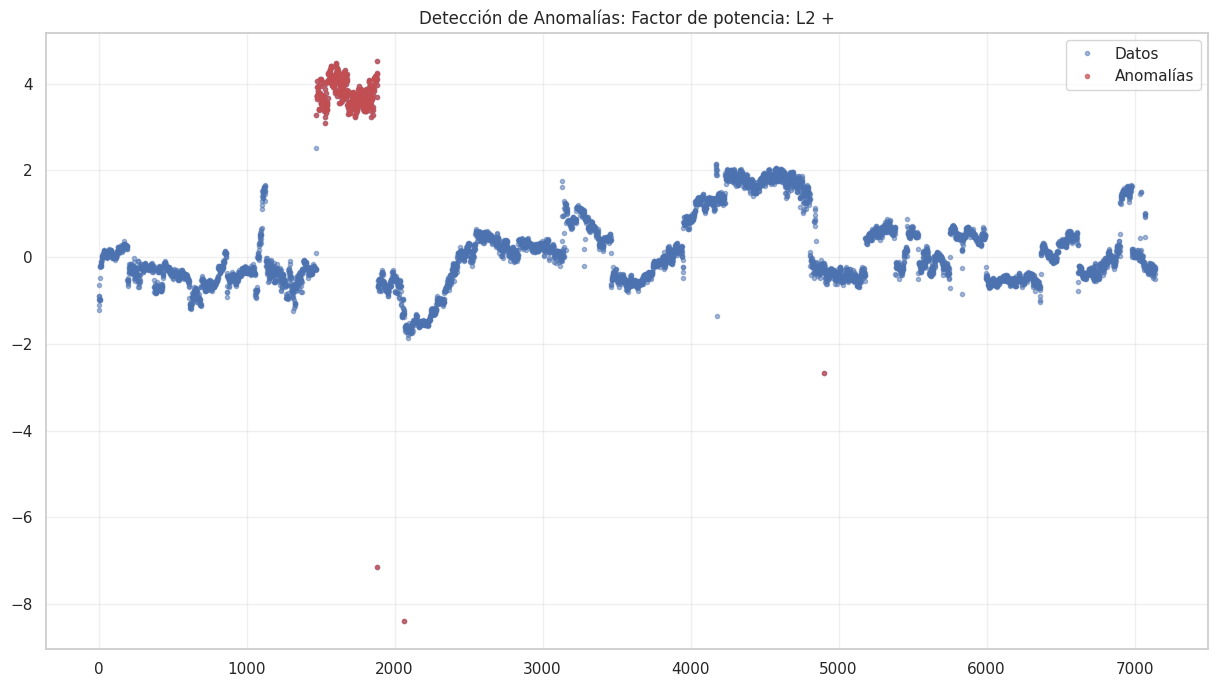


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 1.00)

Analizando Factor de potencia: L1 +:


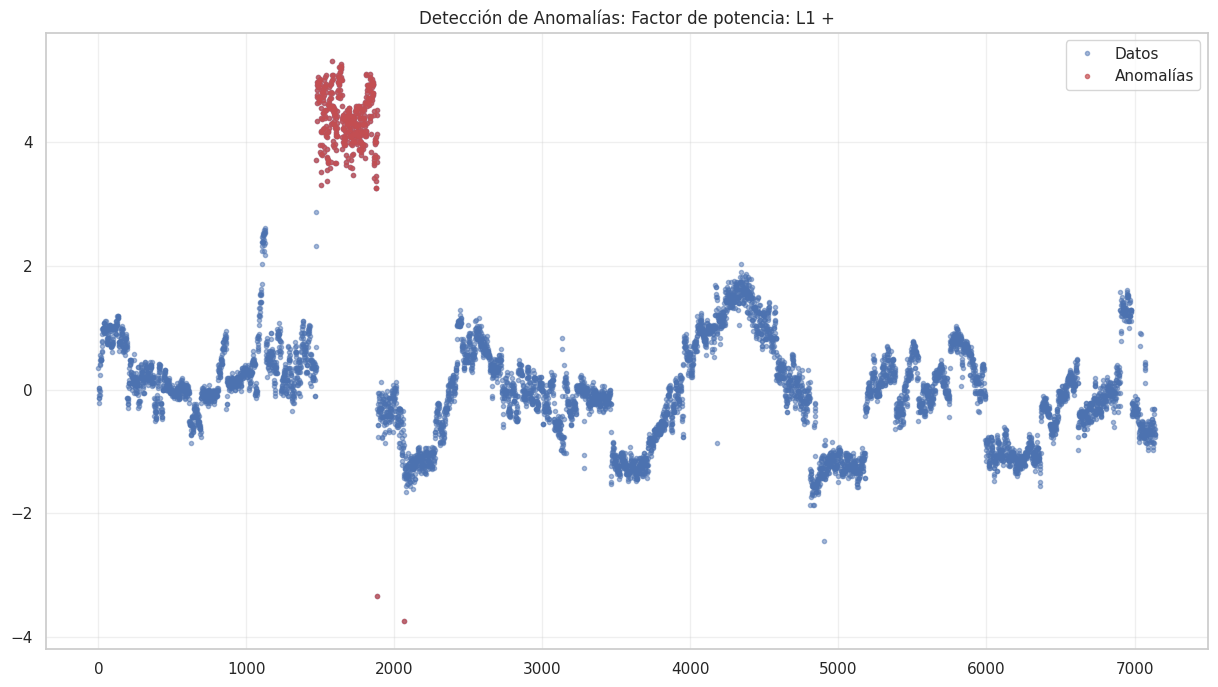


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 412, score: 1.00)

Analizando Corriente: L1 (A):


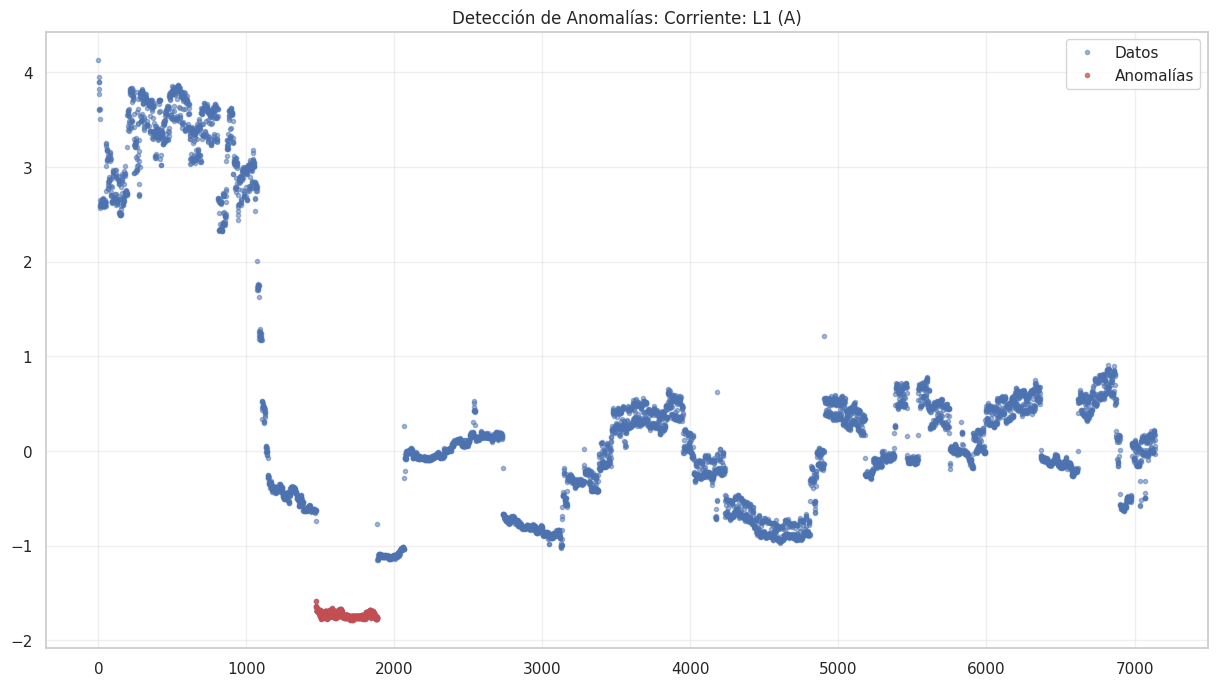


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 0.88)

Analizando Armónicos VL3: Armónico 5 (%VL3):


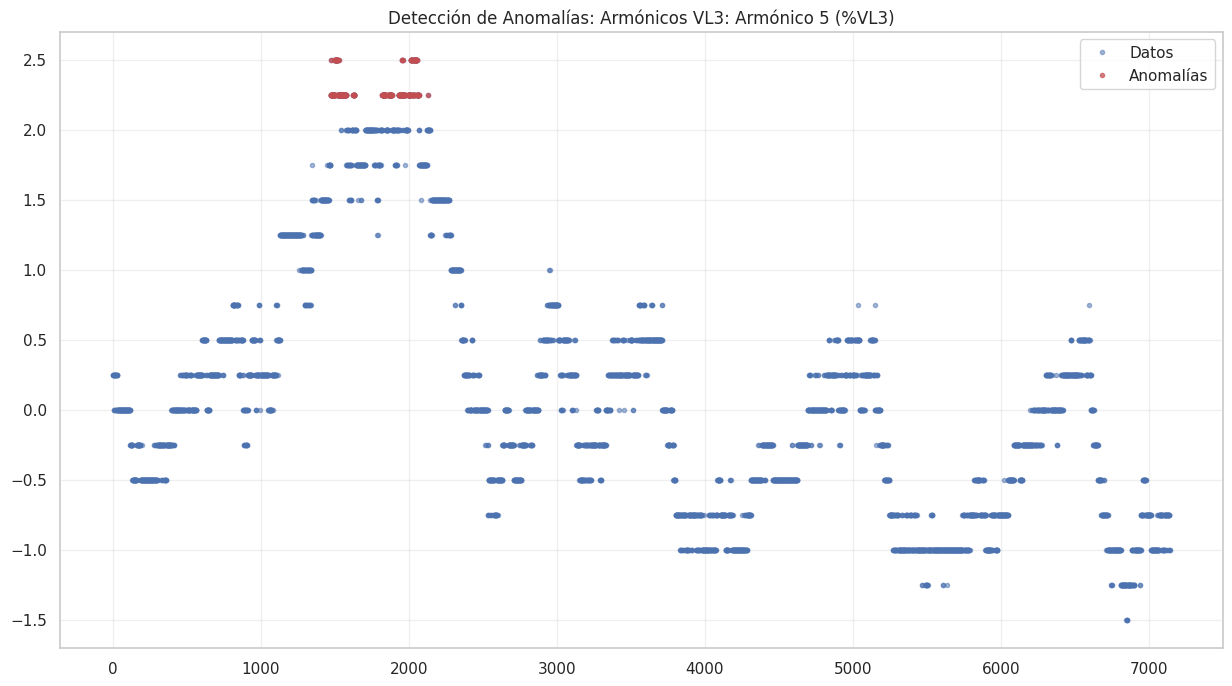


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 69, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 19, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 72, score: 0.90)

Analizando Factor de potencia: L3 +:


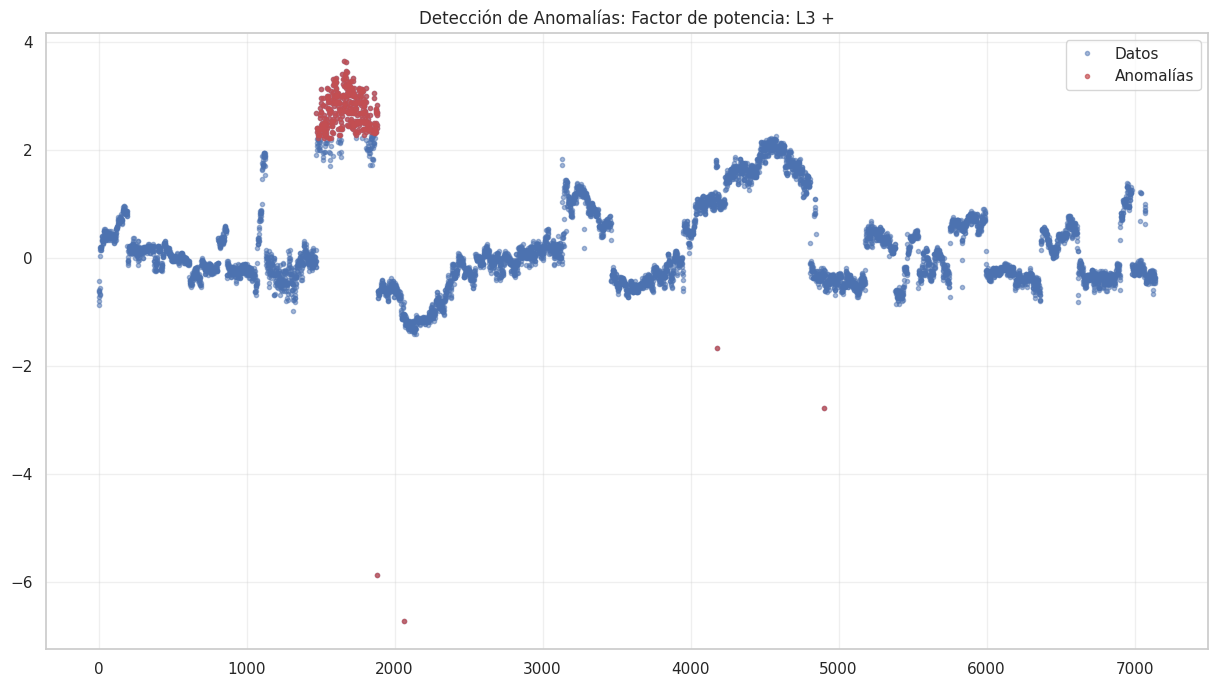


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 3, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 15, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 8, score: 0.97)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 6, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 8, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 8, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 4, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 11, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 37, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.86)
- [ALTA] Racha anómala detectada (duración: 95, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 44, score: 1.00)
- [ALTA] Racha anómala detectada (d

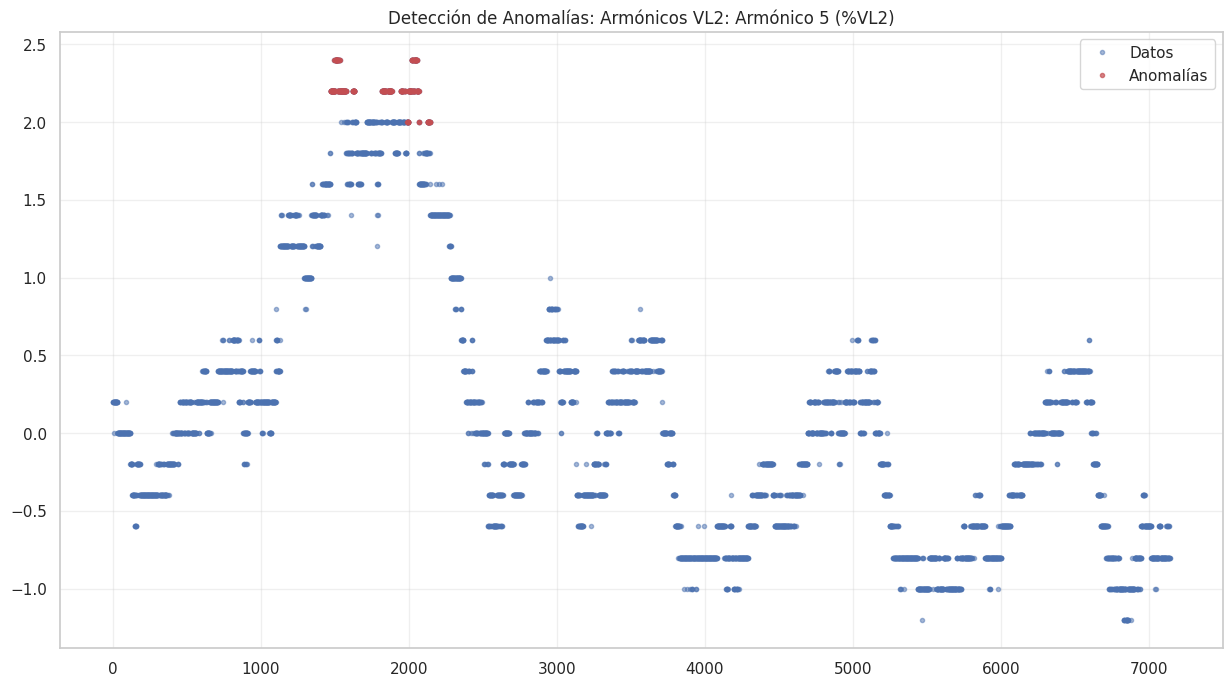


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 69, score: 0.86)
- [ALTA] Racha anómala detectada (duración: 78, score: 0.89)

Analizando Distorsión armónica: IL3 (%I THD):


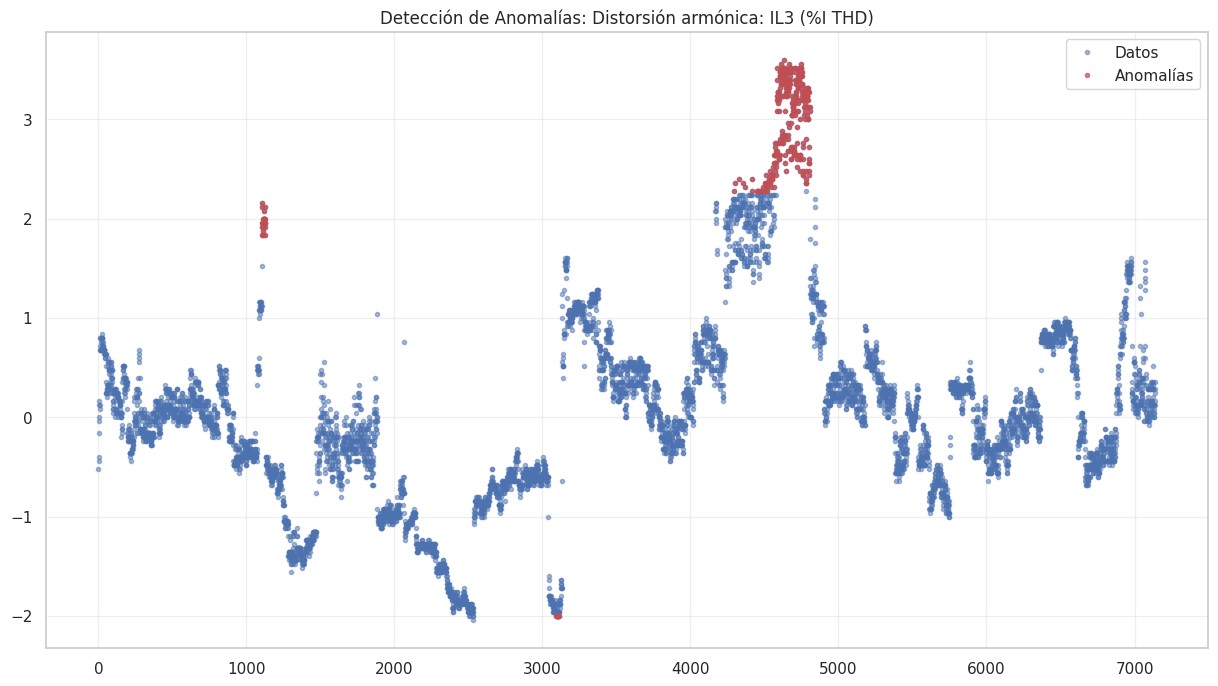


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 24, score: 0.85)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 201, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 25, score: 1.00)

Analizando Armónicos IL2: Armónico 7 (%IL2):


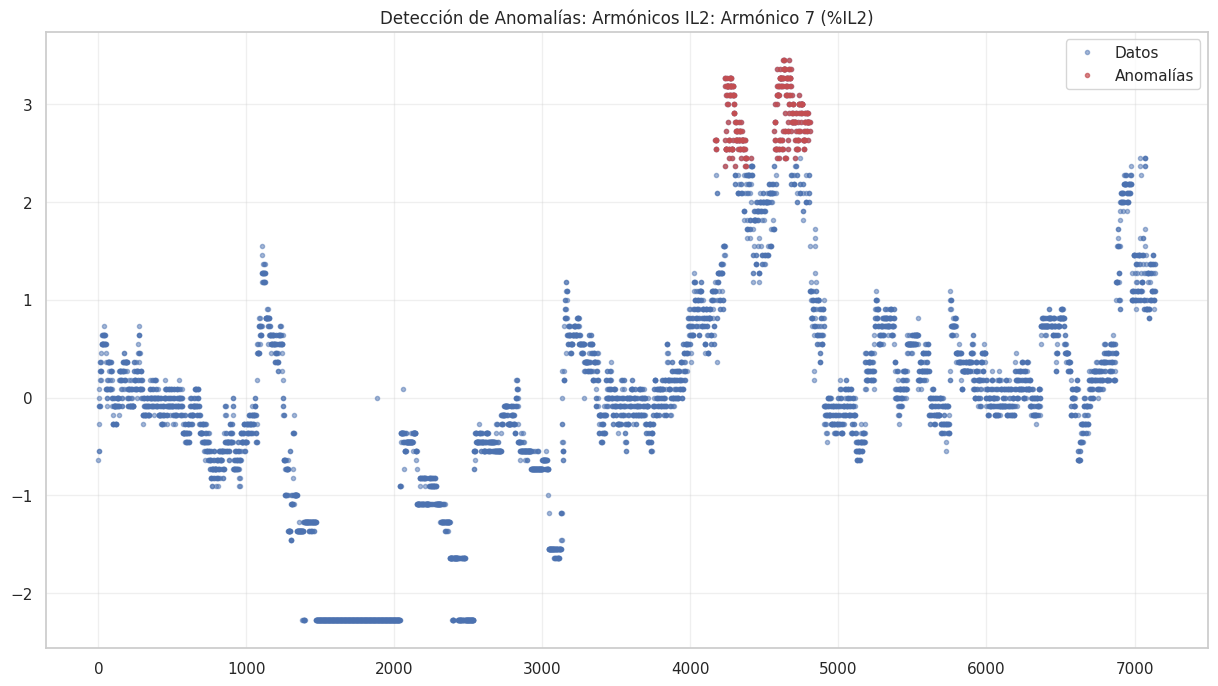


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 6, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 68, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.85)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.85)
- [ALTA] Racha anómala detectada (duración: 13, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 11, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 97, score: 1.00)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.81)

Analizando Armónicos VL1: Ar

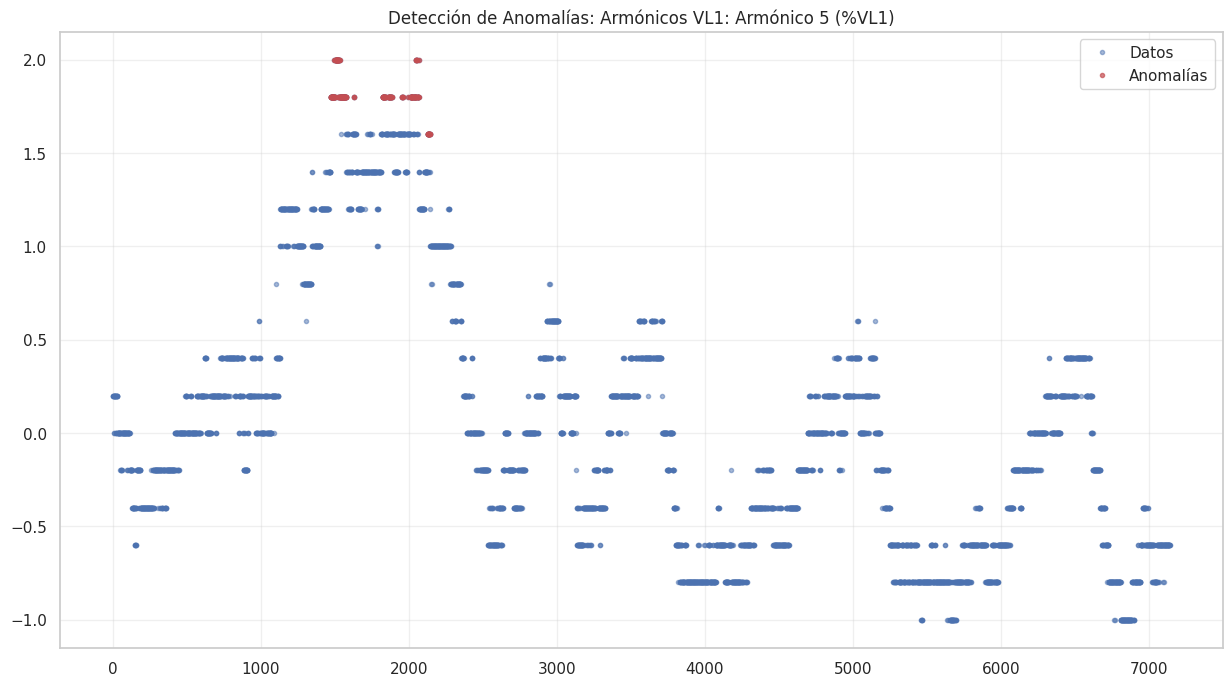


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 69, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 5, score: 0.80)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.80)
- [ALTA] Racha anómala detectada (duración: 19, score: 0.92)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.92)

Analizando Distorsión armónica: IL2 (%I THD):


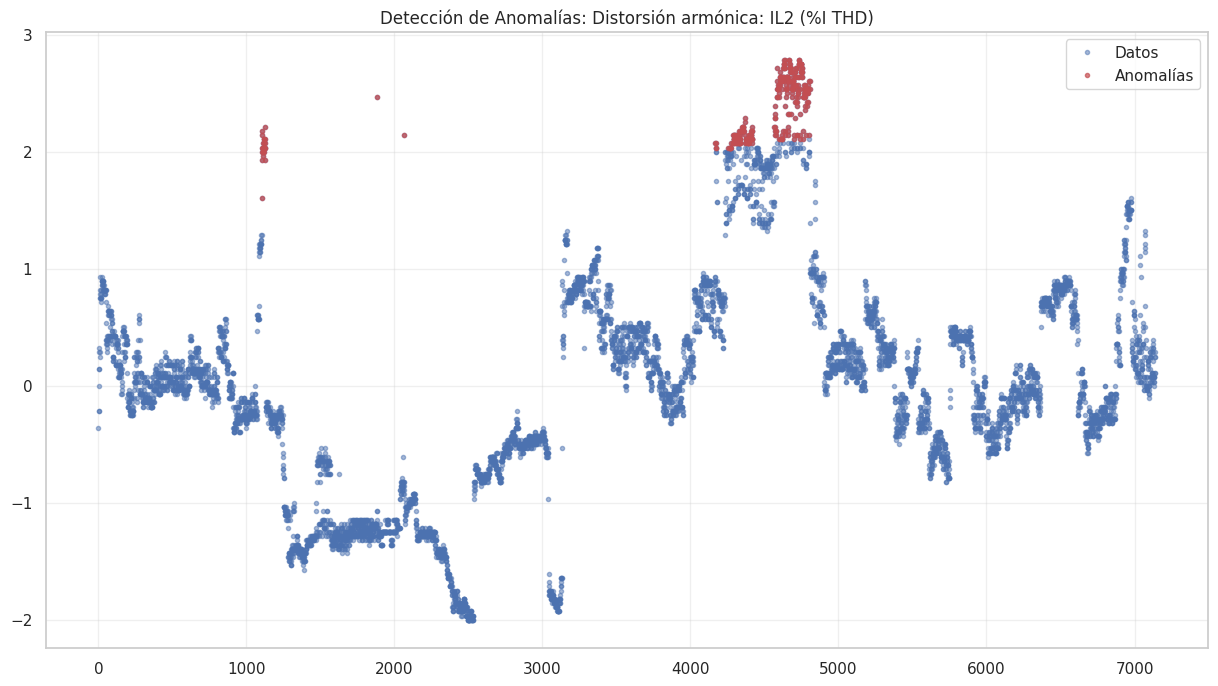


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 26, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 11, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.93)
- [ALTA] Racha anómala detectada (duración: 19, score: 0.92)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.96)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.93)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.88)

Analizando Armónicos IL2: Armónico 3 (%IL2):


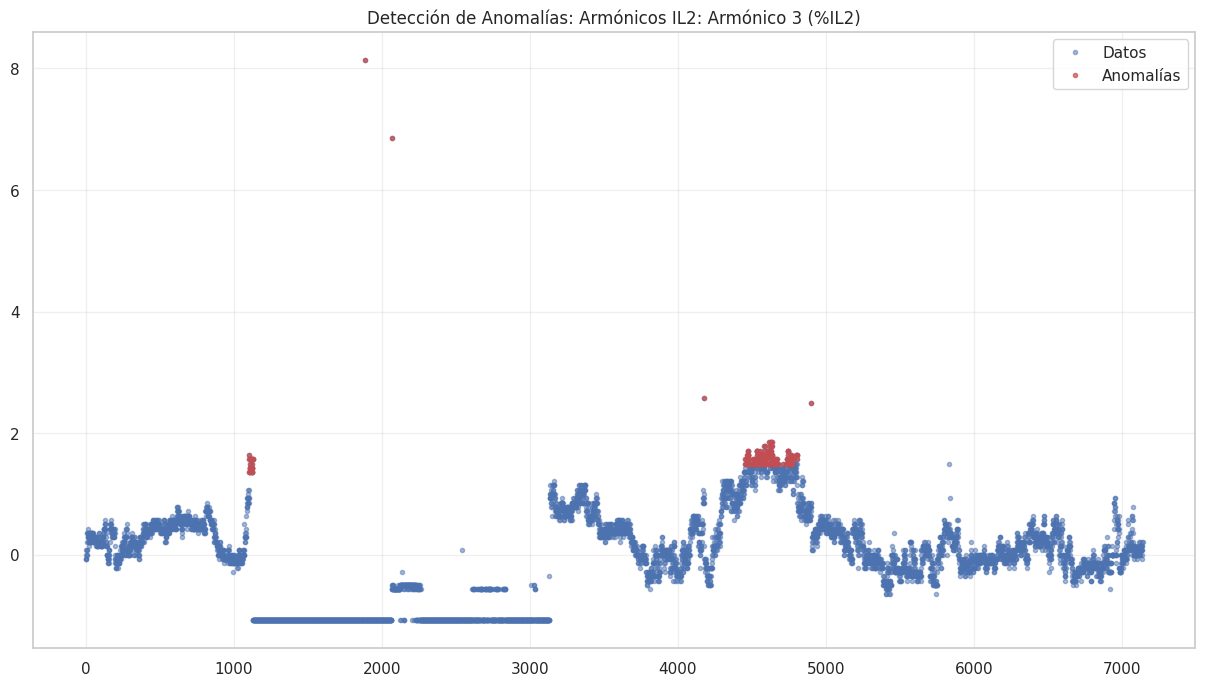


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 24, score: 0.89)
- [ALTA] Racha anómala detectada (duración: 13, score: 0.82)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.81)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 11, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.87)
- [ALTA] Racha anómala detectada (duración: 8, score: 0.80)

Analizando Armónicos VL1: Armónico 11 (%VL1):


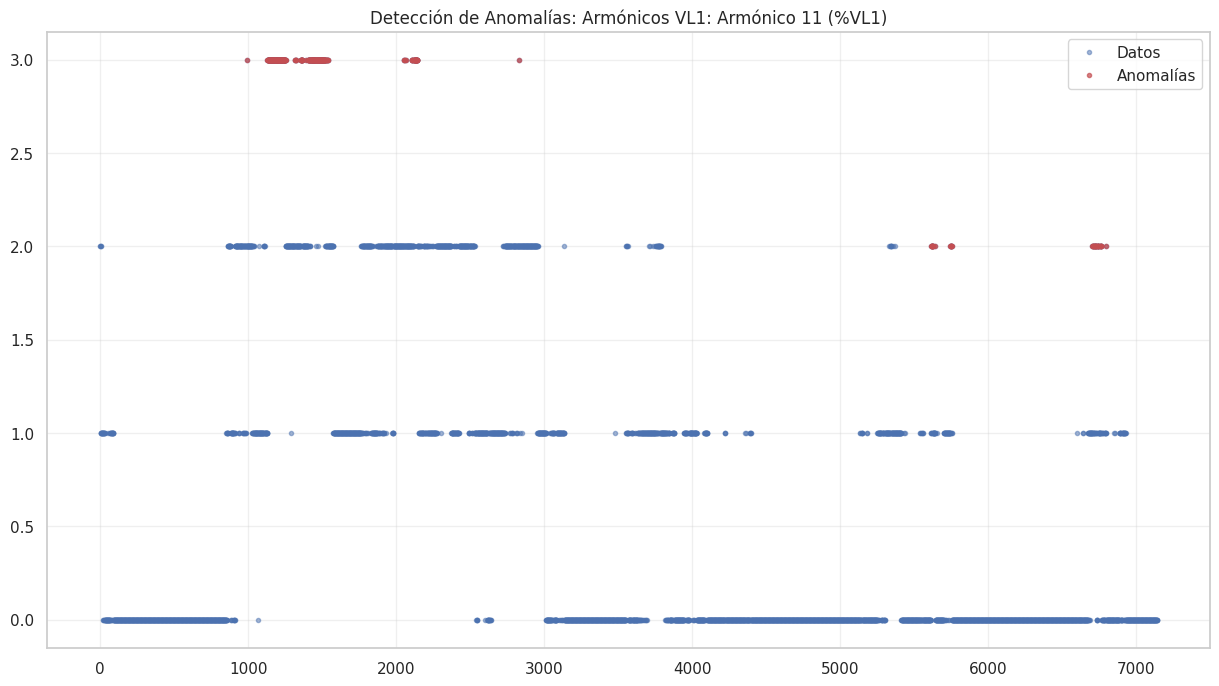


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 124, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 5, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 5, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 10, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 36, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 47, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.83)
- [ALTA] Racha anómala detectada (duración: 24, score: 0.84)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 3, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 6, score: 0.91)
- [ALTA] Racha anómala detectada 

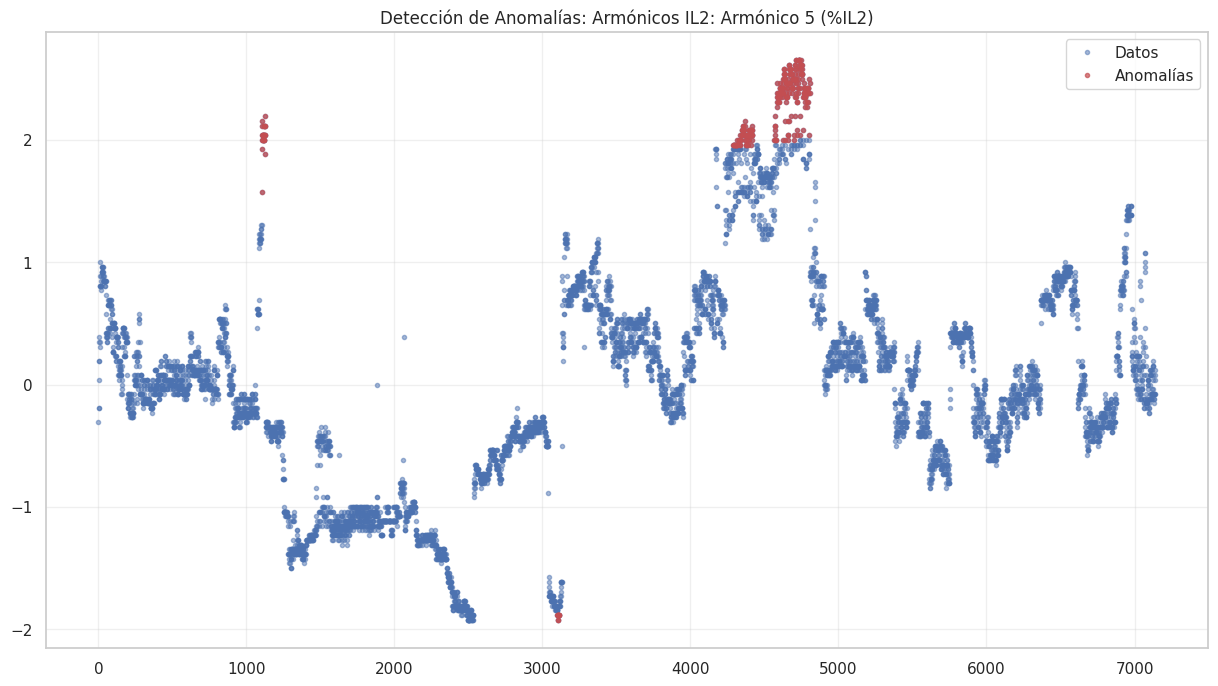


Alertas generadas:
- [CRÍTICA] Severidad CRÍTICA detectada
- [ALTA] Racha anómala detectada (duración: 26, score: 0.98)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.93)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.90)
- [ALTA] Racha anómala detectada (duración: 17, score: 0.94)
- [ALTA] Racha anómala detectada (duración: 16, score: 0.91)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 18, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.95)
- [ALTA] Racha anómala detectada (duración: 15, score: 0.88)
- [ALTA] Racha anómala detectada (duración: 14, score: 0.86)
- [ALTA] Racha anómala detectada (duración: 4, score: 0.89)

Analizando Corriente: L3 (A):


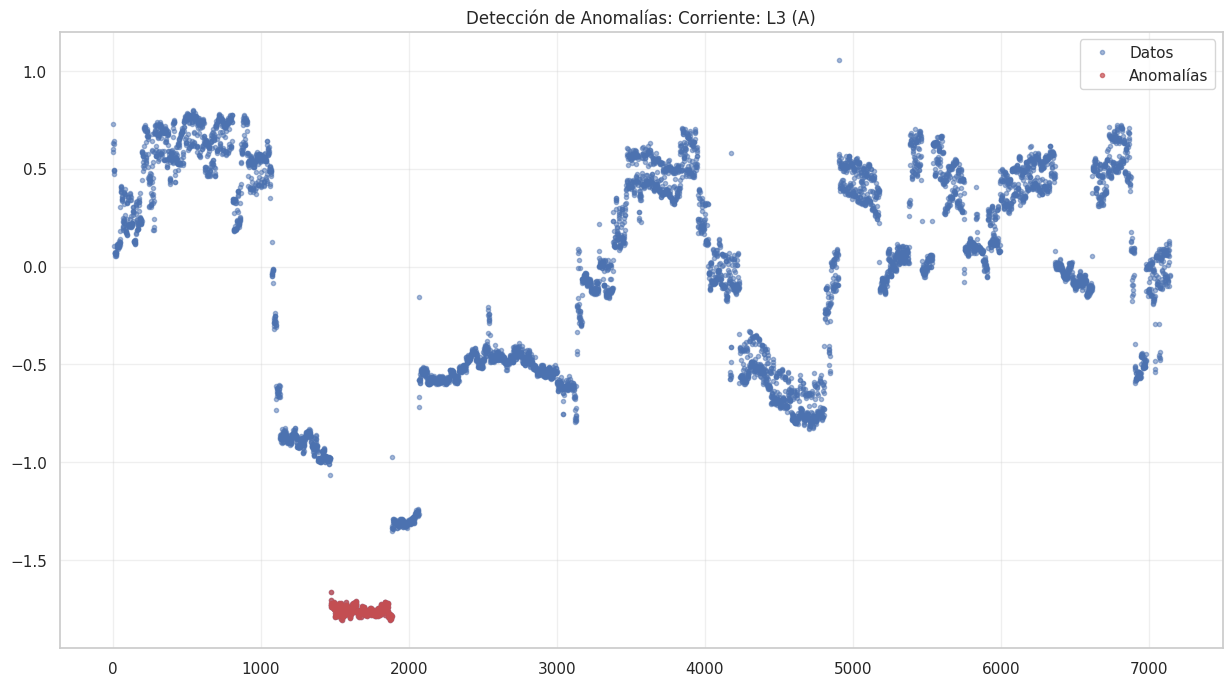


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 0.84)

Analizando Corriente: L2 (A):


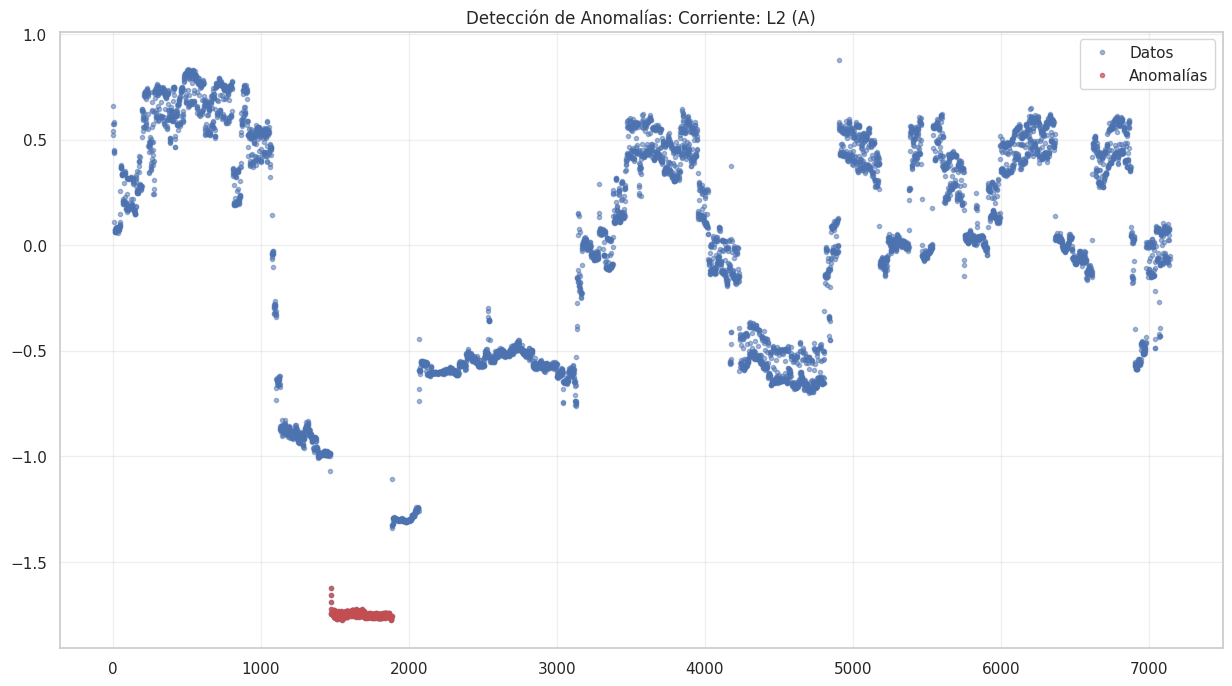


Alertas generadas:
- [ALTA] Severidad ALTA detectada
- [ALTA] Racha anómala detectada (duración: 413, score: 0.83)

=== RESUMEN DE PRUEBAS ===
Variables analizadas: 15

Resultados por variable:

Factor de potencia: L2 +:
- Severidad: CRÍTICA
- Anomalías: 415
- Tendencia: ESTABLE

Factor de potencia: L1 +:
- Severidad: CRÍTICA
- Anomalías: 413
- Tendencia: ESTABLE

Corriente: L1 (A):
- Severidad: ALTA
- Anomalías: 413
- Tendencia: ESTABLE

Armónicos VL3: Armónico 5 (%VL3):
- Severidad: ALTA
- Anomalías: 275
- Tendencia: ESTABLE

Factor de potencia: L3 +:
- Severidad: CRÍTICA
- Anomalías: 341
- Tendencia: ESTABLE

Armónicos VL2: Armónico 5 (%VL2):
- Severidad: ALTA
- Anomalías: 274
- Tendencia: ESTABLE

Distorsión armónica: IL3 (%I THD):
- Severidad: CRÍTICA
- Anomalías: 315
- Tendencia: ESTABLE

Armónicos IL2: Armónico 7 (%IL2):
- Severidad: CRÍTICA
- Anomalías: 320
- Tendencia: ESTABLE

Armónicos VL1: Armónico 5 (%VL1):
- Severidad: CRÍTICA
- Anomalías: 210
- Tendencia: ESTABLE

Disto

In [7]:
#CELDA 7 - Pruebas del Sistema Integrado de Detección de Fallas:

def test_integrated_system():
    """Prueba integrada del sistema completo."""
    try:
        print("\nINICIANDO PRUEBAS DEL SISTEMA INTEGRADO")
        print("="*50)
        
        # 1. Validación exhaustiva de prerrequisitos
        required_components = {
            'processed_data': ('Datos procesados', pd.DataFrame),
            'baseline_learner': ('Sistema de línea base', BaselineLearner),
            'critical_vars': ('Variables críticas', list),
            'baseline_results': ('Resultados base', dict)
        }
        
        for var_name, (description, expected_type) in required_components.items():
            if var_name not in globals():
                raise ValueError(f"Error: {description} no encontrados")
            if not isinstance(globals()[var_name], expected_type):
                raise ValueError(f"Error: {description} con tipo incorrecto")
            
        if not critical_vars:
            raise ValueError("No hay variables críticas definidas")
            
        # 2. Verificación adicional del sistema base
        if not baseline_learner.results['baseline_models']:
            raise ValueError("Sistema base sin modelos entrenados")
            
        # 3. Crear y configurar detector
        detector = AnomalyDetector(baseline_learner)
        print("✓ Detector configurado correctamente")
        
        # 4. Ejecutar detección de anomalías
        results = detector.detect_anomalies(processed_data)
        if not results:
            raise ValueError("Error en detección de anomalías")
            
        # 5. Análisis de resultados
        test_results = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'variables_analyzed': list(results['anomalies'].keys()),
            'summary': {}
        }
        
        for var_name, data in results['anomalies'].items():
            # Análisis por variable
            test_results['summary'][var_name] = {
                'severity': data['severity'],
                'total_anomalies': sum(data['is_anomaly']),
                'significant_streaks': len([s for s in data['streaks'] if s['max_score'] > 0.8]),
                'trend': data['trends']['trend_direction'],
                'stability': data['trends']['stability']
            }
            
            # Visualización
            print(f"\nAnalizando {var_name}:")
            detector.visualize_anomalies(var_name)
            
            # Alertas
            alerts = detector.generate_alerts(var_name)
            if alerts:
                print("\nAlertas generadas:")
                for alert in alerts:
                    print(f"- [{alert['level']}] {alert['message']}")
                test_results['summary'][var_name]['alerts'] = alerts
        
        # 6. Reporte final
        print("\n=== RESUMEN DE PRUEBAS ===")
        print(f"Variables analizadas: {len(test_results['variables_analyzed'])}")
        print("\nResultados por variable:")
        for var, summary in test_results['summary'].items():
            print(f"\n{var}:")
            print(f"- Severidad: {summary['severity']}")
            print(f"- Anomalías: {summary['total_anomalies']}")
            print(f"- Tendencia: {summary['trend']}")
            
        return detector, test_results
        
    except Exception as e:
        print(f"\nError en pruebas del sistema: {str(e)}")
        return None, None

# Ejecutar pruebas integradas
print("\nIniciando sistema de detección de fallas...")
detector, test_results = test_integrated_system()

if detector and test_results:
    print("\n✓ Pruebas completadas exitosamente")
    
    # Guardar resultados si es necesario
    # pd.to_pickle(test_results, 'test_results.pkl')
else:
    print("\n⚠ Las pruebas no se completaron correctamente")

In [8]:
# CELDA 7: Fase 4 - Análisis de Probabilidad de Fallas
"""
Fase 4 (Continuación): Análisis de Probabilidad de Fallas
======================================================

Objetivo: Integrar los tres principios fundamentales del detector de fallas:
1. Detección de anomalías (ya implementado en AnomalyDetector)
2. Análisis de tendencias (ya implementado en AnomalyDetector)
3. Evaluación frente a límites (ya implementado en AnomalyDetector)

Esta celda extiende la funcionalidad del AnomalyDetector para:
- Calcular probabilidades de falla
- Generar métricas de rendimiento
- Crear reportes interpretativos
"""

# Extender la clase AnomalyDetector con los nuevos métodos
class AnomalyDetector(AnomalyDetector):  # Heredamos de la implementación anterior
    def analyze_fault_probability(self, var_name: str) -> Dict[str, Any]:
        """
        Calcula la probabilidad de falla integrando los tres principios fundamentales.
        """
        try:
            if var_name not in self.results['anomalies']:
                return None
                
            data = self.results['anomalies'][var_name]
            
            # 1. Detección de anomalías (30%)
            anomaly_score = np.mean(data['scores'])
            
            # 2. Análisis de tendencias (40%)
            trend_analysis = data['trends']
            trend_score = 0.0
            if trend_analysis['trend_direction'] == "CRECIENTE":
                trend_score = min(1.0, trend_analysis['trend_magnitude'] * 10)
            
            # 3. Evaluación de límites (30%)
            limits_violation = len([s for s in data['streaks'] 
                                  if s['max_score'] > self.thresholds['anomaly']])
            limits_score = min(1.0, limits_violation / 10)
            
            # Probabilidad combinada
            fault_probability = (
                0.3 * anomaly_score +
                0.4 * trend_score +
                0.3 * limits_score
            )
            
            return {
                'fault_probability': fault_probability,
                'analysis': {
                    'anomaly_contribution': anomaly_score,
                    'trend_contribution': trend_score,
                    'limits_contribution': limits_score,
                    'severity': data['severity'],
                    'trend_direction': trend_analysis['trend_direction'],
                    'significant_violations': limits_violation
                }
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis de fallas: {str(e)}")
            return None

    def calculate_performance_metrics(self) -> Dict[str, float]:
        """
        Calcula las métricas de rendimiento del detector.
        """
        try:
            metrics = {
                'detection_rate': 0.0,
                'false_positive_rate': 0.0,
                'response_time': 0.0,
                'early_warning_rate': 0.0
            }
            
            total_vars = len(self.results['anomalies'])
            if total_vars == 0:
                return metrics
                
            detected_faults = sum(
                1 for data in self.results['anomalies'].values()
                if data['severity'] in ['CRÍTICA', 'ALTA']
            )
            
            metrics['detection_rate'] = detected_faults / total_vars
            
            early_warnings = sum(
                1 for data in self.results['anomalies'].values()
                if any(s['length'] >= 3 for s in data['streaks'])
            )
            
            metrics['early_warning_rate'] = early_warnings / total_vars
            
            return metrics
            
        except Exception as e:
            self.logger.error(f"Error calculando métricas: {str(e)}")
            return None

    def generate_interpretative_report(self, var_name: str) -> str:
        """
        Genera un reporte interpretativo de la probabilidad de falla.
        """
        try:
            analysis = self.analyze_fault_probability(var_name)
            if not analysis:
                return "No hay datos suficientes para el análisis"
                
            prob = analysis['fault_probability']
            details = analysis['analysis']
            
            message = [f"\nAnálisis de Fallas: {var_name}"]
            message.append("=" * 50)
            
            message.append(f"\nProbabilidad de Falla: {prob:.1%}")
            
            message.append("\nFactores Contribuyentes:")
            message.append(f"- Anomalías: {details['anomaly_contribution']:.1%}")
            message.append(f"- Tendencias: {details['trend_contribution']:.1%}")
            message.append(f"- Límites: {details['limits_contribution']:.1%}")
            
            message.append("\nRecomendaciones:")
            if prob > 0.8:
                message.append("⚠ ACCIÓN INMEDIATA REQUERIDA")
            elif prob > 0.6:
                message.append("⚠ Programar revisión preventiva")
            elif prob > 0.4:
                message.append("ℹ Monitorear de cerca")
            else:
                message.append("✓ Operación normal")
                
            return "\n".join(message)
            
        except Exception as e:
            self.logger.error(f"Error generando reporte: {str(e)}")
            return "Error en generación de reporte"

# Función de prueba para el análisis de fallas
def test_fault_analysis():
    """Prueba el sistema de análisis de fallas."""
    try:
        print("\nPRUEBA DEL SISTEMA DE ANÁLISIS DE FALLAS")
        print("="*50)
        
        # 1. Verificar detector existente
        if 'detector' not in globals():
            print("Error: Ejecutar primero el detector de anomalías")
            return
            
        # 2. Analizar cada variable crítica
        for var in critical_vars:
            print(f"\nAnalizando {var}:")
            
            # Calcular probabilidad de falla
            prob_analysis = detector.analyze_fault_probability(var)
            if prob_analysis:
                prob = prob_analysis['fault_probability']
                print(f"Probabilidad de falla: {prob:.1%}")
                
                # Generar reporte interpretativo
                report = detector.generate_interpretative_report(var)
                print(report)
                
        # 3. Calcular métricas generales
        metrics = detector.calculate_performance_metrics()
        if metrics:
            print("\nMÉTRICAS DE RENDIMIENTO")
            print("="*30)
            print(f"Tasa de detección: {metrics['detection_rate']:.1%}")
            print(f"Tasa de alerta temprana: {metrics['early_warning_rate']:.1%}")
        
    except Exception as e:
        print(f"Error en prueba de fallas: {str(e)}")

# Ejecutar pruebas
print("\nIniciando análisis de fallas...")
test_fault_analysis()


Iniciando análisis de fallas...

PRUEBA DEL SISTEMA DE ANÁLISIS DE FALLAS

Analizando Factor de potencia: L2 +:
Error en prueba de fallas: 'AnomalyDetector' object has no attribute 'analyze_fault_probability'
